In [1]:
# Load packages
from datetime import datetime
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import sys

In [2]:
# declare universal variables
CONDITION = 'fgr+hyp'
CONDITION_CLINICAL_DF = 'FGR+hyp'
SUFFIX = ' (protein)'

In [3]:
# Set up logger
os.remove('spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.log')
logger = logging.getLogger('analytics')

# Set the logging level
logger.setLevel(logging.INFO)

# Define a log format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a console handler to output log messages to the console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# (Optional) Create a file handler to log messages to a file
file_handler = logging.FileHandler('spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [4]:
dfpb = pd.read_table('../data/proteins-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmb = pd.read_table('../data/metabolites-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmirna = pd.read_table('../data/mirna-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dftb = pd.read_table('../data/transcripts-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfph = pd.read_table('../data/PlacentalHistopathologyReportsCleaned.csv', sep=',', dtype={'Patient-ID':str})
dfph2 = pd.read_table('../data/PlacentalHistopathologySlideFeaturesCleaned.csv', sep=',', dtype={'Patient-ID':str})

dfp_analyte = pd.read_table('../data/protein-meta-final.csv', sep=',')
dfm_analyte = pd.read_table('../data/metabolites-meta-final.csv', sep=',')
dfmirna_analyte = pd.read_table('../data/mirna-meta-final.csv', sep=',')
dft_analyte = pd.read_table('../data/transcripts-meta-final.csv', sep=',')

df_clinical = pd.read_table('../data/metadata-final.csv', sep=',', dtype={'Study_ID/ID':str})
df_clinical = df_clinical[df_clinical['Condition']==CONDITION_CLINICAL_DF]

In [5]:
dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((321, 352), (319, 866), (294, 450), (294, 9585), (275, 6), (348, 9), (33, 21))

# Set up annotations

In [6]:
metabolites = {}
for index, row in dfm_analyte.iterrows():
    metabolites[row['CHEMICAL_NAME']] = {'name': row['CHEMICAL_NAME'], 'sub_group': row['SUB_PATHWAY'], 'super_group': row['SUPER_PATHWAY']}
    
miRNAs = {}
for index, row in dfmirna_analyte.iterrows():
    miRNAs[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
proteins = {}
for index, row in dfp_analyte.iterrows():
    proteins[row['Assay'] + SUFFIX] = {'name': row['Assay'], 'sub_group': None, 'super_group': row['Panel']}
    
transcripts = {}
for index, row in dft_analyte.iterrows():
    transcripts[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
histopathology = {}
for item in dfph:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
for item in dfph2:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
        
# print the number of included analytes
print('Histopathology Features:', str(len(histopathology)))
print('Metabolites:', str(len(metabolites)))
print('miRNAs:', str(len(miRNAs)))
print('Proteins:', str(len(proteins)))
print('Transcripts:', str(len(transcripts)))
print('Total:', str(len(histopathology)+len(metabolites)+len(miRNAs)+len(proteins)+len(transcripts)))

Histopathology Features: 13
Metabolites: 1032
miRNAs: 2414
Proteins: 452
Transcripts: 51174
Total: 55085


# Merge against prot/met data

In [7]:
dfm_analyte = list(set(metabolites.keys()).intersection(dfmb.columns))
dfmirna_analyte = list(set(miRNAs.keys()).intersection(dfmirna.columns))
dfp_analyte = list(set(proteins.keys()).intersection(dfpb.columns))
dft_analyte = list(set(transcripts.keys()).intersection(dftb.columns))
dfph_measurement = ['MVM', 'FVM', 'AI', 'CI', 'Placental Abnormality']
dfph_measurement2 = ['DVH', 'AVM', 'Syncytial Knots', 'Segmental Avascular Villi', 'DVM', 'Villitis of Unknown Etiology', 'Diffuse Villous Edema', 'Chorangiosis']

# Get all analytes together
analytes = dfph_measurement + dfph_measurement2 + dfm_analyte + dfmirna_analyte + dfp_analyte + dft_analyte

# print the number of included analytes that pass missingness threshold
print('Histopathology Features:', str(len(dfph_measurement)+len(dfph_measurement2)))
print('Metabolites:', str(len(dfm_analyte)))
print('miRNAs:', str(len(dfmirna_analyte)))
print('Proteins:', str(len(dfp_analyte)))
print('Transcripts:', str(len(dft_analyte)))
print('Total:', str(len(analytes)))

Histopathology Features: 13
Metabolites: 865
miRNAs: 448
Proteins: 343
Transcripts: 9582
Total: 11251


In [8]:
df_clinical.head()

,Patient-ID,Condition,LaborInitiation,MaternalAge,isWhite,isBlack,isAsian,Ethnicity,WksGest,PregravidBMI,...,Para,LaborOnset,Smoker,IllicitDrugUser,DeliveryMethod,PregnancyRelatedHypertension,FetalGrowthRestriction,Preeclampsia,InfSex,Birthweight
5,MJ-0008,FGR+hyp,0,19.0,1.0,0.0,0.0,0.0,33.285714,NaN,...,0.0,0.0,-1.0,0.0,1.0,1,1,1,1.0,887.0
6,MJ-0015,FGR+hyp,0,28.0,1.0,0.0,0.0,0.0,30.142857,36.686464,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.0,921.0
7,MJ-0025,FGR+hyp,0,20.0,0.0,1.0,0.0,0.0,30.000000,NaN,...,0.0,0.0,0.0,0.0,1.0,1,1,1,0.0,954.0
8,MJ-0034,FGR+hyp,0,18.0,0.0,1.0,0.0,-1.0,38.285714,32.812500,...,0.0,1.0,0.0,0.0,1.0,1,1,1,0.0,2343.0
11,MJ-0043,FGR+hyp,0,16.0,0.0,1.0,0.0,0.0,32.571429,20.962459,...,1.0,1.0,0.0,0.0,0.0,1,1,1,1.0,1090.0


In [9]:
df = df_clinical.merge(dfph[['Patient-ID'] + list(dfph_measurement)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfph2[['Patient-ID'] + list(dfph_measurement2)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
print(df.shape)
df = df.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.fillna(-1)

(33, 26)
(33, 34)
(30, 377)
(30, 1242)
(30, 1690)
(30, 11272)


In [10]:
df.shape, dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((30, 11272),
 (321, 352),
 (319, 866),
 (294, 450),
 (294, 9585),
 (275, 6),
 (348, 9),
 (33, 21))

In [11]:
df['InfSex'].value_counts()

InfSex
0.0    18
1.0    12
Name: count, dtype: int64

In [12]:
df['isWhite'].value_counts()

isWhite
1.0    18
0.0    12
Name: count, dtype: int64

In [13]:
df['isBlack'].value_counts()

isBlack
0.0    21
1.0     9
Name: count, dtype: int64

In [14]:
df['isAsian'].value_counts()

isAsian
0.0    29
1.0     1
Name: count, dtype: int64

In [15]:
df.head()

,Patient-ID,Condition,LaborInitiation,MaternalAge,isWhite,isBlack,isAsian,Ethnicity,WksGest,PregravidBMI,...,BFAR,GIT1,AOC3,UACA,MIR100HG,OTUD1,UBE2N,TMC4,FBXO32,FBXO21
0,MJ-0015,FGR+hyp,0,28.0,1.0,0.0,0.0,0.0,30.142857,36.686464,...,459,492,129,302,3474,312,625,885,561,716
1,MJ-0025,FGR+hyp,0,20.0,0.0,1.0,0.0,0.0,30.000000,-1.000000,...,703,637,473,559,2086,845,958,575,2066,1089
2,MJ-0034,FGR+hyp,0,18.0,0.0,1.0,0.0,-1.0,38.285714,32.812500,...,862,797,86,232,1970,476,525,1532,735,878
3,MJ-0043,FGR+hyp,0,16.0,0.0,1.0,0.0,0.0,32.571429,20.962459,...,788,1088,72,594,3500,1028,1221,1886,1044,1427
4,MJ-0062,FGR+hyp,0,19.0,0.0,1.0,0.0,0.0,35.428571,19.676858,...,439,543,121,212,4050,368,451,551,549,515


# Correlation network

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp
from statsmodels.genmod.families import family, links
import itertools

In [17]:
drop_cols = ['Patient-ID', 'Grav', 'DeliveryMethod', 
             'Para', 'PrePregWt_Kg', 'Ethnicity', 'isAsian', 
             'isBlack', 'WksGest', 'Condition', 'isWhite', 
             'Race', 'MaternalAge', 'Smoke', 'PregravidBMI',
             'HeightMeters']

# Pairwise GLM

In [18]:
def count_pairs(dat, analytes, proteins, metabolites, mirnas, transcripts, histopathology):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                    
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue
            
        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'

        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
    
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None
            
        count += 1
        
    print('Running {} pairs'.format(count))

count_pairs(df, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-04 20:56:04,196 - analytics - INFO - Created 63286875 pairs


Running 16851765 pairs


In [19]:
def evaluate_effect_size(df, logger):
    # evaluate effect size - cohen's d
    df_no_effect = df[abs(df['coef'])<0.01]
    df_very_small = df[abs(df['coef'])>=0.01]
    df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
    df_small = df[abs(df['coef'])>=0.1]
    df_small = df_small[abs(df_small['coef'])<0.2]
    df_medium = df[abs(df['coef'])>=0.2]
    df_medium  = df_medium[abs(df_medium['coef'])<0.3]
    df_medium_large = df[abs(df['coef'])>=0.3]
    df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
    df_large = df[abs(df['coef'])>=0.5]
    df_large = df_large[abs(df_large['coef'])<0.7]
    df_very_large = df[abs(df['coef'])>=0.7]
    df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
    df_huge = df[abs(df['coef'])>=0.9]
    
    # print info on effect sizes
    logger.info('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
    logger.info('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
    logger.info('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
    logger.info('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
    logger.info('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
    logger.info('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))
    logger.info('\n')
    

def run_spearman_pairwise(dat, condition, analytes, proteins, metabolites, mirnas, transcripts, histopathology, max_run=None):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
    
    f_failed = open('failed.spearman.standardized.interomics.' + condition + '.pairs.all.miniDP3.txt', mode='w')
    f_output = 'spearman.standardized.interomics.' + condition + '.all.miniDP3.txt'
    f_output_sig = 'spearman.standardized.interomics.' + condition + '.sig.miniDP3.txt'
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                           
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue

        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'
        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None

        sub = dat[['Patient-ID', col1, col2]].copy()
        sub.rename(columns={col1:'analyte1'}, inplace=True)
        sub.rename(columns={col2:'analyte2'}, inplace=True)


        if (sub['analyte1'].skew() > 1.5) | (sub['analyte1'].skew() < -1.5):

            #logger.info('Setting gamma family for skewed analyte %s'%(col))

            # Set any zero values to 1/2 the smallest value
            sub.loc[sub['analyte1']==0, 'analyte1'] = (sub.loc[sub['analyte1']>0, 'analyte1'].min() / 2.0)
            

        # z-score transform dependent variable data
        if col2 not in histopathology.keys():
            sub['analyte2'] = sub['analyte2'].astype(np.float64)
            sub['analyte2'] = (sub['analyte2'] - sub['analyte2'].mean() ) / sub['analyte2'].std()

            
        try:
            coef, p = scipy.stats.spearmanr(sub['analyte1'], sub['analyte2'])
            results.append((col1, name1, type1, supergroup1, subgroup1, col2, name2, type2, supergroup2, subgroup2, coef, p))
            completed += 1

        except Exception as e:
            logger.info('Failed analytes {} {} with error {}'.format(col1, col2, str(e)))
            f_failed.write(col1 + '\t' + col2 + '\n')
            
            
        count += 1
        if (max_run is not None) and (count >= max_run):
            break
        
        if (count % 1000) == 0:
            elapsed_time = datetime.now() - start_time    
            logger.info('Finished {} in {:.3f} seconds (skipped {})'.format(count, elapsed_time.total_seconds(), skipped))
            
    df = pd.DataFrame(results, columns=['col1', 'name1', 'type1', 'supergroup1', 'subgroup1', 'col2', 'name2', 'type2', 'supergroup2', 'subgroup2', 'coef', 'p-value'])
    df.sort_values(['p-value'], ascending=True, inplace=True)
    f_failed.close()

    np.seterr(all='warn')
    logger.info('\nFinished analyzing all {} pairs!'.format(str(count)))
    logger.info('Number of analyte pairs with converged formula: {}'.format(str(df.shape[0])))
    (adj_pval_index, adj_pval, _, _) = statsmodels.sandbox.stats.multicomp.multipletests(df.loc[~df['p-value'].isnull(), 'p-value'], alpha=0.05, method='fdr_bh')
    df.loc[~df['p-value'].isnull(), 'pval_adj'] = adj_pval
    df.sort_values(['pval_adj'], ascending=True, inplace=True)
    df.to_csv(f_output, index=False, sep='\t')
    
    # filter for significance
    df = df[df['pval_adj']<0.05]  #benjammini-hochman
    #bonferroni_correction = 0.05/count
    #df = df[df['p-value']<bonferroni_correction]  #bonferroni correction
    #logger.info('\nBonferroni Correction: p<{}'.format(str(bonferroni_correction)))
    logger.info('Number of analyte pairs whose levels are significantly associated: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
    
    # evaluate effect size - cohen's d
    logger.info('Effect Sizes (Cohen\'s D ) For Significant Correlations:')
    evaluate_effect_size(df, logger)
    logger.info('\nFinished all correlation analyses!')
    
    return df

In [20]:
os.remove('failed.spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.' + CONDITION + '.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt')

In [21]:
spearman_pairwise = run_spearman_pairwise(df, CONDITION, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-04 20:57:10,553 - analytics - INFO - Created 63286875 pairs
2024-02-04 20:57:13,283 - analytics - INFO - Finished 1000 in 2.726 seconds (skipped 0)
2024-02-04 20:57:16,082 - analytics - INFO - Finished 2000 in 5.525 seconds (skipped 0)
2024-02-04 20:57:18,946 - analytics - INFO - Finished 3000 in 8.389 seconds (skipped 0)
2024-02-04 20:57:21,782 - analytics - INFO - Finished 4000 in 11.225 seconds (skipped 0)
2024-02-04 20:57:24,848 - analytics - INFO - Finished 5000 in 14.292 seconds (skipped 0)
2024-02-04 20:57:27,704 - analytics - INFO - Finished 6000 in 17.147 seconds (skipped 0)
2024-02-04 20:57:30,500 - analytics - INFO - Finished 7000 in 19.943 seconds (skipped 0)
2024-02-04 20:57:33,386 - analytics - INFO - Finished 8000 in 22.830 seconds (skipped 0)
2024-02-04 20:57:36,672 - analytics - INFO - Finished 9000 in 26.116 seconds (skipped 0)
2024-02-04 20:57:40,014 - analytics - INFO - Finished 10000 in 29.458 seconds (skipped 0)
2024-02-04 20:57:43,485 - analytics - INFO -

2024-02-04 21:02:00,315 - analytics - INFO - Finished 91000 in 289.759 seconds (skipped 0)
2024-02-04 21:02:02,588 - analytics - INFO - Finished 92000 in 292.031 seconds (skipped 0)
2024-02-04 21:02:04,777 - analytics - INFO - Finished 93000 in 294.221 seconds (skipped 0)
2024-02-04 21:02:07,000 - analytics - INFO - Finished 94000 in 296.443 seconds (skipped 0)
2024-02-04 21:02:09,331 - analytics - INFO - Finished 95000 in 298.774 seconds (skipped 0)
2024-02-04 21:02:11,939 - analytics - INFO - Finished 96000 in 301.383 seconds (skipped 0)
2024-02-04 21:02:14,411 - analytics - INFO - Finished 97000 in 303.855 seconds (skipped 0)
2024-02-04 21:02:16,797 - analytics - INFO - Finished 98000 in 306.241 seconds (skipped 0)
2024-02-04 21:02:19,043 - analytics - INFO - Finished 99000 in 308.486 seconds (skipped 0)
2024-02-04 21:02:21,438 - analytics - INFO - Finished 100000 in 310.882 seconds (skipped 0)
2024-02-04 21:02:23,772 - analytics - INFO - Finished 101000 in 313.216 seconds (skipped 

2024-02-04 21:05:36,637 - analytics - INFO - Finished 181000 in 506.081 seconds (skipped 0)
2024-02-04 21:05:38,967 - analytics - INFO - Finished 182000 in 508.410 seconds (skipped 0)
2024-02-04 21:05:41,205 - analytics - INFO - Finished 183000 in 510.648 seconds (skipped 0)
2024-02-04 21:05:43,693 - analytics - INFO - Finished 184000 in 513.137 seconds (skipped 0)
2024-02-04 21:05:45,823 - analytics - INFO - Finished 185000 in 515.266 seconds (skipped 0)
2024-02-04 21:05:48,002 - analytics - INFO - Finished 186000 in 517.446 seconds (skipped 0)
2024-02-04 21:05:50,174 - analytics - INFO - Finished 187000 in 519.618 seconds (skipped 0)
2024-02-04 21:05:52,375 - analytics - INFO - Finished 188000 in 521.819 seconds (skipped 0)
2024-02-04 21:05:54,538 - analytics - INFO - Finished 189000 in 523.981 seconds (skipped 0)
2024-02-04 21:05:56,761 - analytics - INFO - Finished 190000 in 526.204 seconds (skipped 0)
2024-02-04 21:05:59,259 - analytics - INFO - Finished 191000 in 528.702 seconds 

2024-02-04 21:09:21,734 - analytics - INFO - Finished 271000 in 731.178 seconds (skipped 0)
2024-02-04 21:09:24,448 - analytics - INFO - Finished 272000 in 733.892 seconds (skipped 0)
2024-02-04 21:09:27,127 - analytics - INFO - Finished 273000 in 736.571 seconds (skipped 0)
2024-02-04 21:09:29,717 - analytics - INFO - Finished 274000 in 739.161 seconds (skipped 0)
2024-02-04 21:09:32,387 - analytics - INFO - Finished 275000 in 741.831 seconds (skipped 0)
2024-02-04 21:09:35,007 - analytics - INFO - Finished 276000 in 744.450 seconds (skipped 0)
2024-02-04 21:09:37,676 - analytics - INFO - Finished 277000 in 747.120 seconds (skipped 0)
2024-02-04 21:09:40,324 - analytics - INFO - Finished 278000 in 749.767 seconds (skipped 0)
2024-02-04 21:09:43,243 - analytics - INFO - Finished 279000 in 752.686 seconds (skipped 0)
2024-02-04 21:09:45,966 - analytics - INFO - Finished 280000 in 755.409 seconds (skipped 0)
2024-02-04 21:09:48,602 - analytics - INFO - Finished 281000 in 758.046 seconds 

2024-02-04 21:13:11,764 - analytics - INFO - Finished 361000 in 961.208 seconds (skipped 0)
2024-02-04 21:13:14,354 - analytics - INFO - Finished 362000 in 963.798 seconds (skipped 0)
2024-02-04 21:13:16,997 - analytics - INFO - Finished 363000 in 966.440 seconds (skipped 0)
2024-02-04 21:13:19,535 - analytics - INFO - Finished 364000 in 968.978 seconds (skipped 0)
2024-02-04 21:13:22,535 - analytics - INFO - Finished 365000 in 971.978 seconds (skipped 0)
2024-02-04 21:13:24,966 - analytics - INFO - Finished 366000 in 974.409 seconds (skipped 0)
2024-02-04 21:13:27,533 - analytics - INFO - Finished 367000 in 976.976 seconds (skipped 0)
2024-02-04 21:13:30,640 - analytics - INFO - Finished 368000 in 980.083 seconds (skipped 0)
2024-02-04 21:13:33,096 - analytics - INFO - Finished 369000 in 982.540 seconds (skipped 0)
2024-02-04 21:13:35,800 - analytics - INFO - Finished 370000 in 985.243 seconds (skipped 0)
2024-02-04 21:13:38,604 - analytics - INFO - Finished 371000 in 988.048 seconds 

2024-02-04 21:17:03,924 - analytics - INFO - Finished 450000 in 1193.367 seconds (skipped 0)
2024-02-04 21:17:06,850 - analytics - INFO - Finished 451000 in 1196.293 seconds (skipped 0)
2024-02-04 21:17:09,863 - analytics - INFO - Finished 452000 in 1199.307 seconds (skipped 0)
2024-02-04 21:17:12,961 - analytics - INFO - Finished 453000 in 1202.404 seconds (skipped 0)
2024-02-04 21:17:16,024 - analytics - INFO - Finished 454000 in 1205.468 seconds (skipped 0)
2024-02-04 21:17:18,969 - analytics - INFO - Finished 455000 in 1208.413 seconds (skipped 0)
2024-02-04 21:17:21,971 - analytics - INFO - Finished 456000 in 1211.415 seconds (skipped 0)
2024-02-04 21:17:25,049 - analytics - INFO - Finished 457000 in 1214.492 seconds (skipped 0)
2024-02-04 21:17:27,639 - analytics - INFO - Finished 458000 in 1217.082 seconds (skipped 0)
2024-02-04 21:17:30,024 - analytics - INFO - Finished 459000 in 1219.468 seconds (skipped 0)
2024-02-04 21:17:32,435 - analytics - INFO - Finished 460000 in 1221.8

2024-02-04 21:21:04,135 - analytics - INFO - Finished 539000 in 1433.578 seconds (skipped 0)
2024-02-04 21:21:07,005 - analytics - INFO - Finished 540000 in 1436.449 seconds (skipped 0)
2024-02-04 21:21:09,804 - analytics - INFO - Finished 541000 in 1439.247 seconds (skipped 0)
2024-02-04 21:21:12,711 - analytics - INFO - Finished 542000 in 1442.154 seconds (skipped 0)
2024-02-04 21:21:15,704 - analytics - INFO - Finished 543000 in 1445.148 seconds (skipped 0)
2024-02-04 21:21:18,813 - analytics - INFO - Finished 544000 in 1448.256 seconds (skipped 0)
2024-02-04 21:21:22,613 - analytics - INFO - Finished 545000 in 1452.056 seconds (skipped 0)
2024-02-04 21:21:26,211 - analytics - INFO - Finished 546000 in 1455.655 seconds (skipped 0)
2024-02-04 21:21:30,438 - analytics - INFO - Finished 547000 in 1459.882 seconds (skipped 0)
2024-02-04 21:21:34,222 - analytics - INFO - Finished 548000 in 1463.665 seconds (skipped 0)
2024-02-04 21:21:37,782 - analytics - INFO - Finished 549000 in 1467.2

2024-02-04 21:24:56,207 - analytics - INFO - Finished 628000 in 1665.651 seconds (skipped 0)
2024-02-04 21:24:58,468 - analytics - INFO - Finished 629000 in 1667.912 seconds (skipped 0)
2024-02-04 21:25:00,820 - analytics - INFO - Finished 630000 in 1670.264 seconds (skipped 0)
2024-02-04 21:25:03,002 - analytics - INFO - Finished 631000 in 1672.445 seconds (skipped 0)
2024-02-04 21:25:05,215 - analytics - INFO - Finished 632000 in 1674.659 seconds (skipped 0)
2024-02-04 21:25:07,404 - analytics - INFO - Finished 633000 in 1676.847 seconds (skipped 0)
2024-02-04 21:25:09,671 - analytics - INFO - Finished 634000 in 1679.115 seconds (skipped 0)
2024-02-04 21:25:11,985 - analytics - INFO - Finished 635000 in 1681.429 seconds (skipped 0)
2024-02-04 21:25:14,239 - analytics - INFO - Finished 636000 in 1683.683 seconds (skipped 0)
2024-02-04 21:25:16,456 - analytics - INFO - Finished 637000 in 1685.900 seconds (skipped 0)
2024-02-04 21:25:18,649 - analytics - INFO - Finished 638000 in 1688.0

2024-02-04 21:28:20,924 - analytics - INFO - Finished 717000 in 1870.367 seconds (skipped 0)
2024-02-04 21:28:23,211 - analytics - INFO - Finished 718000 in 1872.655 seconds (skipped 0)
2024-02-04 21:28:25,391 - analytics - INFO - Finished 719000 in 1874.835 seconds (skipped 0)
2024-02-04 21:28:27,572 - analytics - INFO - Finished 720000 in 1877.015 seconds (skipped 0)
2024-02-04 21:28:29,778 - analytics - INFO - Finished 721000 in 1879.222 seconds (skipped 0)
2024-02-04 21:28:31,986 - analytics - INFO - Finished 722000 in 1881.429 seconds (skipped 0)
2024-02-04 21:28:34,194 - analytics - INFO - Finished 723000 in 1883.637 seconds (skipped 0)
2024-02-04 21:28:36,429 - analytics - INFO - Finished 724000 in 1885.873 seconds (skipped 0)
2024-02-04 21:28:38,659 - analytics - INFO - Finished 725000 in 1888.102 seconds (skipped 0)
2024-02-04 21:28:40,844 - analytics - INFO - Finished 726000 in 1890.288 seconds (skipped 0)
2024-02-04 21:28:43,071 - analytics - INFO - Finished 727000 in 1892.5

2024-02-04 21:31:48,749 - analytics - INFO - Finished 806000 in 2078.192 seconds (skipped 0)
2024-02-04 21:31:51,124 - analytics - INFO - Finished 807000 in 2080.568 seconds (skipped 0)
2024-02-04 21:31:53,288 - analytics - INFO - Finished 808000 in 2082.732 seconds (skipped 0)
2024-02-04 21:31:55,475 - analytics - INFO - Finished 809000 in 2084.918 seconds (skipped 0)
2024-02-04 21:31:57,680 - analytics - INFO - Finished 810000 in 2087.124 seconds (skipped 0)
2024-02-04 21:32:00,383 - analytics - INFO - Finished 811000 in 2089.827 seconds (skipped 0)
2024-02-04 21:32:03,050 - analytics - INFO - Finished 812000 in 2092.494 seconds (skipped 0)
2024-02-04 21:32:05,727 - analytics - INFO - Finished 813000 in 2095.170 seconds (skipped 0)
2024-02-04 21:32:08,464 - analytics - INFO - Finished 814000 in 2097.908 seconds (skipped 0)
2024-02-04 21:32:11,287 - analytics - INFO - Finished 815000 in 2100.730 seconds (skipped 0)
2024-02-04 21:32:14,251 - analytics - INFO - Finished 816000 in 2103.6

2024-02-04 21:35:28,150 - analytics - INFO - Finished 895000 in 2297.594 seconds (skipped 0)
2024-02-04 21:35:30,823 - analytics - INFO - Finished 896000 in 2300.267 seconds (skipped 0)
2024-02-04 21:35:33,506 - analytics - INFO - Finished 897000 in 2302.950 seconds (skipped 0)
2024-02-04 21:35:36,149 - analytics - INFO - Finished 898000 in 2305.593 seconds (skipped 0)
2024-02-04 21:35:38,827 - analytics - INFO - Finished 899000 in 2308.270 seconds (skipped 0)
2024-02-04 21:35:41,453 - analytics - INFO - Finished 900000 in 2310.896 seconds (skipped 0)
2024-02-04 21:35:44,155 - analytics - INFO - Finished 901000 in 2313.598 seconds (skipped 0)
2024-02-04 21:35:46,838 - analytics - INFO - Finished 902000 in 2316.282 seconds (skipped 0)
2024-02-04 21:35:49,519 - analytics - INFO - Finished 903000 in 2318.962 seconds (skipped 0)
2024-02-04 21:35:52,241 - analytics - INFO - Finished 904000 in 2321.685 seconds (skipped 0)
2024-02-04 21:35:54,951 - analytics - INFO - Finished 905000 in 2324.3

2024-02-04 21:39:06,991 - analytics - INFO - Finished 984000 in 2516.435 seconds (skipped 0)
2024-02-04 21:39:09,198 - analytics - INFO - Finished 985000 in 2518.642 seconds (skipped 0)
2024-02-04 21:39:11,662 - analytics - INFO - Finished 986000 in 2521.105 seconds (skipped 0)
2024-02-04 21:39:14,022 - analytics - INFO - Finished 987000 in 2523.465 seconds (skipped 0)
2024-02-04 21:39:16,323 - analytics - INFO - Finished 988000 in 2525.767 seconds (skipped 0)
2024-02-04 21:39:18,614 - analytics - INFO - Finished 989000 in 2528.057 seconds (skipped 0)
2024-02-04 21:39:20,870 - analytics - INFO - Finished 990000 in 2530.314 seconds (skipped 0)
2024-02-04 21:39:23,309 - analytics - INFO - Finished 991000 in 2532.753 seconds (skipped 0)
2024-02-04 21:39:25,828 - analytics - INFO - Finished 992000 in 2535.272 seconds (skipped 0)
2024-02-04 21:39:28,298 - analytics - INFO - Finished 993000 in 2537.742 seconds (skipped 0)
2024-02-04 21:39:30,666 - analytics - INFO - Finished 994000 in 2540.1

2024-02-04 21:42:52,215 - analytics - INFO - Finished 1072000 in 2741.659 seconds (skipped 0)
2024-02-04 21:42:54,930 - analytics - INFO - Finished 1073000 in 2744.374 seconds (skipped 0)
2024-02-04 21:42:57,616 - analytics - INFO - Finished 1074000 in 2747.059 seconds (skipped 0)
2024-02-04 21:43:00,340 - analytics - INFO - Finished 1075000 in 2749.784 seconds (skipped 0)
2024-02-04 21:43:02,980 - analytics - INFO - Finished 1076000 in 2752.424 seconds (skipped 0)
2024-02-04 21:43:05,615 - analytics - INFO - Finished 1077000 in 2755.059 seconds (skipped 0)
2024-02-04 21:43:08,314 - analytics - INFO - Finished 1078000 in 2757.757 seconds (skipped 0)
2024-02-04 21:43:10,971 - analytics - INFO - Finished 1079000 in 2760.415 seconds (skipped 0)
2024-02-04 21:43:13,753 - analytics - INFO - Finished 1080000 in 2763.196 seconds (skipped 0)
2024-02-04 21:43:16,078 - analytics - INFO - Finished 1081000 in 2765.521 seconds (skipped 0)
2024-02-04 21:43:18,308 - analytics - INFO - Finished 108200

2024-02-04 21:46:21,553 - analytics - INFO - Finished 1160000 in 2950.997 seconds (skipped 0)
2024-02-04 21:46:23,733 - analytics - INFO - Finished 1161000 in 2953.177 seconds (skipped 0)
2024-02-04 21:46:25,853 - analytics - INFO - Finished 1162000 in 2955.296 seconds (skipped 0)
2024-02-04 21:46:27,993 - analytics - INFO - Finished 1163000 in 2957.436 seconds (skipped 0)
2024-02-04 21:46:30,193 - analytics - INFO - Finished 1164000 in 2959.636 seconds (skipped 0)
2024-02-04 21:46:32,366 - analytics - INFO - Finished 1165000 in 2961.810 seconds (skipped 0)
2024-02-04 21:46:34,549 - analytics - INFO - Finished 1166000 in 2963.992 seconds (skipped 0)
2024-02-04 21:46:36,703 - analytics - INFO - Finished 1167000 in 2966.147 seconds (skipped 0)
2024-02-04 21:46:38,898 - analytics - INFO - Finished 1168000 in 2968.342 seconds (skipped 0)
2024-02-04 21:46:41,228 - analytics - INFO - Finished 1169000 in 2970.672 seconds (skipped 0)
2024-02-04 21:46:43,498 - analytics - INFO - Finished 117000

2024-02-04 21:49:33,499 - analytics - INFO - Finished 1248000 in 3142.943 seconds (skipped 0)
2024-02-04 21:49:35,691 - analytics - INFO - Finished 1249000 in 3145.135 seconds (skipped 0)
2024-02-04 21:49:37,880 - analytics - INFO - Finished 1250000 in 3147.323 seconds (skipped 0)
2024-02-04 21:49:40,033 - analytics - INFO - Finished 1251000 in 3149.477 seconds (skipped 0)
2024-02-04 21:49:42,234 - analytics - INFO - Finished 1252000 in 3151.677 seconds (skipped 0)
2024-02-04 21:49:44,395 - analytics - INFO - Finished 1253000 in 3153.839 seconds (skipped 0)
2024-02-04 21:49:46,572 - analytics - INFO - Finished 1254000 in 3156.016 seconds (skipped 0)
2024-02-04 21:49:48,769 - analytics - INFO - Finished 1255000 in 3158.213 seconds (skipped 0)
2024-02-04 21:49:50,951 - analytics - INFO - Finished 1256000 in 3160.394 seconds (skipped 0)
2024-02-04 21:49:53,672 - analytics - INFO - Finished 1257000 in 3163.116 seconds (skipped 0)
2024-02-04 21:49:56,325 - analytics - INFO - Finished 125800

2024-02-04 21:53:10,765 - analytics - INFO - Finished 1336000 in 3360.209 seconds (skipped 0)
2024-02-04 21:53:13,108 - analytics - INFO - Finished 1337000 in 3362.552 seconds (skipped 0)
2024-02-04 21:53:15,366 - analytics - INFO - Finished 1338000 in 3364.809 seconds (skipped 0)
2024-02-04 21:53:17,579 - analytics - INFO - Finished 1339000 in 3367.023 seconds (skipped 0)
2024-02-04 21:53:19,784 - analytics - INFO - Finished 1340000 in 3369.227 seconds (skipped 0)
2024-02-04 21:53:21,968 - analytics - INFO - Finished 1341000 in 3371.412 seconds (skipped 0)
2024-02-04 21:53:24,103 - analytics - INFO - Finished 1342000 in 3373.547 seconds (skipped 0)
2024-02-04 21:53:26,215 - analytics - INFO - Finished 1343000 in 3375.659 seconds (skipped 0)
2024-02-04 21:53:28,387 - analytics - INFO - Finished 1344000 in 3377.831 seconds (skipped 0)
2024-02-04 21:53:30,567 - analytics - INFO - Finished 1345000 in 3380.010 seconds (skipped 0)
2024-02-04 21:53:32,833 - analytics - INFO - Finished 134600

2024-02-04 21:56:43,398 - analytics - INFO - Finished 1424000 in 3572.842 seconds (skipped 0)
2024-02-04 21:56:45,982 - analytics - INFO - Finished 1425000 in 3575.425 seconds (skipped 0)
2024-02-04 21:56:48,622 - analytics - INFO - Finished 1426000 in 3578.065 seconds (skipped 0)
2024-02-04 21:56:51,274 - analytics - INFO - Finished 1427000 in 3580.718 seconds (skipped 0)
2024-02-04 21:56:53,878 - analytics - INFO - Finished 1428000 in 3583.322 seconds (skipped 0)
2024-02-04 21:56:56,490 - analytics - INFO - Finished 1429000 in 3585.934 seconds (skipped 0)
2024-02-04 21:56:59,078 - analytics - INFO - Finished 1430000 in 3588.522 seconds (skipped 0)
2024-02-04 21:57:01,679 - analytics - INFO - Finished 1431000 in 3591.123 seconds (skipped 0)
2024-02-04 21:57:04,326 - analytics - INFO - Finished 1432000 in 3593.769 seconds (skipped 0)
2024-02-04 21:57:06,931 - analytics - INFO - Finished 1433000 in 3596.375 seconds (skipped 0)
2024-02-04 21:57:09,610 - analytics - INFO - Finished 143400

2024-02-04 22:00:07,089 - analytics - INFO - Finished 1512000 in 3776.532 seconds (skipped 0)
2024-02-04 22:00:09,688 - analytics - INFO - Finished 1513000 in 3779.132 seconds (skipped 0)
2024-02-04 22:00:12,675 - analytics - INFO - Finished 1514000 in 3782.119 seconds (skipped 0)
2024-02-04 22:00:15,448 - analytics - INFO - Finished 1515000 in 3784.892 seconds (skipped 0)
2024-02-04 22:00:18,235 - analytics - INFO - Finished 1516000 in 3787.679 seconds (skipped 0)
2024-02-04 22:00:20,841 - analytics - INFO - Finished 1517000 in 3790.285 seconds (skipped 0)
2024-02-04 22:00:23,529 - analytics - INFO - Finished 1518000 in 3792.973 seconds (skipped 0)
2024-02-04 22:00:26,127 - analytics - INFO - Finished 1519000 in 3795.571 seconds (skipped 0)
2024-02-04 22:00:28,730 - analytics - INFO - Finished 1520000 in 3798.174 seconds (skipped 0)
2024-02-04 22:00:31,310 - analytics - INFO - Finished 1521000 in 3800.754 seconds (skipped 0)
2024-02-04 22:00:33,960 - analytics - INFO - Finished 152200

2024-02-04 22:03:35,490 - analytics - INFO - Finished 1600000 in 3984.933 seconds (skipped 0)
2024-02-04 22:03:37,592 - analytics - INFO - Finished 1601000 in 3987.036 seconds (skipped 0)
2024-02-04 22:03:39,733 - analytics - INFO - Finished 1602000 in 3989.176 seconds (skipped 0)
2024-02-04 22:03:41,892 - analytics - INFO - Finished 1603000 in 3991.336 seconds (skipped 0)
2024-02-04 22:03:44,080 - analytics - INFO - Finished 1604000 in 3993.524 seconds (skipped 0)
2024-02-04 22:03:46,253 - analytics - INFO - Finished 1605000 in 3995.696 seconds (skipped 0)
2024-02-04 22:03:48,369 - analytics - INFO - Finished 1606000 in 3997.812 seconds (skipped 0)
2024-02-04 22:03:50,494 - analytics - INFO - Finished 1607000 in 3999.937 seconds (skipped 0)
2024-02-04 22:03:52,684 - analytics - INFO - Finished 1608000 in 4002.128 seconds (skipped 0)
2024-02-04 22:03:54,981 - analytics - INFO - Finished 1609000 in 4004.425 seconds (skipped 0)
2024-02-04 22:03:57,668 - analytics - INFO - Finished 161000

2024-02-04 22:06:59,926 - analytics - INFO - Finished 1688000 in 4189.370 seconds (skipped 0)
2024-02-04 22:07:02,644 - analytics - INFO - Finished 1689000 in 4192.087 seconds (skipped 0)
2024-02-04 22:07:05,232 - analytics - INFO - Finished 1690000 in 4194.675 seconds (skipped 0)
2024-02-04 22:07:07,881 - analytics - INFO - Finished 1691000 in 4197.325 seconds (skipped 0)
2024-02-04 22:07:10,615 - analytics - INFO - Finished 1692000 in 4200.059 seconds (skipped 0)
2024-02-04 22:07:13,555 - analytics - INFO - Finished 1693000 in 4202.999 seconds (skipped 0)
2024-02-04 22:07:16,227 - analytics - INFO - Finished 1694000 in 4205.671 seconds (skipped 0)
2024-02-04 22:07:19,190 - analytics - INFO - Finished 1695000 in 4208.634 seconds (skipped 0)
2024-02-04 22:07:22,111 - analytics - INFO - Finished 1696000 in 4211.555 seconds (skipped 0)
2024-02-04 22:07:24,876 - analytics - INFO - Finished 1697000 in 4214.320 seconds (skipped 0)
2024-02-04 22:07:27,564 - analytics - INFO - Finished 169800

2024-02-04 22:10:43,461 - analytics - INFO - Finished 1776000 in 4412.905 seconds (skipped 0)
2024-02-04 22:10:45,634 - analytics - INFO - Finished 1777000 in 4415.078 seconds (skipped 0)
2024-02-04 22:10:47,754 - analytics - INFO - Finished 1778000 in 4417.197 seconds (skipped 0)
2024-02-04 22:10:49,892 - analytics - INFO - Finished 1779000 in 4419.335 seconds (skipped 0)
2024-02-04 22:10:52,139 - analytics - INFO - Finished 1780000 in 4421.582 seconds (skipped 0)
2024-02-04 22:10:54,333 - analytics - INFO - Finished 1781000 in 4423.777 seconds (skipped 0)
2024-02-04 22:10:56,502 - analytics - INFO - Finished 1782000 in 4425.946 seconds (skipped 0)
2024-02-04 22:10:58,635 - analytics - INFO - Finished 1783000 in 4428.079 seconds (skipped 0)
2024-02-04 22:11:00,821 - analytics - INFO - Finished 1784000 in 4430.265 seconds (skipped 0)
2024-02-04 22:11:02,993 - analytics - INFO - Finished 1785000 in 4432.436 seconds (skipped 0)
2024-02-04 22:11:05,654 - analytics - INFO - Finished 178600

2024-02-04 22:14:15,113 - analytics - INFO - Finished 1864000 in 4624.556 seconds (skipped 0)
2024-02-04 22:14:17,357 - analytics - INFO - Finished 1865000 in 4626.801 seconds (skipped 0)
2024-02-04 22:14:19,552 - analytics - INFO - Finished 1866000 in 4628.996 seconds (skipped 0)
2024-02-04 22:14:21,883 - analytics - INFO - Finished 1867000 in 4631.327 seconds (skipped 0)
2024-02-04 22:14:24,033 - analytics - INFO - Finished 1868000 in 4633.476 seconds (skipped 0)
2024-02-04 22:14:26,213 - analytics - INFO - Finished 1869000 in 4635.656 seconds (skipped 0)
2024-02-04 22:14:28,396 - analytics - INFO - Finished 1870000 in 4637.840 seconds (skipped 0)
2024-02-04 22:14:30,521 - analytics - INFO - Finished 1871000 in 4639.964 seconds (skipped 0)
2024-02-04 22:14:32,762 - analytics - INFO - Finished 1872000 in 4642.205 seconds (skipped 0)
2024-02-04 22:14:34,877 - analytics - INFO - Finished 1873000 in 4644.321 seconds (skipped 0)
2024-02-04 22:14:37,063 - analytics - INFO - Finished 187400

2024-02-04 22:17:42,154 - analytics - INFO - Finished 1952000 in 4831.597 seconds (skipped 0)
2024-02-04 22:17:44,836 - analytics - INFO - Finished 1953000 in 4834.279 seconds (skipped 0)
2024-02-04 22:17:47,484 - analytics - INFO - Finished 1954000 in 4836.928 seconds (skipped 0)
2024-02-04 22:17:50,088 - analytics - INFO - Finished 1955000 in 4839.532 seconds (skipped 0)
2024-02-04 22:17:52,733 - analytics - INFO - Finished 1956000 in 4842.176 seconds (skipped 0)
2024-02-04 22:17:55,353 - analytics - INFO - Finished 1957000 in 4844.796 seconds (skipped 0)
2024-02-04 22:17:58,002 - analytics - INFO - Finished 1958000 in 4847.446 seconds (skipped 0)
2024-02-04 22:18:00,673 - analytics - INFO - Finished 1959000 in 4850.117 seconds (skipped 0)
2024-02-04 22:18:03,634 - analytics - INFO - Finished 1960000 in 4853.078 seconds (skipped 0)
2024-02-04 22:18:06,273 - analytics - INFO - Finished 1961000 in 4855.716 seconds (skipped 0)
2024-02-04 22:18:08,912 - analytics - INFO - Finished 196200

2024-02-04 22:21:07,980 - analytics - INFO - Finished 2040000 in 5037.424 seconds (skipped 0)
2024-02-04 22:21:10,139 - analytics - INFO - Finished 2041000 in 5039.583 seconds (skipped 0)
2024-02-04 22:21:12,440 - analytics - INFO - Finished 2042000 in 5041.884 seconds (skipped 0)
2024-02-04 22:21:14,719 - analytics - INFO - Finished 2043000 in 5044.162 seconds (skipped 0)
2024-02-04 22:21:16,895 - analytics - INFO - Finished 2044000 in 5046.338 seconds (skipped 0)
2024-02-04 22:21:19,081 - analytics - INFO - Finished 2045000 in 5048.525 seconds (skipped 0)
2024-02-04 22:21:21,261 - analytics - INFO - Finished 2046000 in 5050.704 seconds (skipped 0)
2024-02-04 22:21:23,429 - analytics - INFO - Finished 2047000 in 5052.872 seconds (skipped 0)
2024-02-04 22:21:25,563 - analytics - INFO - Finished 2048000 in 5055.007 seconds (skipped 0)
2024-02-04 22:21:27,662 - analytics - INFO - Finished 2049000 in 5057.106 seconds (skipped 0)
2024-02-04 22:21:29,854 - analytics - INFO - Finished 205000

2024-02-04 22:24:29,859 - analytics - INFO - Finished 2128000 in 5239.303 seconds (skipped 0)
2024-02-04 22:24:32,098 - analytics - INFO - Finished 2129000 in 5241.541 seconds (skipped 0)
2024-02-04 22:24:34,313 - analytics - INFO - Finished 2130000 in 5243.757 seconds (skipped 0)
2024-02-04 22:24:36,475 - analytics - INFO - Finished 2131000 in 5245.918 seconds (skipped 0)
2024-02-04 22:24:38,604 - analytics - INFO - Finished 2132000 in 5248.047 seconds (skipped 0)
2024-02-04 22:24:40,790 - analytics - INFO - Finished 2133000 in 5250.234 seconds (skipped 0)
2024-02-04 22:24:42,993 - analytics - INFO - Finished 2134000 in 5252.436 seconds (skipped 0)
2024-02-04 22:24:45,176 - analytics - INFO - Finished 2135000 in 5254.619 seconds (skipped 0)
2024-02-04 22:24:47,341 - analytics - INFO - Finished 2136000 in 5256.785 seconds (skipped 0)
2024-02-04 22:24:49,419 - analytics - INFO - Finished 2137000 in 5258.863 seconds (skipped 0)
2024-02-04 22:24:51,730 - analytics - INFO - Finished 213800

2024-02-04 22:28:07,816 - analytics - INFO - Finished 2216000 in 5457.260 seconds (skipped 0)
2024-02-04 22:28:10,421 - analytics - INFO - Finished 2217000 in 5459.865 seconds (skipped 0)
2024-02-04 22:28:13,292 - analytics - INFO - Finished 2218000 in 5462.736 seconds (skipped 0)
2024-02-04 22:28:16,105 - analytics - INFO - Finished 2219000 in 5465.549 seconds (skipped 0)
2024-02-04 22:28:18,772 - analytics - INFO - Finished 2220000 in 5468.216 seconds (skipped 0)
2024-02-04 22:28:21,272 - analytics - INFO - Finished 2221000 in 5470.716 seconds (skipped 0)
2024-02-04 22:28:23,519 - analytics - INFO - Finished 2222000 in 5472.962 seconds (skipped 0)
2024-02-04 22:28:25,657 - analytics - INFO - Finished 2223000 in 5475.101 seconds (skipped 0)
2024-02-04 22:28:27,861 - analytics - INFO - Finished 2224000 in 5477.305 seconds (skipped 0)
2024-02-04 22:28:30,038 - analytics - INFO - Finished 2225000 in 5479.482 seconds (skipped 0)
2024-02-04 22:28:32,210 - analytics - INFO - Finished 222600

2024-02-04 22:31:26,904 - analytics - INFO - Finished 2304000 in 5656.348 seconds (skipped 0)
2024-02-04 22:31:29,088 - analytics - INFO - Finished 2305000 in 5658.532 seconds (skipped 0)
2024-02-04 22:31:31,285 - analytics - INFO - Finished 2306000 in 5660.728 seconds (skipped 0)
2024-02-04 22:31:33,440 - analytics - INFO - Finished 2307000 in 5662.884 seconds (skipped 0)
2024-02-04 22:31:35,616 - analytics - INFO - Finished 2308000 in 5665.059 seconds (skipped 0)
2024-02-04 22:31:37,786 - analytics - INFO - Finished 2309000 in 5667.229 seconds (skipped 0)
2024-02-04 22:31:39,928 - analytics - INFO - Finished 2310000 in 5669.372 seconds (skipped 0)
2024-02-04 22:31:42,077 - analytics - INFO - Finished 2311000 in 5671.521 seconds (skipped 0)
2024-02-04 22:31:44,220 - analytics - INFO - Finished 2312000 in 5673.663 seconds (skipped 0)
2024-02-04 22:31:46,342 - analytics - INFO - Finished 2313000 in 5675.786 seconds (skipped 0)
2024-02-04 22:31:48,471 - analytics - INFO - Finished 231400

2024-02-04 22:34:43,094 - analytics - INFO - Finished 2392000 in 5852.538 seconds (skipped 0)
2024-02-04 22:34:45,285 - analytics - INFO - Finished 2393000 in 5854.729 seconds (skipped 0)
2024-02-04 22:34:47,420 - analytics - INFO - Finished 2394000 in 5856.864 seconds (skipped 0)
2024-02-04 22:34:49,567 - analytics - INFO - Finished 2395000 in 5859.010 seconds (skipped 0)
2024-02-04 22:34:51,752 - analytics - INFO - Finished 2396000 in 5861.195 seconds (skipped 0)
2024-02-04 22:34:53,929 - analytics - INFO - Finished 2397000 in 5863.373 seconds (skipped 0)
2024-02-04 22:34:56,127 - analytics - INFO - Finished 2398000 in 5865.571 seconds (skipped 0)
2024-02-04 22:34:58,270 - analytics - INFO - Finished 2399000 in 5867.714 seconds (skipped 0)
2024-02-04 22:35:00,372 - analytics - INFO - Finished 2400000 in 5869.816 seconds (skipped 0)
2024-02-04 22:35:02,529 - analytics - INFO - Finished 2401000 in 5871.973 seconds (skipped 0)
2024-02-04 22:35:04,659 - analytics - INFO - Finished 240200

2024-02-04 22:38:19,080 - analytics - INFO - Finished 2480000 in 6068.523 seconds (skipped 0)
2024-02-04 22:38:21,794 - analytics - INFO - Finished 2481000 in 6071.238 seconds (skipped 0)
2024-02-04 22:38:24,465 - analytics - INFO - Finished 2482000 in 6073.908 seconds (skipped 0)
2024-02-04 22:38:27,076 - analytics - INFO - Finished 2483000 in 6076.520 seconds (skipped 0)
2024-02-04 22:38:29,985 - analytics - INFO - Finished 2484000 in 6079.429 seconds (skipped 0)
2024-02-04 22:38:32,603 - analytics - INFO - Finished 2485000 in 6082.046 seconds (skipped 0)
2024-02-04 22:38:35,190 - analytics - INFO - Finished 2486000 in 6084.634 seconds (skipped 0)
2024-02-04 22:38:37,764 - analytics - INFO - Finished 2487000 in 6087.207 seconds (skipped 0)
2024-02-04 22:38:40,424 - analytics - INFO - Finished 2488000 in 6089.868 seconds (skipped 0)
2024-02-04 22:38:43,065 - analytics - INFO - Finished 2489000 in 6092.509 seconds (skipped 0)
2024-02-04 22:38:45,648 - analytics - INFO - Finished 249000

2024-02-04 22:41:45,795 - analytics - INFO - Finished 2568000 in 6275.239 seconds (skipped 0)
2024-02-04 22:41:47,931 - analytics - INFO - Finished 2569000 in 6277.374 seconds (skipped 0)
2024-02-04 22:41:50,124 - analytics - INFO - Finished 2570000 in 6279.568 seconds (skipped 0)
2024-02-04 22:41:52,272 - analytics - INFO - Finished 2571000 in 6281.715 seconds (skipped 0)
2024-02-04 22:41:54,469 - analytics - INFO - Finished 2572000 in 6283.912 seconds (skipped 0)
2024-02-04 22:41:56,606 - analytics - INFO - Finished 2573000 in 6286.049 seconds (skipped 0)
2024-02-04 22:41:58,799 - analytics - INFO - Finished 2574000 in 6288.242 seconds (skipped 0)
2024-02-04 22:42:01,039 - analytics - INFO - Finished 2575000 in 6290.483 seconds (skipped 0)
2024-02-04 22:42:03,185 - analytics - INFO - Finished 2576000 in 6292.629 seconds (skipped 0)
2024-02-04 22:42:05,322 - analytics - INFO - Finished 2577000 in 6294.766 seconds (skipped 0)
2024-02-04 22:42:07,473 - analytics - INFO - Finished 257800

2024-02-04 22:45:06,952 - analytics - INFO - Finished 2656000 in 6476.396 seconds (skipped 0)
2024-02-04 22:45:09,107 - analytics - INFO - Finished 2657000 in 6478.551 seconds (skipped 0)
2024-02-04 22:45:11,324 - analytics - INFO - Finished 2658000 in 6480.768 seconds (skipped 0)
2024-02-04 22:45:13,651 - analytics - INFO - Finished 2659000 in 6483.094 seconds (skipped 0)
2024-02-04 22:45:15,856 - analytics - INFO - Finished 2660000 in 6485.300 seconds (skipped 0)
2024-02-04 22:45:18,037 - analytics - INFO - Finished 2661000 in 6487.480 seconds (skipped 0)
2024-02-04 22:45:20,180 - analytics - INFO - Finished 2662000 in 6489.623 seconds (skipped 0)
2024-02-04 22:45:22,321 - analytics - INFO - Finished 2663000 in 6491.764 seconds (skipped 0)
2024-02-04 22:45:24,423 - analytics - INFO - Finished 2664000 in 6493.867 seconds (skipped 0)
2024-02-04 22:45:26,550 - analytics - INFO - Finished 2665000 in 6495.993 seconds (skipped 0)
2024-02-04 22:45:28,691 - analytics - INFO - Finished 266600

2024-02-04 22:48:30,965 - analytics - INFO - Finished 2744000 in 6680.409 seconds (skipped 0)
2024-02-04 22:48:33,595 - analytics - INFO - Finished 2745000 in 6683.039 seconds (skipped 0)
2024-02-04 22:48:36,176 - analytics - INFO - Finished 2746000 in 6685.619 seconds (skipped 0)
2024-02-04 22:48:38,893 - analytics - INFO - Finished 2747000 in 6688.337 seconds (skipped 0)
2024-02-04 22:48:41,611 - analytics - INFO - Finished 2748000 in 6691.054 seconds (skipped 0)
2024-02-04 22:48:44,252 - analytics - INFO - Finished 2749000 in 6693.696 seconds (skipped 0)
2024-02-04 22:48:46,931 - analytics - INFO - Finished 2750000 in 6696.374 seconds (skipped 0)
2024-02-04 22:48:49,607 - analytics - INFO - Finished 2751000 in 6699.051 seconds (skipped 0)
2024-02-04 22:48:52,223 - analytics - INFO - Finished 2752000 in 6701.667 seconds (skipped 0)
2024-02-04 22:48:54,858 - analytics - INFO - Finished 2753000 in 6704.301 seconds (skipped 0)
2024-02-04 22:48:57,527 - analytics - INFO - Finished 275400

2024-02-04 22:52:21,220 - analytics - INFO - Finished 2832000 in 6910.663 seconds (skipped 0)
2024-02-04 22:52:24,287 - analytics - INFO - Finished 2833000 in 6913.730 seconds (skipped 0)
2024-02-04 22:52:27,316 - analytics - INFO - Finished 2834000 in 6916.760 seconds (skipped 0)
2024-02-04 22:52:30,492 - analytics - INFO - Finished 2835000 in 6919.935 seconds (skipped 0)
2024-02-04 22:52:33,562 - analytics - INFO - Finished 2836000 in 6923.005 seconds (skipped 0)
2024-02-04 22:52:36,766 - analytics - INFO - Finished 2837000 in 6926.210 seconds (skipped 0)
2024-02-04 22:52:39,769 - analytics - INFO - Finished 2838000 in 6929.213 seconds (skipped 0)
2024-02-04 22:52:43,142 - analytics - INFO - Finished 2839000 in 6932.586 seconds (skipped 0)
2024-02-04 22:52:46,691 - analytics - INFO - Finished 2840000 in 6936.134 seconds (skipped 0)
2024-02-04 22:52:50,191 - analytics - INFO - Finished 2841000 in 6939.634 seconds (skipped 0)
2024-02-04 22:52:53,635 - analytics - INFO - Finished 284200

2024-02-04 22:56:42,732 - analytics - INFO - Finished 2920000 in 7172.176 seconds (skipped 0)
2024-02-04 22:56:45,798 - analytics - INFO - Finished 2921000 in 7175.242 seconds (skipped 0)
2024-02-04 22:56:48,892 - analytics - INFO - Finished 2922000 in 7178.336 seconds (skipped 0)
2024-02-04 22:56:51,955 - analytics - INFO - Finished 2923000 in 7181.399 seconds (skipped 0)
2024-02-04 22:56:55,023 - analytics - INFO - Finished 2924000 in 7184.466 seconds (skipped 0)
2024-02-04 22:56:58,088 - analytics - INFO - Finished 2925000 in 7187.532 seconds (skipped 0)
2024-02-04 22:57:01,183 - analytics - INFO - Finished 2926000 in 7190.627 seconds (skipped 0)
2024-02-04 22:57:03,732 - analytics - INFO - Finished 2927000 in 7193.176 seconds (skipped 0)
2024-02-04 22:57:06,191 - analytics - INFO - Finished 2928000 in 7195.635 seconds (skipped 0)
2024-02-04 22:57:08,647 - analytics - INFO - Finished 2929000 in 7198.090 seconds (skipped 0)
2024-02-04 22:57:11,104 - analytics - INFO - Finished 293000

2024-02-04 23:00:26,078 - analytics - INFO - Finished 3008000 in 7395.522 seconds (skipped 0)
2024-02-04 23:00:28,261 - analytics - INFO - Finished 3009000 in 7397.705 seconds (skipped 0)
2024-02-04 23:00:31,116 - analytics - INFO - Finished 3010000 in 7400.559 seconds (skipped 0)
2024-02-04 23:00:33,810 - analytics - INFO - Finished 3011000 in 7403.253 seconds (skipped 0)
2024-02-04 23:00:36,441 - analytics - INFO - Finished 3012000 in 7405.885 seconds (skipped 0)
2024-02-04 23:00:39,091 - analytics - INFO - Finished 3013000 in 7408.535 seconds (skipped 0)
2024-02-04 23:00:41,781 - analytics - INFO - Finished 3014000 in 7411.224 seconds (skipped 0)
2024-02-04 23:00:44,562 - analytics - INFO - Finished 3015000 in 7414.006 seconds (skipped 0)
2024-02-04 23:00:47,199 - analytics - INFO - Finished 3016000 in 7416.642 seconds (skipped 0)
2024-02-04 23:00:49,876 - analytics - INFO - Finished 3017000 in 7419.320 seconds (skipped 0)
2024-02-04 23:00:52,595 - analytics - INFO - Finished 301800

2024-02-04 23:04:08,931 - analytics - INFO - Finished 3096000 in 7618.374 seconds (skipped 0)
2024-02-04 23:04:11,792 - analytics - INFO - Finished 3097000 in 7621.236 seconds (skipped 0)
2024-02-04 23:04:14,640 - analytics - INFO - Finished 3098000 in 7624.084 seconds (skipped 0)
2024-02-04 23:04:17,398 - analytics - INFO - Finished 3099000 in 7626.842 seconds (skipped 0)
2024-02-04 23:04:20,098 - analytics - INFO - Finished 3100000 in 7629.541 seconds (skipped 0)
2024-02-04 23:04:22,807 - analytics - INFO - Finished 3101000 in 7632.251 seconds (skipped 0)
2024-02-04 23:04:25,452 - analytics - INFO - Finished 3102000 in 7634.895 seconds (skipped 0)
2024-02-04 23:04:27,888 - analytics - INFO - Finished 3103000 in 7637.332 seconds (skipped 0)
2024-02-04 23:04:30,059 - analytics - INFO - Finished 3104000 in 7639.503 seconds (skipped 0)
2024-02-04 23:04:32,260 - analytics - INFO - Finished 3105000 in 7641.703 seconds (skipped 0)
2024-02-04 23:04:34,453 - analytics - INFO - Finished 310600

2024-02-04 23:07:41,534 - analytics - INFO - Finished 3184000 in 7830.978 seconds (skipped 0)
2024-02-04 23:07:44,204 - analytics - INFO - Finished 3185000 in 7833.648 seconds (skipped 0)
2024-02-04 23:07:46,582 - analytics - INFO - Finished 3186000 in 7836.026 seconds (skipped 0)
2024-02-04 23:07:48,811 - analytics - INFO - Finished 3187000 in 7838.255 seconds (skipped 0)
2024-02-04 23:07:51,007 - analytics - INFO - Finished 3188000 in 7840.450 seconds (skipped 0)
2024-02-04 23:07:53,147 - analytics - INFO - Finished 3189000 in 7842.591 seconds (skipped 0)
2024-02-04 23:07:55,351 - analytics - INFO - Finished 3190000 in 7844.794 seconds (skipped 0)
2024-02-04 23:07:57,504 - analytics - INFO - Finished 3191000 in 7846.948 seconds (skipped 0)
2024-02-04 23:07:59,716 - analytics - INFO - Finished 3192000 in 7849.160 seconds (skipped 0)
2024-02-04 23:08:01,958 - analytics - INFO - Finished 3193000 in 7851.402 seconds (skipped 0)
2024-02-04 23:08:04,154 - analytics - INFO - Finished 319400

2024-02-04 23:11:20,714 - analytics - INFO - Finished 3272000 in 8050.158 seconds (skipped 0)
2024-02-04 23:11:23,398 - analytics - INFO - Finished 3273000 in 8052.841 seconds (skipped 0)
2024-02-04 23:11:26,114 - analytics - INFO - Finished 3274000 in 8055.557 seconds (skipped 0)
2024-02-04 23:11:28,749 - analytics - INFO - Finished 3275000 in 8058.192 seconds (skipped 0)
2024-02-04 23:11:31,464 - analytics - INFO - Finished 3276000 in 8060.908 seconds (skipped 0)
2024-02-04 23:11:34,082 - analytics - INFO - Finished 3277000 in 8063.525 seconds (skipped 0)
2024-02-04 23:11:36,849 - analytics - INFO - Finished 3278000 in 8066.292 seconds (skipped 0)
2024-02-04 23:11:39,541 - analytics - INFO - Finished 3279000 in 8068.985 seconds (skipped 0)
2024-02-04 23:11:42,261 - analytics - INFO - Finished 3280000 in 8071.704 seconds (skipped 0)
2024-02-04 23:11:44,917 - analytics - INFO - Finished 3281000 in 8074.360 seconds (skipped 0)
2024-02-04 23:11:47,563 - analytics - INFO - Finished 328200

2024-02-04 23:14:52,940 - analytics - INFO - Finished 3360000 in 8262.384 seconds (skipped 0)
2024-02-04 23:14:55,135 - analytics - INFO - Finished 3361000 in 8264.579 seconds (skipped 0)
2024-02-04 23:14:57,439 - analytics - INFO - Finished 3362000 in 8266.882 seconds (skipped 0)
2024-02-04 23:15:00,150 - analytics - INFO - Finished 3363000 in 8269.594 seconds (skipped 0)
2024-02-04 23:15:02,867 - analytics - INFO - Finished 3364000 in 8272.311 seconds (skipped 0)
2024-02-04 23:15:05,457 - analytics - INFO - Finished 3365000 in 8274.900 seconds (skipped 0)
2024-02-04 23:15:08,108 - analytics - INFO - Finished 3366000 in 8277.552 seconds (skipped 0)
2024-02-04 23:15:10,800 - analytics - INFO - Finished 3367000 in 8280.243 seconds (skipped 0)
2024-02-04 23:15:13,637 - analytics - INFO - Finished 3368000 in 8283.080 seconds (skipped 0)
2024-02-04 23:15:16,422 - analytics - INFO - Finished 3369000 in 8285.866 seconds (skipped 0)
2024-02-04 23:15:19,309 - analytics - INFO - Finished 337000

2024-02-04 23:18:21,255 - analytics - INFO - Finished 3448000 in 8470.699 seconds (skipped 0)
2024-02-04 23:18:23,485 - analytics - INFO - Finished 3449000 in 8472.929 seconds (skipped 0)
2024-02-04 23:18:25,672 - analytics - INFO - Finished 3450000 in 8475.116 seconds (skipped 0)
2024-02-04 23:18:27,852 - analytics - INFO - Finished 3451000 in 8477.295 seconds (skipped 0)
2024-02-04 23:18:30,011 - analytics - INFO - Finished 3452000 in 8479.455 seconds (skipped 0)
2024-02-04 23:18:32,193 - analytics - INFO - Finished 3453000 in 8481.637 seconds (skipped 0)
2024-02-04 23:18:34,497 - analytics - INFO - Finished 3454000 in 8483.941 seconds (skipped 0)
2024-02-04 23:18:36,682 - analytics - INFO - Finished 3455000 in 8486.125 seconds (skipped 0)
2024-02-04 23:18:38,873 - analytics - INFO - Finished 3456000 in 8488.317 seconds (skipped 0)
2024-02-04 23:18:41,012 - analytics - INFO - Finished 3457000 in 8490.456 seconds (skipped 0)
2024-02-04 23:18:43,211 - analytics - INFO - Finished 345800

2024-02-04 23:21:39,026 - analytics - INFO - Finished 3536000 in 8668.469 seconds (skipped 0)
2024-02-04 23:21:41,185 - analytics - INFO - Finished 3537000 in 8670.628 seconds (skipped 0)
2024-02-04 23:21:43,321 - analytics - INFO - Finished 3538000 in 8672.764 seconds (skipped 0)
2024-02-04 23:21:45,515 - analytics - INFO - Finished 3539000 in 8674.959 seconds (skipped 0)
2024-02-04 23:21:47,671 - analytics - INFO - Finished 3540000 in 8677.114 seconds (skipped 0)
2024-02-04 23:21:49,787 - analytics - INFO - Finished 3541000 in 8679.231 seconds (skipped 0)
2024-02-04 23:21:51,960 - analytics - INFO - Finished 3542000 in 8681.404 seconds (skipped 0)
2024-02-04 23:21:54,093 - analytics - INFO - Finished 3543000 in 8683.536 seconds (skipped 0)
2024-02-04 23:21:56,229 - analytics - INFO - Finished 3544000 in 8685.672 seconds (skipped 0)
2024-02-04 23:21:58,429 - analytics - INFO - Finished 3545000 in 8687.872 seconds (skipped 0)
2024-02-04 23:22:00,659 - analytics - INFO - Finished 354600

2024-02-04 23:25:05,956 - analytics - INFO - Finished 3624000 in 8875.400 seconds (skipped 0)
2024-02-04 23:25:08,076 - analytics - INFO - Finished 3625000 in 8877.519 seconds (skipped 0)
2024-02-04 23:25:10,203 - analytics - INFO - Finished 3626000 in 8879.647 seconds (skipped 0)
2024-02-04 23:25:12,544 - analytics - INFO - Finished 3627000 in 8881.987 seconds (skipped 0)
2024-02-04 23:25:14,743 - analytics - INFO - Finished 3628000 in 8884.187 seconds (skipped 0)
2024-02-04 23:25:16,871 - analytics - INFO - Finished 3629000 in 8886.315 seconds (skipped 0)
2024-02-04 23:25:19,011 - analytics - INFO - Finished 3630000 in 8888.455 seconds (skipped 0)
2024-02-04 23:25:21,147 - analytics - INFO - Finished 3631000 in 8890.591 seconds (skipped 0)
2024-02-04 23:25:23,562 - analytics - INFO - Finished 3632000 in 8893.005 seconds (skipped 0)
2024-02-04 23:25:26,224 - analytics - INFO - Finished 3633000 in 8895.667 seconds (skipped 0)
2024-02-04 23:25:28,870 - analytics - INFO - Finished 363400

2024-02-04 23:28:33,638 - analytics - INFO - Finished 3712000 in 9083.082 seconds (skipped 0)
2024-02-04 23:28:35,772 - analytics - INFO - Finished 3713000 in 9085.216 seconds (skipped 0)
2024-02-04 23:28:37,942 - analytics - INFO - Finished 3714000 in 9087.385 seconds (skipped 0)
2024-02-04 23:28:40,106 - analytics - INFO - Finished 3715000 in 9089.550 seconds (skipped 0)
2024-02-04 23:28:42,331 - analytics - INFO - Finished 3716000 in 9091.775 seconds (skipped 0)
2024-02-04 23:28:44,577 - analytics - INFO - Finished 3717000 in 9094.021 seconds (skipped 0)
2024-02-04 23:28:46,755 - analytics - INFO - Finished 3718000 in 9096.199 seconds (skipped 0)
2024-02-04 23:28:48,914 - analytics - INFO - Finished 3719000 in 9098.358 seconds (skipped 0)
2024-02-04 23:28:51,042 - analytics - INFO - Finished 3720000 in 9100.485 seconds (skipped 0)
2024-02-04 23:28:53,222 - analytics - INFO - Finished 3721000 in 9102.666 seconds (skipped 0)
2024-02-04 23:28:55,376 - analytics - INFO - Finished 372200

2024-02-04 23:31:45,722 - analytics - INFO - Finished 3800000 in 9275.165 seconds (skipped 0)
2024-02-04 23:31:47,864 - analytics - INFO - Finished 3801000 in 9277.307 seconds (skipped 0)
2024-02-04 23:31:50,070 - analytics - INFO - Finished 3802000 in 9279.514 seconds (skipped 0)
2024-02-04 23:31:52,213 - analytics - INFO - Finished 3803000 in 9281.657 seconds (skipped 0)
2024-02-04 23:31:54,415 - analytics - INFO - Finished 3804000 in 9283.859 seconds (skipped 0)
2024-02-04 23:31:56,542 - analytics - INFO - Finished 3805000 in 9285.986 seconds (skipped 0)
2024-02-04 23:31:58,654 - analytics - INFO - Finished 3806000 in 9288.098 seconds (skipped 0)
2024-02-04 23:32:00,799 - analytics - INFO - Finished 3807000 in 9290.242 seconds (skipped 0)
2024-02-04 23:32:03,002 - analytics - INFO - Finished 3808000 in 9292.445 seconds (skipped 0)
2024-02-04 23:32:05,206 - analytics - INFO - Finished 3809000 in 9294.649 seconds (skipped 0)
2024-02-04 23:32:07,327 - analytics - INFO - Finished 381000

2024-02-04 23:35:05,969 - analytics - INFO - Finished 3888000 in 9475.413 seconds (skipped 0)
2024-02-04 23:35:08,568 - analytics - INFO - Finished 3889000 in 9478.012 seconds (skipped 0)
2024-02-04 23:35:11,205 - analytics - INFO - Finished 3890000 in 9480.649 seconds (skipped 0)
2024-02-04 23:35:13,996 - analytics - INFO - Finished 3891000 in 9483.440 seconds (skipped 0)
2024-02-04 23:35:16,742 - analytics - INFO - Finished 3892000 in 9486.186 seconds (skipped 0)
2024-02-04 23:35:19,341 - analytics - INFO - Finished 3893000 in 9488.785 seconds (skipped 0)
2024-02-04 23:35:21,970 - analytics - INFO - Finished 3894000 in 9491.413 seconds (skipped 0)
2024-02-04 23:35:24,617 - analytics - INFO - Finished 3895000 in 9494.060 seconds (skipped 0)
2024-02-04 23:35:27,279 - analytics - INFO - Finished 3896000 in 9496.722 seconds (skipped 0)
2024-02-04 23:35:29,925 - analytics - INFO - Finished 3897000 in 9499.369 seconds (skipped 0)
2024-02-04 23:35:32,570 - analytics - INFO - Finished 389800

2024-02-04 23:38:40,466 - analytics - INFO - Finished 3976000 in 9689.910 seconds (skipped 0)
2024-02-04 23:38:43,067 - analytics - INFO - Finished 3977000 in 9692.511 seconds (skipped 0)
2024-02-04 23:38:45,701 - analytics - INFO - Finished 3978000 in 9695.144 seconds (skipped 0)
2024-02-04 23:38:48,256 - analytics - INFO - Finished 3979000 in 9697.699 seconds (skipped 0)
2024-02-04 23:38:50,917 - analytics - INFO - Finished 3980000 in 9700.361 seconds (skipped 0)
2024-02-04 23:38:53,514 - analytics - INFO - Finished 3981000 in 9702.957 seconds (skipped 0)
2024-02-04 23:38:56,112 - analytics - INFO - Finished 3982000 in 9705.556 seconds (skipped 0)
2024-02-04 23:38:58,695 - analytics - INFO - Finished 3983000 in 9708.139 seconds (skipped 0)
2024-02-04 23:39:01,319 - analytics - INFO - Finished 3984000 in 9710.763 seconds (skipped 0)
2024-02-04 23:39:03,514 - analytics - INFO - Finished 3985000 in 9712.958 seconds (skipped 0)
2024-02-04 23:39:05,618 - analytics - INFO - Finished 398600

2024-02-04 23:42:23,848 - analytics - INFO - Finished 4064000 in 9913.291 seconds (skipped 0)
2024-02-04 23:42:26,502 - analytics - INFO - Finished 4065000 in 9915.945 seconds (skipped 0)
2024-02-04 23:42:29,124 - analytics - INFO - Finished 4066000 in 9918.567 seconds (skipped 0)
2024-02-04 23:42:31,759 - analytics - INFO - Finished 4067000 in 9921.203 seconds (skipped 0)
2024-02-04 23:42:34,444 - analytics - INFO - Finished 4068000 in 9923.887 seconds (skipped 0)
2024-02-04 23:42:37,096 - analytics - INFO - Finished 4069000 in 9926.540 seconds (skipped 0)
2024-02-04 23:42:39,784 - analytics - INFO - Finished 4070000 in 9929.227 seconds (skipped 0)
2024-02-04 23:42:42,437 - analytics - INFO - Finished 4071000 in 9931.881 seconds (skipped 0)
2024-02-04 23:42:45,106 - analytics - INFO - Finished 4072000 in 9934.549 seconds (skipped 0)
2024-02-04 23:42:47,732 - analytics - INFO - Finished 4073000 in 9937.175 seconds (skipped 0)
2024-02-04 23:42:50,391 - analytics - INFO - Finished 407400

2024-02-04 23:45:50,112 - analytics - INFO - Finished 4151000 in 10119.555 seconds (skipped 0)
2024-02-04 23:45:52,326 - analytics - INFO - Finished 4152000 in 10121.770 seconds (skipped 0)
2024-02-04 23:45:54,442 - analytics - INFO - Finished 4153000 in 10123.886 seconds (skipped 0)
2024-02-04 23:45:56,603 - analytics - INFO - Finished 4154000 in 10126.047 seconds (skipped 0)
2024-02-04 23:45:58,744 - analytics - INFO - Finished 4155000 in 10128.188 seconds (skipped 0)
2024-02-04 23:46:00,904 - analytics - INFO - Finished 4156000 in 10130.347 seconds (skipped 0)
2024-02-04 23:46:03,074 - analytics - INFO - Finished 4157000 in 10132.518 seconds (skipped 0)
2024-02-04 23:46:05,191 - analytics - INFO - Finished 4158000 in 10134.634 seconds (skipped 0)
2024-02-04 23:46:07,350 - analytics - INFO - Finished 4159000 in 10136.794 seconds (skipped 0)
2024-02-04 23:46:09,521 - analytics - INFO - Finished 4160000 in 10138.965 seconds (skipped 0)
2024-02-04 23:46:12,287 - analytics - INFO - Finis

2024-02-04 23:49:17,759 - analytics - INFO - Finished 4238000 in 10327.203 seconds (skipped 0)
2024-02-04 23:49:20,470 - analytics - INFO - Finished 4239000 in 10329.914 seconds (skipped 0)
2024-02-04 23:49:23,086 - analytics - INFO - Finished 4240000 in 10332.530 seconds (skipped 0)
2024-02-04 23:49:25,676 - analytics - INFO - Finished 4241000 in 10335.119 seconds (skipped 0)
2024-02-04 23:49:28,235 - analytics - INFO - Finished 4242000 in 10337.679 seconds (skipped 0)
2024-02-04 23:49:30,870 - analytics - INFO - Finished 4243000 in 10340.313 seconds (skipped 0)
2024-02-04 23:49:33,499 - analytics - INFO - Finished 4244000 in 10342.943 seconds (skipped 0)
2024-02-04 23:49:36,187 - analytics - INFO - Finished 4245000 in 10345.631 seconds (skipped 0)
2024-02-04 23:49:38,834 - analytics - INFO - Finished 4246000 in 10348.277 seconds (skipped 0)
2024-02-04 23:49:41,469 - analytics - INFO - Finished 4247000 in 10350.912 seconds (skipped 0)
2024-02-04 23:49:44,131 - analytics - INFO - Finis

2024-02-04 23:52:48,794 - analytics - INFO - Finished 4325000 in 10538.238 seconds (skipped 0)
2024-02-04 23:52:51,380 - analytics - INFO - Finished 4326000 in 10540.823 seconds (skipped 0)
2024-02-04 23:52:54,056 - analytics - INFO - Finished 4327000 in 10543.500 seconds (skipped 0)
2024-02-04 23:52:56,711 - analytics - INFO - Finished 4328000 in 10546.154 seconds (skipped 0)
2024-02-04 23:52:59,337 - analytics - INFO - Finished 4329000 in 10548.781 seconds (skipped 0)
2024-02-04 23:53:01,883 - analytics - INFO - Finished 4330000 in 10551.326 seconds (skipped 0)
2024-02-04 23:53:04,477 - analytics - INFO - Finished 4331000 in 10553.921 seconds (skipped 0)
2024-02-04 23:53:07,229 - analytics - INFO - Finished 4332000 in 10556.672 seconds (skipped 0)
2024-02-04 23:53:09,829 - analytics - INFO - Finished 4333000 in 10559.273 seconds (skipped 0)
2024-02-04 23:53:12,630 - analytics - INFO - Finished 4334000 in 10562.074 seconds (skipped 0)
2024-02-04 23:53:15,319 - analytics - INFO - Finis

2024-02-04 23:56:14,867 - analytics - INFO - Finished 4412000 in 10744.310 seconds (skipped 0)
2024-02-04 23:56:17,752 - analytics - INFO - Finished 4413000 in 10747.196 seconds (skipped 0)
2024-02-04 23:56:20,403 - analytics - INFO - Finished 4414000 in 10749.846 seconds (skipped 0)
2024-02-04 23:56:23,079 - analytics - INFO - Finished 4415000 in 10752.522 seconds (skipped 0)
2024-02-04 23:56:25,740 - analytics - INFO - Finished 4416000 in 10755.183 seconds (skipped 0)
2024-02-04 23:56:28,396 - analytics - INFO - Finished 4417000 in 10757.839 seconds (skipped 0)
2024-02-04 23:56:31,044 - analytics - INFO - Finished 4418000 in 10760.488 seconds (skipped 0)
2024-02-04 23:56:33,668 - analytics - INFO - Finished 4419000 in 10763.112 seconds (skipped 0)
2024-02-04 23:56:36,147 - analytics - INFO - Finished 4420000 in 10765.591 seconds (skipped 0)
2024-02-04 23:56:38,365 - analytics - INFO - Finished 4421000 in 10767.809 seconds (skipped 0)
2024-02-04 23:56:40,547 - analytics - INFO - Finis

2024-02-04 23:59:42,530 - analytics - INFO - Finished 4499000 in 10951.973 seconds (skipped 0)
2024-02-04 23:59:44,667 - analytics - INFO - Finished 4500000 in 10954.110 seconds (skipped 0)
2024-02-04 23:59:46,800 - analytics - INFO - Finished 4501000 in 10956.243 seconds (skipped 0)
2024-02-04 23:59:48,959 - analytics - INFO - Finished 4502000 in 10958.403 seconds (skipped 0)
2024-02-04 23:59:51,110 - analytics - INFO - Finished 4503000 in 10960.554 seconds (skipped 0)
2024-02-04 23:59:53,298 - analytics - INFO - Finished 4504000 in 10962.742 seconds (skipped 0)
2024-02-04 23:59:55,416 - analytics - INFO - Finished 4505000 in 10964.860 seconds (skipped 0)
2024-02-04 23:59:57,593 - analytics - INFO - Finished 4506000 in 10967.036 seconds (skipped 0)
2024-02-04 23:59:59,748 - analytics - INFO - Finished 4507000 in 10969.192 seconds (skipped 0)
2024-02-05 00:00:02,119 - analytics - INFO - Finished 4508000 in 10971.563 seconds (skipped 0)
2024-02-05 00:00:04,376 - analytics - INFO - Finis

2024-02-05 00:03:07,183 - analytics - INFO - Finished 4586000 in 11156.627 seconds (skipped 0)
2024-02-05 00:03:09,355 - analytics - INFO - Finished 4587000 in 11158.799 seconds (skipped 0)
2024-02-05 00:03:11,632 - analytics - INFO - Finished 4588000 in 11161.076 seconds (skipped 0)
2024-02-05 00:03:13,825 - analytics - INFO - Finished 4589000 in 11163.268 seconds (skipped 0)
2024-02-05 00:03:15,982 - analytics - INFO - Finished 4590000 in 11165.426 seconds (skipped 0)
2024-02-05 00:03:18,141 - analytics - INFO - Finished 4591000 in 11167.585 seconds (skipped 0)
2024-02-05 00:03:20,348 - analytics - INFO - Finished 4592000 in 11169.792 seconds (skipped 0)
2024-02-05 00:03:22,498 - analytics - INFO - Finished 4593000 in 11171.941 seconds (skipped 0)
2024-02-05 00:03:24,660 - analytics - INFO - Finished 4594000 in 11174.104 seconds (skipped 0)
2024-02-05 00:03:26,831 - analytics - INFO - Finished 4595000 in 11176.275 seconds (skipped 0)
2024-02-05 00:03:28,976 - analytics - INFO - Finis

2024-02-05 00:06:38,092 - analytics - INFO - Finished 4673000 in 11367.536 seconds (skipped 0)
2024-02-05 00:06:40,703 - analytics - INFO - Finished 4674000 in 11370.147 seconds (skipped 0)
2024-02-05 00:06:43,413 - analytics - INFO - Finished 4675000 in 11372.856 seconds (skipped 0)
2024-02-05 00:06:46,175 - analytics - INFO - Finished 4676000 in 11375.619 seconds (skipped 0)
2024-02-05 00:06:48,816 - analytics - INFO - Finished 4677000 in 11378.260 seconds (skipped 0)
2024-02-05 00:06:51,422 - analytics - INFO - Finished 4678000 in 11380.866 seconds (skipped 0)
2024-02-05 00:06:54,027 - analytics - INFO - Finished 4679000 in 11383.471 seconds (skipped 0)
2024-02-05 00:06:56,245 - analytics - INFO - Finished 4680000 in 11385.689 seconds (skipped 0)
2024-02-05 00:06:58,410 - analytics - INFO - Finished 4681000 in 11387.853 seconds (skipped 0)
2024-02-05 00:07:00,544 - analytics - INFO - Finished 4682000 in 11389.988 seconds (skipped 0)
2024-02-05 00:07:02,668 - analytics - INFO - Finis

2024-02-05 00:10:08,387 - analytics - INFO - Finished 4760000 in 11577.830 seconds (skipped 0)
2024-02-05 00:10:11,014 - analytics - INFO - Finished 4761000 in 11580.458 seconds (skipped 0)
2024-02-05 00:10:13,978 - analytics - INFO - Finished 4762000 in 11583.421 seconds (skipped 0)
2024-02-05 00:10:16,362 - analytics - INFO - Finished 4763000 in 11585.806 seconds (skipped 0)
2024-02-05 00:10:18,512 - analytics - INFO - Finished 4764000 in 11587.956 seconds (skipped 0)
2024-02-05 00:10:20,651 - analytics - INFO - Finished 4765000 in 11590.094 seconds (skipped 0)
2024-02-05 00:10:22,829 - analytics - INFO - Finished 4766000 in 11592.273 seconds (skipped 0)
2024-02-05 00:10:24,950 - analytics - INFO - Finished 4767000 in 11594.393 seconds (skipped 0)
2024-02-05 00:10:27,091 - analytics - INFO - Finished 4768000 in 11596.535 seconds (skipped 0)
2024-02-05 00:10:29,202 - analytics - INFO - Finished 4769000 in 11598.646 seconds (skipped 0)
2024-02-05 00:10:31,405 - analytics - INFO - Finis

2024-02-05 00:13:29,571 - analytics - INFO - Finished 4847000 in 11779.015 seconds (skipped 0)
2024-02-05 00:13:31,746 - analytics - INFO - Finished 4848000 in 11781.190 seconds (skipped 0)
2024-02-05 00:13:33,947 - analytics - INFO - Finished 4849000 in 11783.390 seconds (skipped 0)
2024-02-05 00:13:36,079 - analytics - INFO - Finished 4850000 in 11785.523 seconds (skipped 0)
2024-02-05 00:13:38,180 - analytics - INFO - Finished 4851000 in 11787.624 seconds (skipped 0)
2024-02-05 00:13:40,359 - analytics - INFO - Finished 4852000 in 11789.802 seconds (skipped 0)
2024-02-05 00:13:42,544 - analytics - INFO - Finished 4853000 in 11791.988 seconds (skipped 0)
2024-02-05 00:13:44,724 - analytics - INFO - Finished 4854000 in 11794.168 seconds (skipped 0)
2024-02-05 00:13:46,874 - analytics - INFO - Finished 4855000 in 11796.317 seconds (skipped 0)
2024-02-05 00:13:49,021 - analytics - INFO - Finished 4856000 in 11798.464 seconds (skipped 0)
2024-02-05 00:13:51,169 - analytics - INFO - Finis

2024-02-05 00:16:46,729 - analytics - INFO - Finished 4934000 in 11976.173 seconds (skipped 0)
2024-02-05 00:16:49,299 - analytics - INFO - Finished 4935000 in 11978.742 seconds (skipped 0)
2024-02-05 00:16:51,871 - analytics - INFO - Finished 4936000 in 11981.315 seconds (skipped 0)
2024-02-05 00:16:54,516 - analytics - INFO - Finished 4937000 in 11983.959 seconds (skipped 0)
2024-02-05 00:16:57,206 - analytics - INFO - Finished 4938000 in 11986.649 seconds (skipped 0)
2024-02-05 00:16:59,563 - analytics - INFO - Finished 4939000 in 11989.006 seconds (skipped 0)
2024-02-05 00:17:01,698 - analytics - INFO - Finished 4940000 in 11991.141 seconds (skipped 0)
2024-02-05 00:17:03,828 - analytics - INFO - Finished 4941000 in 11993.272 seconds (skipped 0)
2024-02-05 00:17:05,978 - analytics - INFO - Finished 4942000 in 11995.422 seconds (skipped 0)
2024-02-05 00:17:08,136 - analytics - INFO - Finished 4943000 in 11997.580 seconds (skipped 0)
2024-02-05 00:17:10,278 - analytics - INFO - Finis

2024-02-05 00:20:02,127 - analytics - INFO - Finished 5021000 in 12171.571 seconds (skipped 0)
2024-02-05 00:20:04,397 - analytics - INFO - Finished 5022000 in 12173.841 seconds (skipped 0)
2024-02-05 00:20:06,587 - analytics - INFO - Finished 5023000 in 12176.031 seconds (skipped 0)
2024-02-05 00:20:08,738 - analytics - INFO - Finished 5024000 in 12178.182 seconds (skipped 0)
2024-02-05 00:20:10,911 - analytics - INFO - Finished 5025000 in 12180.355 seconds (skipped 0)
2024-02-05 00:20:13,361 - analytics - INFO - Finished 5026000 in 12182.805 seconds (skipped 0)
2024-02-05 00:20:15,691 - analytics - INFO - Finished 5027000 in 12185.134 seconds (skipped 0)
2024-02-05 00:20:18,236 - analytics - INFO - Finished 5028000 in 12187.679 seconds (skipped 0)
2024-02-05 00:20:20,427 - analytics - INFO - Finished 5029000 in 12189.871 seconds (skipped 0)
2024-02-05 00:20:22,578 - analytics - INFO - Finished 5030000 in 12192.022 seconds (skipped 0)
2024-02-05 00:20:24,683 - analytics - INFO - Finis

2024-02-05 00:23:26,567 - analytics - INFO - Finished 5108000 in 12376.011 seconds (skipped 0)
2024-02-05 00:23:28,714 - analytics - INFO - Finished 5109000 in 12378.157 seconds (skipped 0)
2024-02-05 00:23:30,872 - analytics - INFO - Finished 5110000 in 12380.316 seconds (skipped 0)
2024-02-05 00:23:33,037 - analytics - INFO - Finished 5111000 in 12382.480 seconds (skipped 0)
2024-02-05 00:23:35,155 - analytics - INFO - Finished 5112000 in 12384.599 seconds (skipped 0)
2024-02-05 00:23:37,314 - analytics - INFO - Finished 5113000 in 12386.758 seconds (skipped 0)
2024-02-05 00:23:39,493 - analytics - INFO - Finished 5114000 in 12388.937 seconds (skipped 0)
2024-02-05 00:23:41,617 - analytics - INFO - Finished 5115000 in 12391.061 seconds (skipped 0)
2024-02-05 00:23:43,793 - analytics - INFO - Finished 5116000 in 12393.236 seconds (skipped 0)
2024-02-05 00:23:45,959 - analytics - INFO - Finished 5117000 in 12395.403 seconds (skipped 0)
2024-02-05 00:23:48,129 - analytics - INFO - Finis

2024-02-05 00:27:07,526 - analytics - INFO - Finished 5195000 in 12596.970 seconds (skipped 0)
2024-02-05 00:27:10,264 - analytics - INFO - Finished 5196000 in 12599.707 seconds (skipped 0)
2024-02-05 00:27:13,182 - analytics - INFO - Finished 5197000 in 12602.626 seconds (skipped 0)
2024-02-05 00:27:15,947 - analytics - INFO - Finished 5198000 in 12605.390 seconds (skipped 0)
2024-02-05 00:27:18,563 - analytics - INFO - Finished 5199000 in 12608.006 seconds (skipped 0)
2024-02-05 00:27:21,186 - analytics - INFO - Finished 5200000 in 12610.630 seconds (skipped 0)
2024-02-05 00:27:23,837 - analytics - INFO - Finished 5201000 in 12613.281 seconds (skipped 0)
2024-02-05 00:27:26,457 - analytics - INFO - Finished 5202000 in 12615.901 seconds (skipped 0)
2024-02-05 00:27:29,077 - analytics - INFO - Finished 5203000 in 12618.521 seconds (skipped 0)
2024-02-05 00:27:31,718 - analytics - INFO - Finished 5204000 in 12621.162 seconds (skipped 0)
2024-02-05 00:27:34,355 - analytics - INFO - Finis

2024-02-05 00:30:38,488 - analytics - INFO - Finished 5282000 in 12807.931 seconds (skipped 0)
2024-02-05 00:30:40,723 - analytics - INFO - Finished 5283000 in 12810.167 seconds (skipped 0)
2024-02-05 00:30:42,947 - analytics - INFO - Finished 5284000 in 12812.390 seconds (skipped 0)
2024-02-05 00:30:45,162 - analytics - INFO - Finished 5285000 in 12814.606 seconds (skipped 0)
2024-02-05 00:30:47,311 - analytics - INFO - Finished 5286000 in 12816.755 seconds (skipped 0)
2024-02-05 00:30:49,480 - analytics - INFO - Finished 5287000 in 12818.924 seconds (skipped 0)
2024-02-05 00:30:51,655 - analytics - INFO - Finished 5288000 in 12821.098 seconds (skipped 0)
2024-02-05 00:30:53,806 - analytics - INFO - Finished 5289000 in 12823.249 seconds (skipped 0)
2024-02-05 00:30:55,966 - analytics - INFO - Finished 5290000 in 12825.409 seconds (skipped 0)
2024-02-05 00:30:58,108 - analytics - INFO - Finished 5291000 in 12827.552 seconds (skipped 0)
2024-02-05 00:31:00,715 - analytics - INFO - Finis

2024-02-05 00:34:02,667 - analytics - INFO - Finished 5369000 in 13012.111 seconds (skipped 0)
2024-02-05 00:34:04,795 - analytics - INFO - Finished 5370000 in 13014.238 seconds (skipped 0)
2024-02-05 00:34:06,958 - analytics - INFO - Finished 5371000 in 13016.401 seconds (skipped 0)
2024-02-05 00:34:09,098 - analytics - INFO - Finished 5372000 in 13018.541 seconds (skipped 0)
2024-02-05 00:34:11,382 - analytics - INFO - Finished 5373000 in 13020.825 seconds (skipped 0)
2024-02-05 00:34:13,676 - analytics - INFO - Finished 5374000 in 13023.119 seconds (skipped 0)
2024-02-05 00:34:16,561 - analytics - INFO - Finished 5375000 in 13026.005 seconds (skipped 0)
2024-02-05 00:34:19,246 - analytics - INFO - Finished 5376000 in 13028.689 seconds (skipped 0)
2024-02-05 00:34:21,869 - analytics - INFO - Finished 5377000 in 13031.312 seconds (skipped 0)
2024-02-05 00:34:24,473 - analytics - INFO - Finished 5378000 in 13033.917 seconds (skipped 0)
2024-02-05 00:34:27,090 - analytics - INFO - Finis

2024-02-05 00:37:16,868 - analytics - INFO - Finished 5456000 in 13206.311 seconds (skipped 0)
2024-02-05 00:37:19,010 - analytics - INFO - Finished 5457000 in 13208.453 seconds (skipped 0)
2024-02-05 00:37:21,218 - analytics - INFO - Finished 5458000 in 13210.661 seconds (skipped 0)
2024-02-05 00:37:23,418 - analytics - INFO - Finished 5459000 in 13212.862 seconds (skipped 0)
2024-02-05 00:37:25,571 - analytics - INFO - Finished 5460000 in 13215.015 seconds (skipped 0)
2024-02-05 00:37:27,690 - analytics - INFO - Finished 5461000 in 13217.134 seconds (skipped 0)
2024-02-05 00:37:29,811 - analytics - INFO - Finished 5462000 in 13219.254 seconds (skipped 0)
2024-02-05 00:37:31,915 - analytics - INFO - Finished 5463000 in 13221.358 seconds (skipped 0)
2024-02-05 00:37:34,045 - analytics - INFO - Finished 5464000 in 13223.489 seconds (skipped 0)
2024-02-05 00:37:36,228 - analytics - INFO - Finished 5465000 in 13225.671 seconds (skipped 0)
2024-02-05 00:37:38,345 - analytics - INFO - Finis

2024-02-05 00:40:42,273 - analytics - INFO - Finished 5543000 in 13411.716 seconds (skipped 0)
2024-02-05 00:40:44,947 - analytics - INFO - Finished 5544000 in 13414.390 seconds (skipped 0)
2024-02-05 00:40:47,581 - analytics - INFO - Finished 5545000 in 13417.024 seconds (skipped 0)
2024-02-05 00:40:50,232 - analytics - INFO - Finished 5546000 in 13419.675 seconds (skipped 0)
2024-02-05 00:40:52,858 - analytics - INFO - Finished 5547000 in 13422.301 seconds (skipped 0)
2024-02-05 00:40:55,608 - analytics - INFO - Finished 5548000 in 13425.052 seconds (skipped 0)
2024-02-05 00:40:58,232 - analytics - INFO - Finished 5549000 in 13427.676 seconds (skipped 0)
2024-02-05 00:41:00,784 - analytics - INFO - Finished 5550000 in 13430.228 seconds (skipped 0)
2024-02-05 00:41:03,419 - analytics - INFO - Finished 5551000 in 13432.862 seconds (skipped 0)
2024-02-05 00:41:06,106 - analytics - INFO - Finished 5552000 in 13435.549 seconds (skipped 0)
2024-02-05 00:41:08,698 - analytics - INFO - Finis

2024-02-05 00:44:14,316 - analytics - INFO - Finished 5630000 in 13623.760 seconds (skipped 0)
2024-02-05 00:44:16,619 - analytics - INFO - Finished 5631000 in 13626.063 seconds (skipped 0)
2024-02-05 00:44:18,766 - analytics - INFO - Finished 5632000 in 13628.210 seconds (skipped 0)
2024-02-05 00:44:20,906 - analytics - INFO - Finished 5633000 in 13630.350 seconds (skipped 0)
2024-02-05 00:44:23,184 - analytics - INFO - Finished 5634000 in 13632.627 seconds (skipped 0)
2024-02-05 00:44:25,404 - analytics - INFO - Finished 5635000 in 13634.848 seconds (skipped 0)
2024-02-05 00:44:27,545 - analytics - INFO - Finished 5636000 in 13636.989 seconds (skipped 0)
2024-02-05 00:44:29,689 - analytics - INFO - Finished 5637000 in 13639.132 seconds (skipped 0)
2024-02-05 00:44:31,831 - analytics - INFO - Finished 5638000 in 13641.275 seconds (skipped 0)
2024-02-05 00:44:33,994 - analytics - INFO - Finished 5639000 in 13643.437 seconds (skipped 0)
2024-02-05 00:44:36,129 - analytics - INFO - Finis

2024-02-05 00:47:24,101 - analytics - INFO - Finished 5717000 in 13813.545 seconds (skipped 0)
2024-02-05 00:47:26,278 - analytics - INFO - Finished 5718000 in 13815.721 seconds (skipped 0)
2024-02-05 00:47:28,454 - analytics - INFO - Finished 5719000 in 13817.898 seconds (skipped 0)
2024-02-05 00:47:30,620 - analytics - INFO - Finished 5720000 in 13820.063 seconds (skipped 0)
2024-02-05 00:47:32,775 - analytics - INFO - Finished 5721000 in 13822.219 seconds (skipped 0)
2024-02-05 00:47:35,001 - analytics - INFO - Finished 5722000 in 13824.445 seconds (skipped 0)
2024-02-05 00:47:37,206 - analytics - INFO - Finished 5723000 in 13826.650 seconds (skipped 0)
2024-02-05 00:47:39,364 - analytics - INFO - Finished 5724000 in 13828.807 seconds (skipped 0)
2024-02-05 00:47:41,570 - analytics - INFO - Finished 5725000 in 13831.014 seconds (skipped 0)
2024-02-05 00:47:43,722 - analytics - INFO - Finished 5726000 in 13833.165 seconds (skipped 0)
2024-02-05 00:47:45,923 - analytics - INFO - Finis

2024-02-05 00:50:45,772 - analytics - INFO - Finished 5804000 in 14015.216 seconds (skipped 0)
2024-02-05 00:50:48,414 - analytics - INFO - Finished 5805000 in 14017.857 seconds (skipped 0)
2024-02-05 00:50:51,065 - analytics - INFO - Finished 5806000 in 14020.508 seconds (skipped 0)
2024-02-05 00:50:53,684 - analytics - INFO - Finished 5807000 in 14023.127 seconds (skipped 0)
2024-02-05 00:50:56,269 - analytics - INFO - Finished 5808000 in 14025.713 seconds (skipped 0)
2024-02-05 00:50:58,914 - analytics - INFO - Finished 5809000 in 14028.358 seconds (skipped 0)
2024-02-05 00:51:01,499 - analytics - INFO - Finished 5810000 in 14030.943 seconds (skipped 0)
2024-02-05 00:51:04,170 - analytics - INFO - Finished 5811000 in 14033.614 seconds (skipped 0)
2024-02-05 00:51:06,851 - analytics - INFO - Finished 5812000 in 14036.295 seconds (skipped 0)
2024-02-05 00:51:09,486 - analytics - INFO - Finished 5813000 in 14038.930 seconds (skipped 0)
2024-02-05 00:51:12,337 - analytics - INFO - Finis

2024-02-05 00:54:12,759 - analytics - INFO - Finished 5891000 in 14222.203 seconds (skipped 0)
2024-02-05 00:54:15,059 - analytics - INFO - Finished 5892000 in 14224.502 seconds (skipped 0)
2024-02-05 00:54:17,286 - analytics - INFO - Finished 5893000 in 14226.730 seconds (skipped 0)
2024-02-05 00:54:19,461 - analytics - INFO - Finished 5894000 in 14228.905 seconds (skipped 0)
2024-02-05 00:54:21,633 - analytics - INFO - Finished 5895000 in 14231.076 seconds (skipped 0)
2024-02-05 00:54:23,807 - analytics - INFO - Finished 5896000 in 14233.251 seconds (skipped 0)
2024-02-05 00:54:25,928 - analytics - INFO - Finished 5897000 in 14235.372 seconds (skipped 0)
2024-02-05 00:54:28,057 - analytics - INFO - Finished 5898000 in 14237.500 seconds (skipped 0)
2024-02-05 00:54:30,196 - analytics - INFO - Finished 5899000 in 14239.639 seconds (skipped 0)
2024-02-05 00:54:32,370 - analytics - INFO - Finished 5900000 in 14241.813 seconds (skipped 0)
2024-02-05 00:54:34,502 - analytics - INFO - Finis

2024-02-05 00:57:32,197 - analytics - INFO - Finished 5978000 in 14421.640 seconds (skipped 0)
2024-02-05 00:57:34,356 - analytics - INFO - Finished 5979000 in 14423.800 seconds (skipped 0)
2024-02-05 00:57:36,517 - analytics - INFO - Finished 5980000 in 14425.961 seconds (skipped 0)
2024-02-05 00:57:38,627 - analytics - INFO - Finished 5981000 in 14428.071 seconds (skipped 0)
2024-02-05 00:57:40,796 - analytics - INFO - Finished 5982000 in 14430.240 seconds (skipped 0)
2024-02-05 00:57:42,979 - analytics - INFO - Finished 5983000 in 14432.423 seconds (skipped 0)
2024-02-05 00:57:45,127 - analytics - INFO - Finished 5984000 in 14434.571 seconds (skipped 0)
2024-02-05 00:57:47,261 - analytics - INFO - Finished 5985000 in 14436.704 seconds (skipped 0)
2024-02-05 00:57:49,364 - analytics - INFO - Finished 5986000 in 14438.808 seconds (skipped 0)
2024-02-05 00:57:52,000 - analytics - INFO - Finished 5987000 in 14441.444 seconds (skipped 0)
2024-02-05 00:57:54,611 - analytics - INFO - Finis

2024-02-05 01:01:00,696 - analytics - INFO - Finished 6065000 in 14630.139 seconds (skipped 0)
2024-02-05 01:01:02,843 - analytics - INFO - Finished 6066000 in 14632.286 seconds (skipped 0)
2024-02-05 01:01:05,011 - analytics - INFO - Finished 6067000 in 14634.455 seconds (skipped 0)
2024-02-05 01:01:07,170 - analytics - INFO - Finished 6068000 in 14636.614 seconds (skipped 0)
2024-02-05 01:01:09,232 - analytics - INFO - Finished 6069000 in 14638.675 seconds (skipped 0)
2024-02-05 01:01:11,605 - analytics - INFO - Finished 6070000 in 14641.048 seconds (skipped 0)
2024-02-05 01:01:13,834 - analytics - INFO - Finished 6071000 in 14643.278 seconds (skipped 0)
2024-02-05 01:01:16,024 - analytics - INFO - Finished 6072000 in 14645.467 seconds (skipped 0)
2024-02-05 01:01:18,166 - analytics - INFO - Finished 6073000 in 14647.610 seconds (skipped 0)
2024-02-05 01:01:20,343 - analytics - INFO - Finished 6074000 in 14649.786 seconds (skipped 0)
2024-02-05 01:01:22,495 - analytics - INFO - Finis

2024-02-05 01:04:19,935 - analytics - INFO - Finished 6152000 in 14829.378 seconds (skipped 0)
2024-02-05 01:04:22,089 - analytics - INFO - Finished 6153000 in 14831.533 seconds (skipped 0)
2024-02-05 01:04:24,231 - analytics - INFO - Finished 6154000 in 14833.675 seconds (skipped 0)
2024-02-05 01:04:26,385 - analytics - INFO - Finished 6155000 in 14835.829 seconds (skipped 0)
2024-02-05 01:04:28,573 - analytics - INFO - Finished 6156000 in 14838.017 seconds (skipped 0)
2024-02-05 01:04:30,750 - analytics - INFO - Finished 6157000 in 14840.194 seconds (skipped 0)
2024-02-05 01:04:32,938 - analytics - INFO - Finished 6158000 in 14842.381 seconds (skipped 0)
2024-02-05 01:04:35,062 - analytics - INFO - Finished 6159000 in 14844.505 seconds (skipped 0)
2024-02-05 01:04:37,165 - analytics - INFO - Finished 6160000 in 14846.608 seconds (skipped 0)
2024-02-05 01:04:39,418 - analytics - INFO - Finished 6161000 in 14848.862 seconds (skipped 0)
2024-02-05 01:04:41,638 - analytics - INFO - Finis

2024-02-05 01:07:38,383 - analytics - INFO - Finished 6239000 in 15027.827 seconds (skipped 0)
2024-02-05 01:07:40,516 - analytics - INFO - Finished 6240000 in 15029.959 seconds (skipped 0)
2024-02-05 01:07:42,682 - analytics - INFO - Finished 6241000 in 15032.125 seconds (skipped 0)
2024-02-05 01:07:44,879 - analytics - INFO - Finished 6242000 in 15034.322 seconds (skipped 0)
2024-02-05 01:07:47,072 - analytics - INFO - Finished 6243000 in 15036.516 seconds (skipped 0)
2024-02-05 01:07:49,201 - analytics - INFO - Finished 6244000 in 15038.645 seconds (skipped 0)
2024-02-05 01:07:51,307 - analytics - INFO - Finished 6245000 in 15040.750 seconds (skipped 0)
2024-02-05 01:07:53,748 - analytics - INFO - Finished 6246000 in 15043.192 seconds (skipped 0)
2024-02-05 01:07:56,417 - analytics - INFO - Finished 6247000 in 15045.861 seconds (skipped 0)
2024-02-05 01:07:59,036 - analytics - INFO - Finished 6248000 in 15048.480 seconds (skipped 0)
2024-02-05 01:08:01,644 - analytics - INFO - Finis

2024-02-05 01:11:05,860 - analytics - INFO - Finished 6326000 in 15235.303 seconds (skipped 0)
2024-02-05 01:11:08,406 - analytics - INFO - Finished 6327000 in 15237.849 seconds (skipped 0)
2024-02-05 01:11:10,989 - analytics - INFO - Finished 6328000 in 15240.433 seconds (skipped 0)
2024-02-05 01:11:13,554 - analytics - INFO - Finished 6329000 in 15242.998 seconds (skipped 0)
2024-02-05 01:11:15,774 - analytics - INFO - Finished 6330000 in 15245.218 seconds (skipped 0)
2024-02-05 01:11:17,969 - analytics - INFO - Finished 6331000 in 15247.412 seconds (skipped 0)
2024-02-05 01:11:20,143 - analytics - INFO - Finished 6332000 in 15249.586 seconds (skipped 0)
2024-02-05 01:11:22,281 - analytics - INFO - Finished 6333000 in 15251.725 seconds (skipped 0)
2024-02-05 01:11:24,370 - analytics - INFO - Finished 6334000 in 15253.813 seconds (skipped 0)
2024-02-05 01:11:26,499 - analytics - INFO - Finished 6335000 in 15255.942 seconds (skipped 0)
2024-02-05 01:11:28,647 - analytics - INFO - Finis

2024-02-05 01:14:22,996 - analytics - INFO - Finished 6413000 in 15432.440 seconds (skipped 0)
2024-02-05 01:14:25,612 - analytics - INFO - Finished 6414000 in 15435.055 seconds (skipped 0)
2024-02-05 01:14:28,174 - analytics - INFO - Finished 6415000 in 15437.618 seconds (skipped 0)
2024-02-05 01:14:30,750 - analytics - INFO - Finished 6416000 in 15440.193 seconds (skipped 0)
2024-02-05 01:14:33,397 - analytics - INFO - Finished 6417000 in 15442.840 seconds (skipped 0)
2024-02-05 01:14:36,008 - analytics - INFO - Finished 6418000 in 15445.451 seconds (skipped 0)
2024-02-05 01:14:38,575 - analytics - INFO - Finished 6419000 in 15448.019 seconds (skipped 0)
2024-02-05 01:14:41,181 - analytics - INFO - Finished 6420000 in 15450.625 seconds (skipped 0)
2024-02-05 01:14:43,781 - analytics - INFO - Finished 6421000 in 15453.225 seconds (skipped 0)
2024-02-05 01:14:46,437 - analytics - INFO - Finished 6422000 in 15455.880 seconds (skipped 0)
2024-02-05 01:14:49,107 - analytics - INFO - Finis

2024-02-05 01:17:45,893 - analytics - INFO - Finished 6500000 in 15635.336 seconds (skipped 0)
2024-02-05 01:17:48,095 - analytics - INFO - Finished 6501000 in 15637.539 seconds (skipped 0)
2024-02-05 01:17:50,198 - analytics - INFO - Finished 6502000 in 15639.641 seconds (skipped 0)
2024-02-05 01:17:52,355 - analytics - INFO - Finished 6503000 in 15641.798 seconds (skipped 0)
2024-02-05 01:17:54,461 - analytics - INFO - Finished 6504000 in 15643.905 seconds (skipped 0)
2024-02-05 01:17:56,734 - analytics - INFO - Finished 6505000 in 15646.178 seconds (skipped 0)
2024-02-05 01:17:59,429 - analytics - INFO - Finished 6506000 in 15648.873 seconds (skipped 0)
2024-02-05 01:18:01,972 - analytics - INFO - Finished 6507000 in 15651.415 seconds (skipped 0)
2024-02-05 01:18:04,594 - analytics - INFO - Finished 6508000 in 15654.038 seconds (skipped 0)
2024-02-05 01:18:07,244 - analytics - INFO - Finished 6509000 in 15656.688 seconds (skipped 0)
2024-02-05 01:18:10,000 - analytics - INFO - Finis

2024-02-05 01:21:05,209 - analytics - INFO - Finished 6587000 in 15834.653 seconds (skipped 0)
2024-02-05 01:21:07,356 - analytics - INFO - Finished 6588000 in 15836.800 seconds (skipped 0)
2024-02-05 01:21:09,529 - analytics - INFO - Finished 6589000 in 15838.972 seconds (skipped 0)
2024-02-05 01:21:11,815 - analytics - INFO - Finished 6590000 in 15841.259 seconds (skipped 0)
2024-02-05 01:21:13,995 - analytics - INFO - Finished 6591000 in 15843.439 seconds (skipped 0)
2024-02-05 01:21:16,169 - analytics - INFO - Finished 6592000 in 15845.613 seconds (skipped 0)
2024-02-05 01:21:18,312 - analytics - INFO - Finished 6593000 in 15847.755 seconds (skipped 0)
2024-02-05 01:21:20,451 - analytics - INFO - Finished 6594000 in 15849.895 seconds (skipped 0)
2024-02-05 01:21:22,566 - analytics - INFO - Finished 6595000 in 15852.009 seconds (skipped 0)
2024-02-05 01:21:24,923 - analytics - INFO - Finished 6596000 in 15854.366 seconds (skipped 0)
2024-02-05 01:21:27,415 - analytics - INFO - Finis

2024-02-05 01:24:29,781 - analytics - INFO - Finished 6674000 in 16039.224 seconds (skipped 0)
2024-02-05 01:24:31,934 - analytics - INFO - Finished 6675000 in 16041.377 seconds (skipped 0)
2024-02-05 01:24:34,091 - analytics - INFO - Finished 6676000 in 16043.534 seconds (skipped 0)
2024-02-05 01:24:36,290 - analytics - INFO - Finished 6677000 in 16045.733 seconds (skipped 0)
2024-02-05 01:24:38,472 - analytics - INFO - Finished 6678000 in 16047.915 seconds (skipped 0)
2024-02-05 01:24:40,549 - analytics - INFO - Finished 6679000 in 16049.993 seconds (skipped 0)
2024-02-05 01:24:42,696 - analytics - INFO - Finished 6680000 in 16052.140 seconds (skipped 0)
2024-02-05 01:24:44,841 - analytics - INFO - Finished 6681000 in 16054.285 seconds (skipped 0)
2024-02-05 01:24:46,983 - analytics - INFO - Finished 6682000 in 16056.426 seconds (skipped 0)
2024-02-05 01:24:49,139 - analytics - INFO - Finished 6683000 in 16058.582 seconds (skipped 0)
2024-02-05 01:24:51,276 - analytics - INFO - Finis

2024-02-05 01:27:57,494 - analytics - INFO - Finished 6761000 in 16246.938 seconds (skipped 0)
2024-02-05 01:28:00,118 - analytics - INFO - Finished 6762000 in 16249.562 seconds (skipped 0)
2024-02-05 01:28:02,810 - analytics - INFO - Finished 6763000 in 16252.253 seconds (skipped 0)
2024-02-05 01:28:05,417 - analytics - INFO - Finished 6764000 in 16254.861 seconds (skipped 0)
2024-02-05 01:28:08,103 - analytics - INFO - Finished 6765000 in 16257.547 seconds (skipped 0)
2024-02-05 01:28:10,838 - analytics - INFO - Finished 6766000 in 16260.282 seconds (skipped 0)
2024-02-05 01:28:13,801 - analytics - INFO - Finished 6767000 in 16263.244 seconds (skipped 0)
2024-02-05 01:28:16,556 - analytics - INFO - Finished 6768000 in 16265.999 seconds (skipped 0)
2024-02-05 01:28:19,190 - analytics - INFO - Finished 6769000 in 16268.634 seconds (skipped 0)
2024-02-05 01:28:21,875 - analytics - INFO - Finished 6770000 in 16271.319 seconds (skipped 0)
2024-02-05 01:28:24,601 - analytics - INFO - Finis

2024-02-05 01:31:32,467 - analytics - INFO - Finished 6848000 in 16461.910 seconds (skipped 0)
2024-02-05 01:31:34,570 - analytics - INFO - Finished 6849000 in 16464.014 seconds (skipped 0)
2024-02-05 01:31:36,659 - analytics - INFO - Finished 6850000 in 16466.103 seconds (skipped 0)
2024-02-05 01:31:38,837 - analytics - INFO - Finished 6851000 in 16468.281 seconds (skipped 0)
2024-02-05 01:31:40,978 - analytics - INFO - Finished 6852000 in 16470.421 seconds (skipped 0)
2024-02-05 01:31:43,135 - analytics - INFO - Finished 6853000 in 16472.579 seconds (skipped 0)
2024-02-05 01:31:45,287 - analytics - INFO - Finished 6854000 in 16474.731 seconds (skipped 0)
2024-02-05 01:31:47,381 - analytics - INFO - Finished 6855000 in 16476.825 seconds (skipped 0)
2024-02-05 01:31:49,546 - analytics - INFO - Finished 6856000 in 16478.989 seconds (skipped 0)
2024-02-05 01:31:51,734 - analytics - INFO - Finished 6857000 in 16481.178 seconds (skipped 0)
2024-02-05 01:31:53,895 - analytics - INFO - Finis

2024-02-05 01:34:43,573 - analytics - INFO - Finished 6935000 in 16653.016 seconds (skipped 0)
2024-02-05 01:34:46,207 - analytics - INFO - Finished 6936000 in 16655.651 seconds (skipped 0)
2024-02-05 01:34:48,795 - analytics - INFO - Finished 6937000 in 16658.238 seconds (skipped 0)
2024-02-05 01:34:51,377 - analytics - INFO - Finished 6938000 in 16660.820 seconds (skipped 0)
2024-02-05 01:34:53,979 - analytics - INFO - Finished 6939000 in 16663.422 seconds (skipped 0)
2024-02-05 01:34:56,582 - analytics - INFO - Finished 6940000 in 16666.026 seconds (skipped 0)
2024-02-05 01:34:59,213 - analytics - INFO - Finished 6941000 in 16668.656 seconds (skipped 0)
2024-02-05 01:35:01,849 - analytics - INFO - Finished 6942000 in 16671.292 seconds (skipped 0)
2024-02-05 01:35:04,562 - analytics - INFO - Finished 6943000 in 16674.006 seconds (skipped 0)
2024-02-05 01:35:07,232 - analytics - INFO - Finished 6944000 in 16676.676 seconds (skipped 0)
2024-02-05 01:35:09,797 - analytics - INFO - Finis

2024-02-05 01:38:09,054 - analytics - INFO - Finished 7022000 in 16858.498 seconds (skipped 0)
2024-02-05 01:38:11,234 - analytics - INFO - Finished 7023000 in 16860.677 seconds (skipped 0)
2024-02-05 01:38:13,698 - analytics - INFO - Finished 7024000 in 16863.141 seconds (skipped 0)
2024-02-05 01:38:16,064 - analytics - INFO - Finished 7025000 in 16865.508 seconds (skipped 0)
2024-02-05 01:38:18,269 - analytics - INFO - Finished 7026000 in 16867.712 seconds (skipped 0)
2024-02-05 01:38:20,382 - analytics - INFO - Finished 7027000 in 16869.826 seconds (skipped 0)
2024-02-05 01:38:22,505 - analytics - INFO - Finished 7028000 in 16871.948 seconds (skipped 0)
2024-02-05 01:38:24,610 - analytics - INFO - Finished 7029000 in 16874.053 seconds (skipped 0)
2024-02-05 01:38:26,752 - analytics - INFO - Finished 7030000 in 16876.195 seconds (skipped 0)
2024-02-05 01:38:29,165 - analytics - INFO - Finished 7031000 in 16878.608 seconds (skipped 0)
2024-02-05 01:38:31,276 - analytics - INFO - Finis

2024-02-05 01:41:30,028 - analytics - INFO - Finished 7109000 in 17059.472 seconds (skipped 0)
2024-02-05 01:41:32,618 - analytics - INFO - Finished 7110000 in 17062.062 seconds (skipped 0)
2024-02-05 01:41:35,267 - analytics - INFO - Finished 7111000 in 17064.711 seconds (skipped 0)
2024-02-05 01:41:37,868 - analytics - INFO - Finished 7112000 in 17067.312 seconds (skipped 0)
2024-02-05 01:41:40,524 - analytics - INFO - Finished 7113000 in 17069.967 seconds (skipped 0)
2024-02-05 01:41:43,164 - analytics - INFO - Finished 7114000 in 17072.607 seconds (skipped 0)
2024-02-05 01:41:45,940 - analytics - INFO - Finished 7115000 in 17075.383 seconds (skipped 0)
2024-02-05 01:41:48,552 - analytics - INFO - Finished 7116000 in 17077.995 seconds (skipped 0)
2024-02-05 01:41:51,094 - analytics - INFO - Finished 7117000 in 17080.537 seconds (skipped 0)
2024-02-05 01:41:53,293 - analytics - INFO - Finished 7118000 in 17082.736 seconds (skipped 0)
2024-02-05 01:41:55,434 - analytics - INFO - Finis

2024-02-05 01:45:02,179 - analytics - INFO - Finished 7196000 in 17271.622 seconds (skipped 0)
2024-02-05 01:45:04,342 - analytics - INFO - Finished 7197000 in 17273.785 seconds (skipped 0)
2024-02-05 01:45:06,497 - analytics - INFO - Finished 7198000 in 17275.941 seconds (skipped 0)
2024-02-05 01:45:08,674 - analytics - INFO - Finished 7199000 in 17278.118 seconds (skipped 0)
2024-02-05 01:45:10,964 - analytics - INFO - Finished 7200000 in 17280.408 seconds (skipped 0)
2024-02-05 01:45:13,786 - analytics - INFO - Finished 7201000 in 17283.229 seconds (skipped 0)
2024-02-05 01:45:16,457 - analytics - INFO - Finished 7202000 in 17285.901 seconds (skipped 0)
2024-02-05 01:45:19,106 - analytics - INFO - Finished 7203000 in 17288.550 seconds (skipped 0)
2024-02-05 01:45:21,863 - analytics - INFO - Finished 7204000 in 17291.307 seconds (skipped 0)
2024-02-05 01:45:24,504 - analytics - INFO - Finished 7205000 in 17293.947 seconds (skipped 0)
2024-02-05 01:45:27,086 - analytics - INFO - Finis

2024-02-05 01:48:27,188 - analytics - INFO - Finished 7283000 in 17476.632 seconds (skipped 0)
2024-02-05 01:48:29,388 - analytics - INFO - Finished 7284000 in 17478.832 seconds (skipped 0)
2024-02-05 01:48:31,558 - analytics - INFO - Finished 7285000 in 17481.002 seconds (skipped 0)
2024-02-05 01:48:33,730 - analytics - INFO - Finished 7286000 in 17483.174 seconds (skipped 0)
2024-02-05 01:48:35,883 - analytics - INFO - Finished 7287000 in 17485.327 seconds (skipped 0)
2024-02-05 01:48:38,060 - analytics - INFO - Finished 7288000 in 17487.503 seconds (skipped 0)
2024-02-05 01:48:40,214 - analytics - INFO - Finished 7289000 in 17489.658 seconds (skipped 0)
2024-02-05 01:48:42,432 - analytics - INFO - Finished 7290000 in 17491.876 seconds (skipped 0)
2024-02-05 01:48:44,563 - analytics - INFO - Finished 7291000 in 17494.007 seconds (skipped 0)
2024-02-05 01:48:46,697 - analytics - INFO - Finished 7292000 in 17496.141 seconds (skipped 0)
2024-02-05 01:48:48,862 - analytics - INFO - Finis

2024-02-05 01:51:51,831 - analytics - INFO - Finished 7370000 in 17681.274 seconds (skipped 0)
2024-02-05 01:51:53,977 - analytics - INFO - Finished 7371000 in 17683.420 seconds (skipped 0)
2024-02-05 01:51:56,131 - analytics - INFO - Finished 7372000 in 17685.575 seconds (skipped 0)
2024-02-05 01:51:58,316 - analytics - INFO - Finished 7373000 in 17687.760 seconds (skipped 0)
2024-02-05 01:52:00,494 - analytics - INFO - Finished 7374000 in 17689.938 seconds (skipped 0)
2024-02-05 01:52:02,609 - analytics - INFO - Finished 7375000 in 17692.052 seconds (skipped 0)
2024-02-05 01:52:04,755 - analytics - INFO - Finished 7376000 in 17694.199 seconds (skipped 0)
2024-02-05 01:52:06,947 - analytics - INFO - Finished 7377000 in 17696.390 seconds (skipped 0)
2024-02-05 01:52:09,091 - analytics - INFO - Finished 7378000 in 17698.534 seconds (skipped 0)
2024-02-05 01:52:11,504 - analytics - INFO - Finished 7379000 in 17700.948 seconds (skipped 0)
2024-02-05 01:52:13,794 - analytics - INFO - Finis

2024-02-05 01:55:25,086 - analytics - INFO - Finished 7457000 in 17894.529 seconds (skipped 0)
2024-02-05 01:55:27,733 - analytics - INFO - Finished 7458000 in 17897.176 seconds (skipped 0)
2024-02-05 01:55:30,402 - analytics - INFO - Finished 7459000 in 17899.845 seconds (skipped 0)
2024-02-05 01:55:32,598 - analytics - INFO - Finished 7460000 in 17902.042 seconds (skipped 0)
2024-02-05 01:55:34,767 - analytics - INFO - Finished 7461000 in 17904.210 seconds (skipped 0)
2024-02-05 01:55:36,877 - analytics - INFO - Finished 7462000 in 17906.320 seconds (skipped 0)
2024-02-05 01:55:38,991 - analytics - INFO - Finished 7463000 in 17908.435 seconds (skipped 0)
2024-02-05 01:55:41,148 - analytics - INFO - Finished 7464000 in 17910.592 seconds (skipped 0)
2024-02-05 01:55:43,282 - analytics - INFO - Finished 7465000 in 17912.725 seconds (skipped 0)
2024-02-05 01:55:45,406 - analytics - INFO - Finished 7466000 in 17914.849 seconds (skipped 0)
2024-02-05 01:55:47,558 - analytics - INFO - Finis

2024-02-05 01:58:51,035 - analytics - INFO - Finished 7544000 in 18100.479 seconds (skipped 0)
2024-02-05 01:58:53,776 - analytics - INFO - Finished 7545000 in 18103.220 seconds (skipped 0)
2024-02-05 01:58:56,407 - analytics - INFO - Finished 7546000 in 18105.850 seconds (skipped 0)
2024-02-05 01:58:59,125 - analytics - INFO - Finished 7547000 in 18108.568 seconds (skipped 0)
2024-02-05 01:59:01,772 - analytics - INFO - Finished 7548000 in 18111.215 seconds (skipped 0)
2024-02-05 01:59:04,408 - analytics - INFO - Finished 7549000 in 18113.852 seconds (skipped 0)
2024-02-05 01:59:07,026 - analytics - INFO - Finished 7550000 in 18116.470 seconds (skipped 0)
2024-02-05 01:59:09,613 - analytics - INFO - Finished 7551000 in 18119.057 seconds (skipped 0)
2024-02-05 01:59:12,397 - analytics - INFO - Finished 7552000 in 18121.841 seconds (skipped 0)
2024-02-05 01:59:14,845 - analytics - INFO - Finished 7553000 in 18124.289 seconds (skipped 0)
2024-02-05 01:59:16,967 - analytics - INFO - Finis

2024-02-05 02:02:14,369 - analytics - INFO - Finished 7631000 in 18303.812 seconds (skipped 0)
2024-02-05 02:02:16,670 - analytics - INFO - Finished 7632000 in 18306.114 seconds (skipped 0)
2024-02-05 02:02:18,832 - analytics - INFO - Finished 7633000 in 18308.275 seconds (skipped 0)
2024-02-05 02:02:20,960 - analytics - INFO - Finished 7634000 in 18310.403 seconds (skipped 0)
2024-02-05 02:02:23,142 - analytics - INFO - Finished 7635000 in 18312.585 seconds (skipped 0)
2024-02-05 02:02:25,409 - analytics - INFO - Finished 7636000 in 18314.853 seconds (skipped 0)
2024-02-05 02:02:27,600 - analytics - INFO - Finished 7637000 in 18317.044 seconds (skipped 0)
2024-02-05 02:02:29,782 - analytics - INFO - Finished 7638000 in 18319.225 seconds (skipped 0)
2024-02-05 02:02:31,949 - analytics - INFO - Finished 7639000 in 18321.393 seconds (skipped 0)
2024-02-05 02:02:34,022 - analytics - INFO - Finished 7640000 in 18323.465 seconds (skipped 0)
2024-02-05 02:02:36,186 - analytics - INFO - Finis

2024-02-05 02:05:43,966 - analytics - INFO - Finished 7718000 in 18513.409 seconds (skipped 0)
2024-02-05 02:05:46,299 - analytics - INFO - Finished 7719000 in 18515.743 seconds (skipped 0)
2024-02-05 02:05:48,441 - analytics - INFO - Finished 7720000 in 18517.884 seconds (skipped 0)
2024-02-05 02:05:50,581 - analytics - INFO - Finished 7721000 in 18520.025 seconds (skipped 0)
2024-02-05 02:05:52,724 - analytics - INFO - Finished 7722000 in 18522.168 seconds (skipped 0)
2024-02-05 02:05:54,818 - analytics - INFO - Finished 7723000 in 18524.261 seconds (skipped 0)
2024-02-05 02:05:56,955 - analytics - INFO - Finished 7724000 in 18526.399 seconds (skipped 0)
2024-02-05 02:05:59,029 - analytics - INFO - Finished 7725000 in 18528.473 seconds (skipped 0)
2024-02-05 02:06:01,132 - analytics - INFO - Finished 7726000 in 18530.575 seconds (skipped 0)
2024-02-05 02:06:03,304 - analytics - INFO - Finished 7727000 in 18532.748 seconds (skipped 0)
2024-02-05 02:06:05,420 - analytics - INFO - Finis

2024-02-05 02:08:53,477 - analytics - INFO - Finished 7805000 in 18702.920 seconds (skipped 0)
2024-02-05 02:08:55,654 - analytics - INFO - Finished 7806000 in 18705.098 seconds (skipped 0)
2024-02-05 02:08:57,792 - analytics - INFO - Finished 7807000 in 18707.235 seconds (skipped 0)
2024-02-05 02:08:59,889 - analytics - INFO - Finished 7808000 in 18709.333 seconds (skipped 0)
2024-02-05 02:09:02,035 - analytics - INFO - Finished 7809000 in 18711.479 seconds (skipped 0)
2024-02-05 02:09:04,223 - analytics - INFO - Finished 7810000 in 18713.667 seconds (skipped 0)
2024-02-05 02:09:06,346 - analytics - INFO - Finished 7811000 in 18715.790 seconds (skipped 0)
2024-02-05 02:09:08,518 - analytics - INFO - Finished 7812000 in 18717.961 seconds (skipped 0)
2024-02-05 02:09:10,689 - analytics - INFO - Finished 7813000 in 18720.133 seconds (skipped 0)
2024-02-05 02:09:13,009 - analytics - INFO - Finished 7814000 in 18722.453 seconds (skipped 0)
2024-02-05 02:09:15,302 - analytics - INFO - Finis

2024-02-05 02:12:17,500 - analytics - INFO - Finished 7892000 in 18906.944 seconds (skipped 0)
2024-02-05 02:12:19,623 - analytics - INFO - Finished 7893000 in 18909.066 seconds (skipped 0)
2024-02-05 02:12:21,804 - analytics - INFO - Finished 7894000 in 18911.247 seconds (skipped 0)
2024-02-05 02:12:24,194 - analytics - INFO - Finished 7895000 in 18913.637 seconds (skipped 0)
2024-02-05 02:12:26,613 - analytics - INFO - Finished 7896000 in 18916.057 seconds (skipped 0)
2024-02-05 02:12:28,746 - analytics - INFO - Finished 7897000 in 18918.189 seconds (skipped 0)
2024-02-05 02:12:30,899 - analytics - INFO - Finished 7898000 in 18920.343 seconds (skipped 0)
2024-02-05 02:12:33,012 - analytics - INFO - Finished 7899000 in 18922.456 seconds (skipped 0)
2024-02-05 02:12:35,183 - analytics - INFO - Finished 7900000 in 18924.626 seconds (skipped 0)
2024-02-05 02:12:37,358 - analytics - INFO - Finished 7901000 in 18926.802 seconds (skipped 0)
2024-02-05 02:12:39,546 - analytics - INFO - Finis

2024-02-05 02:15:46,763 - analytics - INFO - Finished 7979000 in 19116.207 seconds (skipped 0)
2024-02-05 02:15:48,950 - analytics - INFO - Finished 7980000 in 19118.394 seconds (skipped 0)
2024-02-05 02:15:51,082 - analytics - INFO - Finished 7981000 in 19120.526 seconds (skipped 0)
2024-02-05 02:15:53,198 - analytics - INFO - Finished 7982000 in 19122.641 seconds (skipped 0)
2024-02-05 02:15:55,376 - analytics - INFO - Finished 7983000 in 19124.820 seconds (skipped 0)
2024-02-05 02:15:57,483 - analytics - INFO - Finished 7984000 in 19126.926 seconds (skipped 0)
2024-02-05 02:15:59,612 - analytics - INFO - Finished 7985000 in 19129.055 seconds (skipped 0)
2024-02-05 02:16:01,766 - analytics - INFO - Finished 7986000 in 19131.210 seconds (skipped 0)
2024-02-05 02:16:03,986 - analytics - INFO - Finished 7987000 in 19133.429 seconds (skipped 0)
2024-02-05 02:16:06,171 - analytics - INFO - Finished 7988000 in 19135.615 seconds (skipped 0)
2024-02-05 02:16:08,769 - analytics - INFO - Finis

2024-02-05 02:19:02,536 - analytics - INFO - Finished 8066000 in 19311.979 seconds (skipped 0)
2024-02-05 02:19:04,751 - analytics - INFO - Finished 8067000 in 19314.194 seconds (skipped 0)
2024-02-05 02:19:06,989 - analytics - INFO - Finished 8068000 in 19316.432 seconds (skipped 0)
2024-02-05 02:19:09,168 - analytics - INFO - Finished 8069000 in 19318.612 seconds (skipped 0)
2024-02-05 02:19:11,547 - analytics - INFO - Finished 8070000 in 19320.991 seconds (skipped 0)
2024-02-05 02:19:13,808 - analytics - INFO - Finished 8071000 in 19323.251 seconds (skipped 0)
2024-02-05 02:19:16,111 - analytics - INFO - Finished 8072000 in 19325.555 seconds (skipped 0)
2024-02-05 02:19:18,307 - analytics - INFO - Finished 8073000 in 19327.751 seconds (skipped 0)
2024-02-05 02:19:20,481 - analytics - INFO - Finished 8074000 in 19329.925 seconds (skipped 0)
2024-02-05 02:19:22,702 - analytics - INFO - Finished 8075000 in 19332.146 seconds (skipped 0)
2024-02-05 02:19:24,874 - analytics - INFO - Finis

2024-02-05 02:22:29,396 - analytics - INFO - Finished 8153000 in 19518.840 seconds (skipped 0)
2024-02-05 02:22:31,573 - analytics - INFO - Finished 8154000 in 19521.017 seconds (skipped 0)
2024-02-05 02:22:34,231 - analytics - INFO - Finished 8155000 in 19523.674 seconds (skipped 0)
2024-02-05 02:22:36,830 - analytics - INFO - Finished 8156000 in 19526.274 seconds (skipped 0)
2024-02-05 02:22:39,475 - analytics - INFO - Finished 8157000 in 19528.919 seconds (skipped 0)
2024-02-05 02:22:42,261 - analytics - INFO - Finished 8158000 in 19531.704 seconds (skipped 0)
2024-02-05 02:22:44,957 - analytics - INFO - Finished 8159000 in 19534.401 seconds (skipped 0)
2024-02-05 02:22:47,545 - analytics - INFO - Finished 8160000 in 19536.988 seconds (skipped 0)
2024-02-05 02:22:50,179 - analytics - INFO - Finished 8161000 in 19539.623 seconds (skipped 0)
2024-02-05 02:22:52,800 - analytics - INFO - Finished 8162000 in 19542.243 seconds (skipped 0)
2024-02-05 02:22:55,485 - analytics - INFO - Finis

2024-02-05 02:25:53,961 - analytics - INFO - Finished 8240000 in 19723.405 seconds (skipped 0)
2024-02-05 02:25:56,090 - analytics - INFO - Finished 8241000 in 19725.534 seconds (skipped 0)
2024-02-05 02:25:58,231 - analytics - INFO - Finished 8242000 in 19727.674 seconds (skipped 0)
2024-02-05 02:26:00,386 - analytics - INFO - Finished 8243000 in 19729.829 seconds (skipped 0)
2024-02-05 02:26:02,546 - analytics - INFO - Finished 8244000 in 19731.990 seconds (skipped 0)
2024-02-05 02:26:04,728 - analytics - INFO - Finished 8245000 in 19734.172 seconds (skipped 0)
2024-02-05 02:26:06,899 - analytics - INFO - Finished 8246000 in 19736.343 seconds (skipped 0)
2024-02-05 02:26:09,036 - analytics - INFO - Finished 8247000 in 19738.480 seconds (skipped 0)
2024-02-05 02:26:11,647 - analytics - INFO - Finished 8248000 in 19741.091 seconds (skipped 0)
2024-02-05 02:26:14,530 - analytics - INFO - Finished 8249000 in 19743.973 seconds (skipped 0)
2024-02-05 02:26:17,388 - analytics - INFO - Finis

2024-02-05 02:29:26,677 - analytics - INFO - Finished 8327000 in 19936.120 seconds (skipped 0)
2024-02-05 02:29:29,310 - analytics - INFO - Finished 8328000 in 19938.754 seconds (skipped 0)
2024-02-05 02:29:31,903 - analytics - INFO - Finished 8329000 in 19941.347 seconds (skipped 0)
2024-02-05 02:29:34,500 - analytics - INFO - Finished 8330000 in 19943.944 seconds (skipped 0)
2024-02-05 02:29:36,822 - analytics - INFO - Finished 8331000 in 19946.266 seconds (skipped 0)
2024-02-05 02:29:38,959 - analytics - INFO - Finished 8332000 in 19948.403 seconds (skipped 0)
2024-02-05 02:29:41,134 - analytics - INFO - Finished 8333000 in 19950.578 seconds (skipped 0)
2024-02-05 02:29:43,293 - analytics - INFO - Finished 8334000 in 19952.736 seconds (skipped 0)
2024-02-05 02:29:45,467 - analytics - INFO - Finished 8335000 in 19954.910 seconds (skipped 0)
2024-02-05 02:29:47,610 - analytics - INFO - Finished 8336000 in 19957.053 seconds (skipped 0)
2024-02-05 02:29:49,824 - analytics - INFO - Finis

2024-02-05 02:32:57,676 - analytics - INFO - Finished 8414000 in 20147.120 seconds (skipped 0)
2024-02-05 02:32:59,840 - analytics - INFO - Finished 8415000 in 20149.283 seconds (skipped 0)
2024-02-05 02:33:01,944 - analytics - INFO - Finished 8416000 in 20151.387 seconds (skipped 0)
2024-02-05 02:33:04,086 - analytics - INFO - Finished 8417000 in 20153.530 seconds (skipped 0)
2024-02-05 02:33:06,334 - analytics - INFO - Finished 8418000 in 20155.778 seconds (skipped 0)
2024-02-05 02:33:08,603 - analytics - INFO - Finished 8419000 in 20158.047 seconds (skipped 0)
2024-02-05 02:33:10,948 - analytics - INFO - Finished 8420000 in 20160.392 seconds (skipped 0)
2024-02-05 02:33:13,337 - analytics - INFO - Finished 8421000 in 20162.780 seconds (skipped 0)
2024-02-05 02:33:15,556 - analytics - INFO - Finished 8422000 in 20165.000 seconds (skipped 0)
2024-02-05 02:33:17,754 - analytics - INFO - Finished 8423000 in 20167.197 seconds (skipped 0)
2024-02-05 02:33:19,892 - analytics - INFO - Finis

2024-02-05 02:36:17,258 - analytics - INFO - Finished 8501000 in 20346.702 seconds (skipped 0)
2024-02-05 02:36:19,440 - analytics - INFO - Finished 8502000 in 20348.884 seconds (skipped 0)
2024-02-05 02:36:21,589 - analytics - INFO - Finished 8503000 in 20351.033 seconds (skipped 0)
2024-02-05 02:36:23,741 - analytics - INFO - Finished 8504000 in 20353.184 seconds (skipped 0)
2024-02-05 02:36:25,889 - analytics - INFO - Finished 8505000 in 20355.333 seconds (skipped 0)
2024-02-05 02:36:28,055 - analytics - INFO - Finished 8506000 in 20357.498 seconds (skipped 0)
2024-02-05 02:36:30,201 - analytics - INFO - Finished 8507000 in 20359.645 seconds (skipped 0)
2024-02-05 02:36:32,390 - analytics - INFO - Finished 8508000 in 20361.833 seconds (skipped 0)
2024-02-05 02:36:34,505 - analytics - INFO - Finished 8509000 in 20363.949 seconds (skipped 0)
2024-02-05 02:36:36,625 - analytics - INFO - Finished 8510000 in 20366.068 seconds (skipped 0)
2024-02-05 02:36:38,793 - analytics - INFO - Finis

2024-02-05 02:39:57,607 - analytics - INFO - Finished 8588000 in 20567.050 seconds (skipped 0)
2024-02-05 02:39:59,763 - analytics - INFO - Finished 8589000 in 20569.206 seconds (skipped 0)
2024-02-05 02:40:01,930 - analytics - INFO - Finished 8590000 in 20571.374 seconds (skipped 0)
2024-02-05 02:40:04,106 - analytics - INFO - Finished 8591000 in 20573.550 seconds (skipped 0)
2024-02-05 02:40:06,270 - analytics - INFO - Finished 8592000 in 20575.713 seconds (skipped 0)
2024-02-05 02:40:08,429 - analytics - INFO - Finished 8593000 in 20577.873 seconds (skipped 0)
2024-02-05 02:40:10,502 - analytics - INFO - Finished 8594000 in 20579.946 seconds (skipped 0)
2024-02-05 02:40:13,002 - analytics - INFO - Finished 8595000 in 20582.446 seconds (skipped 0)
2024-02-05 02:40:15,299 - analytics - INFO - Finished 8596000 in 20584.742 seconds (skipped 0)
2024-02-05 02:40:17,540 - analytics - INFO - Finished 8597000 in 20586.983 seconds (skipped 0)
2024-02-05 02:40:19,710 - analytics - INFO - Finis

2024-02-05 02:43:27,014 - analytics - INFO - Finished 8675000 in 20776.458 seconds (skipped 0)
2024-02-05 02:43:29,206 - analytics - INFO - Finished 8676000 in 20778.649 seconds (skipped 0)
2024-02-05 02:43:31,335 - analytics - INFO - Finished 8677000 in 20780.778 seconds (skipped 0)
2024-02-05 02:43:33,509 - analytics - INFO - Finished 8678000 in 20782.953 seconds (skipped 0)
2024-02-05 02:43:35,804 - analytics - INFO - Finished 8679000 in 20785.248 seconds (skipped 0)
2024-02-05 02:43:37,980 - analytics - INFO - Finished 8680000 in 20787.424 seconds (skipped 0)
2024-02-05 02:43:40,157 - analytics - INFO - Finished 8681000 in 20789.600 seconds (skipped 0)
2024-02-05 02:43:42,283 - analytics - INFO - Finished 8682000 in 20791.727 seconds (skipped 0)
2024-02-05 02:43:44,473 - analytics - INFO - Finished 8683000 in 20793.917 seconds (skipped 0)
2024-02-05 02:43:46,679 - analytics - INFO - Finished 8684000 in 20796.122 seconds (skipped 0)
2024-02-05 02:43:48,902 - analytics - INFO - Finis

2024-02-05 02:46:55,588 - analytics - INFO - Finished 8762000 in 20985.031 seconds (skipped 0)
2024-02-05 02:46:57,877 - analytics - INFO - Finished 8763000 in 20987.320 seconds (skipped 0)
2024-02-05 02:47:00,080 - analytics - INFO - Finished 8764000 in 20989.524 seconds (skipped 0)
2024-02-05 02:47:02,236 - analytics - INFO - Finished 8765000 in 20991.680 seconds (skipped 0)
2024-02-05 02:47:04,383 - analytics - INFO - Finished 8766000 in 20993.827 seconds (skipped 0)
2024-02-05 02:47:06,528 - analytics - INFO - Finished 8767000 in 20995.972 seconds (skipped 0)
2024-02-05 02:47:08,679 - analytics - INFO - Finished 8768000 in 20998.123 seconds (skipped 0)
2024-02-05 02:47:10,795 - analytics - INFO - Finished 8769000 in 21000.239 seconds (skipped 0)
2024-02-05 02:47:13,115 - analytics - INFO - Finished 8770000 in 21002.559 seconds (skipped 0)
2024-02-05 02:47:15,371 - analytics - INFO - Finished 8771000 in 21004.814 seconds (skipped 0)
2024-02-05 02:47:17,502 - analytics - INFO - Finis

2024-02-05 02:50:15,680 - analytics - INFO - Finished 8849000 in 21185.124 seconds (skipped 0)
2024-02-05 02:50:18,021 - analytics - INFO - Finished 8850000 in 21187.465 seconds (skipped 0)
2024-02-05 02:50:20,142 - analytics - INFO - Finished 8851000 in 21189.586 seconds (skipped 0)
2024-02-05 02:50:22,307 - analytics - INFO - Finished 8852000 in 21191.750 seconds (skipped 0)
2024-02-05 02:50:24,442 - analytics - INFO - Finished 8853000 in 21193.886 seconds (skipped 0)
2024-02-05 02:50:26,591 - analytics - INFO - Finished 8854000 in 21196.035 seconds (skipped 0)
2024-02-05 02:50:28,725 - analytics - INFO - Finished 8855000 in 21198.169 seconds (skipped 0)
2024-02-05 02:50:30,846 - analytics - INFO - Finished 8856000 in 21200.290 seconds (skipped 0)
2024-02-05 02:50:32,978 - analytics - INFO - Finished 8857000 in 21202.421 seconds (skipped 0)
2024-02-05 02:50:35,106 - analytics - INFO - Finished 8858000 in 21204.550 seconds (skipped 0)
2024-02-05 02:50:37,262 - analytics - INFO - Finis

2024-02-05 02:53:41,296 - analytics - INFO - Finished 8936000 in 21390.739 seconds (skipped 0)
2024-02-05 02:53:43,892 - analytics - INFO - Finished 8937000 in 21393.336 seconds (skipped 0)
2024-02-05 02:53:46,542 - analytics - INFO - Finished 8938000 in 21395.986 seconds (skipped 0)
2024-02-05 02:53:49,173 - analytics - INFO - Finished 8939000 in 21398.616 seconds (skipped 0)
2024-02-05 02:53:51,799 - analytics - INFO - Finished 8940000 in 21401.243 seconds (skipped 0)
2024-02-05 02:53:54,423 - analytics - INFO - Finished 8941000 in 21403.867 seconds (skipped 0)
2024-02-05 02:53:57,061 - analytics - INFO - Finished 8942000 in 21406.504 seconds (skipped 0)
2024-02-05 02:53:59,443 - analytics - INFO - Finished 8943000 in 21408.886 seconds (skipped 0)
2024-02-05 02:54:01,594 - analytics - INFO - Finished 8944000 in 21411.038 seconds (skipped 0)
2024-02-05 02:54:03,767 - analytics - INFO - Finished 8945000 in 21413.210 seconds (skipped 0)
2024-02-05 02:54:05,944 - analytics - INFO - Finis

2024-02-05 02:56:57,137 - analytics - INFO - Finished 9023000 in 21586.580 seconds (skipped 0)
2024-02-05 02:56:59,780 - analytics - INFO - Finished 9024000 in 21589.224 seconds (skipped 0)
2024-02-05 02:57:02,422 - analytics - INFO - Finished 9025000 in 21591.866 seconds (skipped 0)
2024-02-05 02:57:04,788 - analytics - INFO - Finished 9026000 in 21594.231 seconds (skipped 0)
2024-02-05 02:57:06,965 - analytics - INFO - Finished 9027000 in 21596.408 seconds (skipped 0)
2024-02-05 02:57:09,148 - analytics - INFO - Finished 9028000 in 21598.591 seconds (skipped 0)
2024-02-05 02:57:11,444 - analytics - INFO - Finished 9029000 in 21600.887 seconds (skipped 0)
2024-02-05 02:57:13,606 - analytics - INFO - Finished 9030000 in 21603.049 seconds (skipped 0)
2024-02-05 02:57:15,817 - analytics - INFO - Finished 9031000 in 21605.261 seconds (skipped 0)
2024-02-05 02:57:17,940 - analytics - INFO - Finished 9032000 in 21607.383 seconds (skipped 0)
2024-02-05 02:57:20,044 - analytics - INFO - Finis

2024-02-05 03:00:23,378 - analytics - INFO - Finished 9110000 in 21792.822 seconds (skipped 0)
2024-02-05 03:00:25,978 - analytics - INFO - Finished 9111000 in 21795.421 seconds (skipped 0)
2024-02-05 03:00:28,597 - analytics - INFO - Finished 9112000 in 21798.041 seconds (skipped 0)
2024-02-05 03:00:31,228 - analytics - INFO - Finished 9113000 in 21800.671 seconds (skipped 0)
2024-02-05 03:00:33,784 - analytics - INFO - Finished 9114000 in 21803.228 seconds (skipped 0)
2024-02-05 03:00:36,438 - analytics - INFO - Finished 9115000 in 21805.882 seconds (skipped 0)
2024-02-05 03:00:39,089 - analytics - INFO - Finished 9116000 in 21808.533 seconds (skipped 0)
2024-02-05 03:00:41,848 - analytics - INFO - Finished 9117000 in 21811.292 seconds (skipped 0)
2024-02-05 03:00:44,533 - analytics - INFO - Finished 9118000 in 21813.977 seconds (skipped 0)
2024-02-05 03:00:47,221 - analytics - INFO - Finished 9119000 in 21816.664 seconds (skipped 0)
2024-02-05 03:00:49,979 - analytics - INFO - Finis

2024-02-05 03:03:59,295 - analytics - INFO - Finished 9197000 in 22008.739 seconds (skipped 0)
2024-02-05 03:04:02,066 - analytics - INFO - Finished 9198000 in 22011.510 seconds (skipped 0)
2024-02-05 03:04:04,334 - analytics - INFO - Finished 9199000 in 22013.777 seconds (skipped 0)
2024-02-05 03:04:06,607 - analytics - INFO - Finished 9200000 in 22016.051 seconds (skipped 0)
2024-02-05 03:04:08,834 - analytics - INFO - Finished 9201000 in 22018.277 seconds (skipped 0)
2024-02-05 03:04:11,079 - analytics - INFO - Finished 9202000 in 22020.523 seconds (skipped 0)
2024-02-05 03:04:13,716 - analytics - INFO - Finished 9203000 in 22023.159 seconds (skipped 0)
2024-02-05 03:04:16,178 - analytics - INFO - Finished 9204000 in 22025.622 seconds (skipped 0)
2024-02-05 03:04:18,503 - analytics - INFO - Finished 9205000 in 22027.946 seconds (skipped 0)
2024-02-05 03:04:20,812 - analytics - INFO - Finished 9206000 in 22030.256 seconds (skipped 0)
2024-02-05 03:04:23,110 - analytics - INFO - Finis

2024-02-05 03:07:45,121 - analytics - INFO - Finished 9284000 in 22234.564 seconds (skipped 0)
2024-02-05 03:07:47,454 - analytics - INFO - Finished 9285000 in 22236.898 seconds (skipped 0)
2024-02-05 03:07:49,701 - analytics - INFO - Finished 9286000 in 22239.144 seconds (skipped 0)
2024-02-05 03:07:51,995 - analytics - INFO - Finished 9287000 in 22241.438 seconds (skipped 0)
2024-02-05 03:07:54,214 - analytics - INFO - Finished 9288000 in 22243.658 seconds (skipped 0)
2024-02-05 03:07:56,495 - analytics - INFO - Finished 9289000 in 22245.939 seconds (skipped 0)
2024-02-05 03:07:58,765 - analytics - INFO - Finished 9290000 in 22248.208 seconds (skipped 0)
2024-02-05 03:08:01,003 - analytics - INFO - Finished 9291000 in 22250.447 seconds (skipped 0)
2024-02-05 03:08:03,288 - analytics - INFO - Finished 9292000 in 22252.731 seconds (skipped 0)
2024-02-05 03:08:05,563 - analytics - INFO - Finished 9293000 in 22255.007 seconds (skipped 0)
2024-02-05 03:08:07,767 - analytics - INFO - Finis

2024-02-05 03:11:14,469 - analytics - INFO - Finished 9371000 in 22443.912 seconds (skipped 0)
2024-02-05 03:11:16,754 - analytics - INFO - Finished 9372000 in 22446.198 seconds (skipped 0)
2024-02-05 03:11:19,013 - analytics - INFO - Finished 9373000 in 22448.457 seconds (skipped 0)
2024-02-05 03:11:21,261 - analytics - INFO - Finished 9374000 in 22450.705 seconds (skipped 0)
2024-02-05 03:11:23,538 - analytics - INFO - Finished 9375000 in 22452.982 seconds (skipped 0)
2024-02-05 03:11:25,843 - analytics - INFO - Finished 9376000 in 22455.286 seconds (skipped 0)
2024-02-05 03:11:28,054 - analytics - INFO - Finished 9377000 in 22457.498 seconds (skipped 0)
2024-02-05 03:11:30,318 - analytics - INFO - Finished 9378000 in 22459.762 seconds (skipped 0)
2024-02-05 03:11:32,629 - analytics - INFO - Finished 9379000 in 22462.073 seconds (skipped 0)
2024-02-05 03:11:34,910 - analytics - INFO - Finished 9380000 in 22464.353 seconds (skipped 0)
2024-02-05 03:11:37,237 - analytics - INFO - Finis

2024-02-05 03:14:40,576 - analytics - INFO - Finished 9458000 in 22650.019 seconds (skipped 0)
2024-02-05 03:14:43,207 - analytics - INFO - Finished 9459000 in 22652.650 seconds (skipped 0)
2024-02-05 03:14:45,801 - analytics - INFO - Finished 9460000 in 22655.245 seconds (skipped 0)
2024-02-05 03:14:48,464 - analytics - INFO - Finished 9461000 in 22657.908 seconds (skipped 0)
2024-02-05 03:14:51,065 - analytics - INFO - Finished 9462000 in 22660.508 seconds (skipped 0)
2024-02-05 03:14:53,647 - analytics - INFO - Finished 9463000 in 22663.091 seconds (skipped 0)
2024-02-05 03:14:56,247 - analytics - INFO - Finished 9464000 in 22665.691 seconds (skipped 0)
2024-02-05 03:14:58,971 - analytics - INFO - Finished 9465000 in 22668.415 seconds (skipped 0)
2024-02-05 03:15:01,599 - analytics - INFO - Finished 9466000 in 22671.042 seconds (skipped 0)
2024-02-05 03:15:03,855 - analytics - INFO - Finished 9467000 in 22673.298 seconds (skipped 0)
2024-02-05 03:15:06,101 - analytics - INFO - Finis

2024-02-05 03:18:07,359 - analytics - INFO - Finished 9545000 in 22856.803 seconds (skipped 0)
2024-02-05 03:18:09,559 - analytics - INFO - Finished 9546000 in 22859.003 seconds (skipped 0)
2024-02-05 03:18:12,118 - analytics - INFO - Finished 9547000 in 22861.561 seconds (skipped 0)
2024-02-05 03:18:14,534 - analytics - INFO - Finished 9548000 in 22863.978 seconds (skipped 0)
2024-02-05 03:18:16,918 - analytics - INFO - Finished 9549000 in 22866.362 seconds (skipped 0)
2024-02-05 03:18:19,194 - analytics - INFO - Finished 9550000 in 22868.637 seconds (skipped 0)
2024-02-05 03:18:21,479 - analytics - INFO - Finished 9551000 in 22870.922 seconds (skipped 0)
2024-02-05 03:18:23,764 - analytics - INFO - Finished 9552000 in 22873.208 seconds (skipped 0)
2024-02-05 03:18:26,001 - analytics - INFO - Finished 9553000 in 22875.444 seconds (skipped 0)
2024-02-05 03:18:28,276 - analytics - INFO - Finished 9554000 in 22877.720 seconds (skipped 0)
2024-02-05 03:18:30,540 - analytics - INFO - Finis

2024-02-05 03:21:35,253 - analytics - INFO - Finished 9632000 in 23064.696 seconds (skipped 0)
2024-02-05 03:21:37,486 - analytics - INFO - Finished 9633000 in 23066.929 seconds (skipped 0)
2024-02-05 03:21:39,652 - analytics - INFO - Finished 9634000 in 23069.096 seconds (skipped 0)
2024-02-05 03:21:41,919 - analytics - INFO - Finished 9635000 in 23071.362 seconds (skipped 0)
2024-02-05 03:21:44,542 - analytics - INFO - Finished 9636000 in 23073.985 seconds (skipped 0)
2024-02-05 03:21:47,149 - analytics - INFO - Finished 9637000 in 23076.592 seconds (skipped 0)
2024-02-05 03:21:49,798 - analytics - INFO - Finished 9638000 in 23079.241 seconds (skipped 0)
2024-02-05 03:21:52,467 - analytics - INFO - Finished 9639000 in 23081.911 seconds (skipped 0)
2024-02-05 03:21:55,185 - analytics - INFO - Finished 9640000 in 23084.629 seconds (skipped 0)
2024-02-05 03:21:57,877 - analytics - INFO - Finished 9641000 in 23087.321 seconds (skipped 0)
2024-02-05 03:22:00,580 - analytics - INFO - Finis

2024-02-05 03:25:09,541 - analytics - INFO - Finished 9719000 in 23278.984 seconds (skipped 0)
2024-02-05 03:25:12,501 - analytics - INFO - Finished 9720000 in 23281.945 seconds (skipped 0)
2024-02-05 03:25:15,317 - analytics - INFO - Finished 9721000 in 23284.761 seconds (skipped 0)
2024-02-05 03:25:18,116 - analytics - INFO - Finished 9722000 in 23287.559 seconds (skipped 0)
2024-02-05 03:25:20,845 - analytics - INFO - Finished 9723000 in 23290.289 seconds (skipped 0)
2024-02-05 03:25:23,651 - analytics - INFO - Finished 9724000 in 23293.094 seconds (skipped 0)
2024-02-05 03:25:26,486 - analytics - INFO - Finished 9725000 in 23295.929 seconds (skipped 0)
2024-02-05 03:25:29,314 - analytics - INFO - Finished 9726000 in 23298.758 seconds (skipped 0)
2024-02-05 03:25:32,113 - analytics - INFO - Finished 9727000 in 23301.556 seconds (skipped 0)
2024-02-05 03:25:34,912 - analytics - INFO - Finished 9728000 in 23304.356 seconds (skipped 0)
2024-02-05 03:25:37,662 - analytics - INFO - Finis

2024-02-05 03:28:45,755 - analytics - INFO - Finished 9806000 in 23495.198 seconds (skipped 0)
2024-02-05 03:28:48,024 - analytics - INFO - Finished 9807000 in 23497.468 seconds (skipped 0)
2024-02-05 03:28:50,338 - analytics - INFO - Finished 9808000 in 23499.781 seconds (skipped 0)
2024-02-05 03:28:52,593 - analytics - INFO - Finished 9809000 in 23502.037 seconds (skipped 0)
2024-02-05 03:28:54,902 - analytics - INFO - Finished 9810000 in 23504.346 seconds (skipped 0)
2024-02-05 03:28:57,182 - analytics - INFO - Finished 9811000 in 23506.625 seconds (skipped 0)
2024-02-05 03:28:59,397 - analytics - INFO - Finished 9812000 in 23508.840 seconds (skipped 0)
2024-02-05 03:29:01,693 - analytics - INFO - Finished 9813000 in 23511.136 seconds (skipped 0)
2024-02-05 03:29:04,133 - analytics - INFO - Finished 9814000 in 23513.576 seconds (skipped 0)
2024-02-05 03:29:06,756 - analytics - INFO - Finished 9815000 in 23516.200 seconds (skipped 0)
2024-02-05 03:29:09,374 - analytics - INFO - Finis

2024-02-05 03:32:08,588 - analytics - INFO - Finished 9893000 in 23698.032 seconds (skipped 0)
2024-02-05 03:32:10,823 - analytics - INFO - Finished 9894000 in 23700.266 seconds (skipped 0)
2024-02-05 03:32:13,437 - analytics - INFO - Finished 9895000 in 23702.880 seconds (skipped 0)
2024-02-05 03:32:15,843 - analytics - INFO - Finished 9896000 in 23705.286 seconds (skipped 0)
2024-02-05 03:32:18,234 - analytics - INFO - Finished 9897000 in 23707.677 seconds (skipped 0)
2024-02-05 03:32:20,484 - analytics - INFO - Finished 9898000 in 23709.928 seconds (skipped 0)
2024-02-05 03:32:22,754 - analytics - INFO - Finished 9899000 in 23712.198 seconds (skipped 0)
2024-02-05 03:32:25,085 - analytics - INFO - Finished 9900000 in 23714.529 seconds (skipped 0)
2024-02-05 03:32:27,333 - analytics - INFO - Finished 9901000 in 23716.776 seconds (skipped 0)
2024-02-05 03:32:29,625 - analytics - INFO - Finished 9902000 in 23719.069 seconds (skipped 0)
2024-02-05 03:32:31,991 - analytics - INFO - Finis

2024-02-05 03:35:33,421 - analytics - INFO - Finished 9980000 in 23902.865 seconds (skipped 0)
2024-02-05 03:35:35,676 - analytics - INFO - Finished 9981000 in 23905.120 seconds (skipped 0)
2024-02-05 03:35:37,922 - analytics - INFO - Finished 9982000 in 23907.365 seconds (skipped 0)
2024-02-05 03:35:40,069 - analytics - INFO - Finished 9983000 in 23909.512 seconds (skipped 0)
2024-02-05 03:35:42,321 - analytics - INFO - Finished 9984000 in 23911.765 seconds (skipped 0)
2024-02-05 03:35:44,636 - analytics - INFO - Finished 9985000 in 23914.080 seconds (skipped 0)
2024-02-05 03:35:46,929 - analytics - INFO - Finished 9986000 in 23916.372 seconds (skipped 0)
2024-02-05 03:35:49,215 - analytics - INFO - Finished 9987000 in 23918.658 seconds (skipped 0)
2024-02-05 03:35:51,507 - analytics - INFO - Finished 9988000 in 23920.950 seconds (skipped 0)
2024-02-05 03:35:53,738 - analytics - INFO - Finished 9989000 in 23923.181 seconds (skipped 0)
2024-02-05 03:35:56,033 - analytics - INFO - Finis

2024-02-05 03:39:00,894 - analytics - INFO - Finished 10066000 in 24110.338 seconds (skipped 0)
2024-02-05 03:39:03,145 - analytics - INFO - Finished 10067000 in 24112.588 seconds (skipped 0)
2024-02-05 03:39:05,425 - analytics - INFO - Finished 10068000 in 24114.869 seconds (skipped 0)
2024-02-05 03:39:07,682 - analytics - INFO - Finished 10069000 in 24117.126 seconds (skipped 0)
2024-02-05 03:39:09,997 - analytics - INFO - Finished 10070000 in 24119.441 seconds (skipped 0)
2024-02-05 03:39:12,450 - analytics - INFO - Finished 10071000 in 24121.893 seconds (skipped 0)
2024-02-05 03:39:14,904 - analytics - INFO - Finished 10072000 in 24124.348 seconds (skipped 0)
2024-02-05 03:39:17,161 - analytics - INFO - Finished 10073000 in 24126.605 seconds (skipped 0)
2024-02-05 03:39:19,410 - analytics - INFO - Finished 10074000 in 24128.854 seconds (skipped 0)
2024-02-05 03:39:21,667 - analytics - INFO - Finished 10075000 in 24131.110 seconds (skipped 0)
2024-02-05 03:39:23,976 - analytics - IN

2024-02-05 03:42:28,394 - analytics - INFO - Finished 10152000 in 24317.838 seconds (skipped 0)
2024-02-05 03:42:30,668 - analytics - INFO - Finished 10153000 in 24320.112 seconds (skipped 0)
2024-02-05 03:42:32,896 - analytics - INFO - Finished 10154000 in 24322.340 seconds (skipped 0)
2024-02-05 03:42:35,186 - analytics - INFO - Finished 10155000 in 24324.630 seconds (skipped 0)
2024-02-05 03:42:37,465 - analytics - INFO - Finished 10156000 in 24326.909 seconds (skipped 0)
2024-02-05 03:42:39,724 - analytics - INFO - Finished 10157000 in 24329.168 seconds (skipped 0)
2024-02-05 03:42:42,009 - analytics - INFO - Finished 10158000 in 24331.453 seconds (skipped 0)
2024-02-05 03:42:44,296 - analytics - INFO - Finished 10159000 in 24333.740 seconds (skipped 0)
2024-02-05 03:42:46,550 - analytics - INFO - Finished 10160000 in 24335.994 seconds (skipped 0)
2024-02-05 03:42:48,878 - analytics - INFO - Finished 10161000 in 24338.322 seconds (skipped 0)
2024-02-05 03:42:51,598 - analytics - IN

2024-02-05 03:46:04,556 - analytics - INFO - Finished 10238000 in 24534.000 seconds (skipped 0)
2024-02-05 03:46:06,830 - analytics - INFO - Finished 10239000 in 24536.274 seconds (skipped 0)
2024-02-05 03:46:09,109 - analytics - INFO - Finished 10240000 in 24538.553 seconds (skipped 0)
2024-02-05 03:46:11,565 - analytics - INFO - Finished 10241000 in 24541.008 seconds (skipped 0)
2024-02-05 03:46:13,944 - analytics - INFO - Finished 10242000 in 24543.387 seconds (skipped 0)
2024-02-05 03:46:16,618 - analytics - INFO - Finished 10243000 in 24546.062 seconds (skipped 0)
2024-02-05 03:46:19,003 - analytics - INFO - Finished 10244000 in 24548.447 seconds (skipped 0)
2024-02-05 03:46:21,292 - analytics - INFO - Finished 10245000 in 24550.736 seconds (skipped 0)
2024-02-05 03:46:23,619 - analytics - INFO - Finished 10246000 in 24553.063 seconds (skipped 0)
2024-02-05 03:46:25,897 - analytics - INFO - Finished 10247000 in 24555.341 seconds (skipped 0)
2024-02-05 03:46:28,158 - analytics - IN

2024-02-05 03:49:44,645 - analytics - INFO - Finished 10324000 in 24754.089 seconds (skipped 0)
2024-02-05 03:49:47,283 - analytics - INFO - Finished 10325000 in 24756.727 seconds (skipped 0)
2024-02-05 03:49:49,858 - analytics - INFO - Finished 10326000 in 24759.301 seconds (skipped 0)
2024-02-05 03:49:52,486 - analytics - INFO - Finished 10327000 in 24761.930 seconds (skipped 0)
2024-02-05 03:49:55,056 - analytics - INFO - Finished 10328000 in 24764.500 seconds (skipped 0)
2024-02-05 03:49:57,716 - analytics - INFO - Finished 10329000 in 24767.160 seconds (skipped 0)
2024-02-05 03:50:00,140 - analytics - INFO - Finished 10330000 in 24769.583 seconds (skipped 0)
2024-02-05 03:50:02,490 - analytics - INFO - Finished 10331000 in 24771.934 seconds (skipped 0)
2024-02-05 03:50:04,742 - analytics - INFO - Finished 10332000 in 24774.185 seconds (skipped 0)
2024-02-05 03:50:06,989 - analytics - INFO - Finished 10333000 in 24776.432 seconds (skipped 0)
2024-02-05 03:50:09,251 - analytics - IN

2024-02-05 03:53:13,371 - analytics - INFO - Finished 10410000 in 24962.814 seconds (skipped 0)
2024-02-05 03:53:16,226 - analytics - INFO - Finished 10411000 in 24965.670 seconds (skipped 0)
2024-02-05 03:53:19,004 - analytics - INFO - Finished 10412000 in 24968.447 seconds (skipped 0)
2024-02-05 03:53:21,823 - analytics - INFO - Finished 10413000 in 24971.267 seconds (skipped 0)
2024-02-05 03:53:24,570 - analytics - INFO - Finished 10414000 in 24974.014 seconds (skipped 0)
2024-02-05 03:53:27,325 - analytics - INFO - Finished 10415000 in 24976.768 seconds (skipped 0)
2024-02-05 03:53:30,090 - analytics - INFO - Finished 10416000 in 24979.534 seconds (skipped 0)
2024-02-05 03:53:32,877 - analytics - INFO - Finished 10417000 in 24982.321 seconds (skipped 0)
2024-02-05 03:53:35,622 - analytics - INFO - Finished 10418000 in 24985.065 seconds (skipped 0)
2024-02-05 03:53:38,325 - analytics - INFO - Finished 10419000 in 24987.769 seconds (skipped 0)
2024-02-05 03:53:40,533 - analytics - IN

2024-02-05 03:56:55,051 - analytics - INFO - Finished 10496000 in 25184.495 seconds (skipped 0)
2024-02-05 03:56:57,380 - analytics - INFO - Finished 10497000 in 25186.823 seconds (skipped 0)
2024-02-05 03:56:59,640 - analytics - INFO - Finished 10498000 in 25189.083 seconds (skipped 0)
2024-02-05 03:57:01,871 - analytics - INFO - Finished 10499000 in 25191.315 seconds (skipped 0)
2024-02-05 03:57:04,142 - analytics - INFO - Finished 10500000 in 25193.586 seconds (skipped 0)
2024-02-05 03:57:06,423 - analytics - INFO - Finished 10501000 in 25195.867 seconds (skipped 0)
2024-02-05 03:57:08,669 - analytics - INFO - Finished 10502000 in 25198.113 seconds (skipped 0)
2024-02-05 03:57:10,939 - analytics - INFO - Finished 10503000 in 25200.383 seconds (skipped 0)
2024-02-05 03:57:13,474 - analytics - INFO - Finished 10504000 in 25202.918 seconds (skipped 0)
2024-02-05 03:57:15,773 - analytics - INFO - Finished 10505000 in 25205.217 seconds (skipped 0)
2024-02-05 03:57:17,989 - analytics - IN

2024-02-05 04:00:24,976 - analytics - INFO - Finished 10582000 in 25394.419 seconds (skipped 0)
2024-02-05 04:00:27,765 - analytics - INFO - Finished 10583000 in 25397.209 seconds (skipped 0)
2024-02-05 04:00:30,675 - analytics - INFO - Finished 10584000 in 25400.118 seconds (skipped 0)
2024-02-05 04:00:33,636 - analytics - INFO - Finished 10585000 in 25403.080 seconds (skipped 0)
2024-02-05 04:00:36,456 - analytics - INFO - Finished 10586000 in 25405.900 seconds (skipped 0)
2024-02-05 04:00:39,273 - analytics - INFO - Finished 10587000 in 25408.717 seconds (skipped 0)
2024-02-05 04:00:41,960 - analytics - INFO - Finished 10588000 in 25411.403 seconds (skipped 0)
2024-02-05 04:00:44,152 - analytics - INFO - Finished 10589000 in 25413.596 seconds (skipped 0)
2024-02-05 04:00:46,429 - analytics - INFO - Finished 10590000 in 25415.872 seconds (skipped 0)
2024-02-05 04:00:48,738 - analytics - INFO - Finished 10591000 in 25418.181 seconds (skipped 0)
2024-02-05 04:00:51,018 - analytics - IN

2024-02-05 04:03:56,277 - analytics - INFO - Finished 10668000 in 25605.720 seconds (skipped 0)
2024-02-05 04:03:58,616 - analytics - INFO - Finished 10669000 in 25608.059 seconds (skipped 0)
2024-02-05 04:04:01,019 - analytics - INFO - Finished 10670000 in 25610.462 seconds (skipped 0)
2024-02-05 04:04:03,449 - analytics - INFO - Finished 10671000 in 25612.892 seconds (skipped 0)
2024-02-05 04:04:06,097 - analytics - INFO - Finished 10672000 in 25615.540 seconds (skipped 0)
2024-02-05 04:04:08,477 - analytics - INFO - Finished 10673000 in 25617.921 seconds (skipped 0)
2024-02-05 04:04:10,832 - analytics - INFO - Finished 10674000 in 25620.276 seconds (skipped 0)
2024-02-05 04:04:13,640 - analytics - INFO - Finished 10675000 in 25623.084 seconds (skipped 0)
2024-02-05 04:04:16,301 - analytics - INFO - Finished 10676000 in 25625.744 seconds (skipped 0)
2024-02-05 04:04:18,790 - analytics - INFO - Finished 10677000 in 25628.233 seconds (skipped 0)
2024-02-05 04:04:21,828 - analytics - IN

2024-02-05 04:07:36,000 - analytics - INFO - Finished 10754000 in 25825.444 seconds (skipped 0)
2024-02-05 04:07:38,285 - analytics - INFO - Finished 10755000 in 25827.729 seconds (skipped 0)
2024-02-05 04:07:40,584 - analytics - INFO - Finished 10756000 in 25830.028 seconds (skipped 0)
2024-02-05 04:07:42,827 - analytics - INFO - Finished 10757000 in 25832.271 seconds (skipped 0)
2024-02-05 04:07:45,129 - analytics - INFO - Finished 10758000 in 25834.573 seconds (skipped 0)
2024-02-05 04:07:47,405 - analytics - INFO - Finished 10759000 in 25836.848 seconds (skipped 0)
2024-02-05 04:07:49,658 - analytics - INFO - Finished 10760000 in 25839.102 seconds (skipped 0)
2024-02-05 04:07:51,929 - analytics - INFO - Finished 10761000 in 25841.373 seconds (skipped 0)
2024-02-05 04:07:54,155 - analytics - INFO - Finished 10762000 in 25843.599 seconds (skipped 0)
2024-02-05 04:07:56,422 - analytics - INFO - Finished 10763000 in 25845.866 seconds (skipped 0)
2024-02-05 04:07:58,665 - analytics - IN

2024-02-05 04:11:06,822 - analytics - INFO - Finished 10840000 in 26036.266 seconds (skipped 0)
2024-02-05 04:11:09,140 - analytics - INFO - Finished 10841000 in 26038.584 seconds (skipped 0)
2024-02-05 04:11:11,592 - analytics - INFO - Finished 10842000 in 26041.035 seconds (skipped 0)
2024-02-05 04:11:13,940 - analytics - INFO - Finished 10843000 in 26043.384 seconds (skipped 0)
2024-02-05 04:11:16,227 - analytics - INFO - Finished 10844000 in 26045.670 seconds (skipped 0)
2024-02-05 04:11:18,480 - analytics - INFO - Finished 10845000 in 26047.924 seconds (skipped 0)
2024-02-05 04:11:20,896 - analytics - INFO - Finished 10846000 in 26050.339 seconds (skipped 0)
2024-02-05 04:11:23,577 - analytics - INFO - Finished 10847000 in 26053.021 seconds (skipped 0)
2024-02-05 04:11:26,165 - analytics - INFO - Finished 10848000 in 26055.608 seconds (skipped 0)
2024-02-05 04:11:28,803 - analytics - INFO - Finished 10849000 in 26058.247 seconds (skipped 0)
2024-02-05 04:11:31,466 - analytics - IN

2024-02-05 04:14:40,061 - analytics - INFO - Finished 10926000 in 26249.505 seconds (skipped 0)
2024-02-05 04:14:42,882 - analytics - INFO - Finished 10927000 in 26252.326 seconds (skipped 0)
2024-02-05 04:14:45,694 - analytics - INFO - Finished 10928000 in 26255.138 seconds (skipped 0)
2024-02-05 04:14:48,450 - analytics - INFO - Finished 10929000 in 26257.894 seconds (skipped 0)
2024-02-05 04:14:51,202 - analytics - INFO - Finished 10930000 in 26260.645 seconds (skipped 0)
2024-02-05 04:14:54,018 - analytics - INFO - Finished 10931000 in 26263.462 seconds (skipped 0)
2024-02-05 04:14:56,856 - analytics - INFO - Finished 10932000 in 26266.299 seconds (skipped 0)
2024-02-05 04:14:59,578 - analytics - INFO - Finished 10933000 in 26269.021 seconds (skipped 0)
2024-02-05 04:15:02,377 - analytics - INFO - Finished 10934000 in 26271.821 seconds (skipped 0)
2024-02-05 04:15:05,157 - analytics - INFO - Finished 10935000 in 26274.601 seconds (skipped 0)
2024-02-05 04:15:07,913 - analytics - IN

2024-02-05 04:18:14,909 - analytics - INFO - Finished 11012000 in 26464.353 seconds (skipped 0)
2024-02-05 04:18:17,318 - analytics - INFO - Finished 11013000 in 26466.761 seconds (skipped 0)
2024-02-05 04:18:19,571 - analytics - INFO - Finished 11014000 in 26469.014 seconds (skipped 0)
2024-02-05 04:18:22,130 - analytics - INFO - Finished 11015000 in 26471.573 seconds (skipped 0)
2024-02-05 04:18:24,916 - analytics - INFO - Finished 11016000 in 26474.360 seconds (skipped 0)
2024-02-05 04:18:27,694 - analytics - INFO - Finished 11017000 in 26477.137 seconds (skipped 0)
2024-02-05 04:18:30,502 - analytics - INFO - Finished 11018000 in 26479.946 seconds (skipped 0)
2024-02-05 04:18:33,300 - analytics - INFO - Finished 11019000 in 26482.744 seconds (skipped 0)
2024-02-05 04:18:36,111 - analytics - INFO - Finished 11020000 in 26485.555 seconds (skipped 0)
2024-02-05 04:18:38,890 - analytics - INFO - Finished 11021000 in 26488.334 seconds (skipped 0)
2024-02-05 04:18:41,726 - analytics - IN

2024-02-05 04:21:46,138 - analytics - INFO - Finished 11098000 in 26675.581 seconds (skipped 0)
2024-02-05 04:21:48,398 - analytics - INFO - Finished 11099000 in 26677.841 seconds (skipped 0)
2024-02-05 04:21:50,674 - analytics - INFO - Finished 11100000 in 26680.118 seconds (skipped 0)
2024-02-05 04:21:52,963 - analytics - INFO - Finished 11101000 in 26682.406 seconds (skipped 0)
2024-02-05 04:21:55,233 - analytics - INFO - Finished 11102000 in 26684.676 seconds (skipped 0)
2024-02-05 04:21:57,560 - analytics - INFO - Finished 11103000 in 26687.004 seconds (skipped 0)
2024-02-05 04:21:59,934 - analytics - INFO - Finished 11104000 in 26689.378 seconds (skipped 0)
2024-02-05 04:22:02,726 - analytics - INFO - Finished 11105000 in 26692.170 seconds (skipped 0)
2024-02-05 04:22:05,502 - analytics - INFO - Finished 11106000 in 26694.946 seconds (skipped 0)
2024-02-05 04:22:08,283 - analytics - INFO - Finished 11107000 in 26697.727 seconds (skipped 0)
2024-02-05 04:22:11,053 - analytics - IN

2024-02-05 04:25:23,878 - analytics - INFO - Finished 11184000 in 26893.322 seconds (skipped 0)
2024-02-05 04:25:26,677 - analytics - INFO - Finished 11185000 in 26896.121 seconds (skipped 0)
2024-02-05 04:25:29,452 - analytics - INFO - Finished 11186000 in 26898.896 seconds (skipped 0)
2024-02-05 04:25:32,247 - analytics - INFO - Finished 11187000 in 26901.690 seconds (skipped 0)
2024-02-05 04:25:35,048 - analytics - INFO - Finished 11188000 in 26904.491 seconds (skipped 0)
2024-02-05 04:25:37,804 - analytics - INFO - Finished 11189000 in 26907.248 seconds (skipped 0)
2024-02-05 04:25:40,559 - analytics - INFO - Finished 11190000 in 26910.003 seconds (skipped 0)
2024-02-05 04:25:43,380 - analytics - INFO - Finished 11191000 in 26912.824 seconds (skipped 0)
2024-02-05 04:25:46,158 - analytics - INFO - Finished 11192000 in 26915.602 seconds (skipped 0)
2024-02-05 04:25:48,968 - analytics - INFO - Finished 11193000 in 26918.412 seconds (skipped 0)
2024-02-05 04:25:51,678 - analytics - IN

2024-02-05 04:28:57,364 - analytics - INFO - Finished 11270000 in 27106.808 seconds (skipped 0)
2024-02-05 04:28:59,645 - analytics - INFO - Finished 11271000 in 27109.089 seconds (skipped 0)
2024-02-05 04:29:01,938 - analytics - INFO - Finished 11272000 in 27111.382 seconds (skipped 0)
2024-02-05 04:29:04,376 - analytics - INFO - Finished 11273000 in 27113.820 seconds (skipped 0)
2024-02-05 04:29:07,166 - analytics - INFO - Finished 11274000 in 27116.610 seconds (skipped 0)
2024-02-05 04:29:09,955 - analytics - INFO - Finished 11275000 in 27119.399 seconds (skipped 0)
2024-02-05 04:29:12,999 - analytics - INFO - Finished 11276000 in 27122.442 seconds (skipped 0)
2024-02-05 04:29:15,907 - analytics - INFO - Finished 11277000 in 27125.351 seconds (skipped 0)
2024-02-05 04:29:18,683 - analytics - INFO - Finished 11278000 in 27128.127 seconds (skipped 0)
2024-02-05 04:29:21,483 - analytics - INFO - Finished 11279000 in 27130.927 seconds (skipped 0)
2024-02-05 04:29:24,321 - analytics - IN

2024-02-05 04:32:36,856 - analytics - INFO - Finished 11356000 in 27326.299 seconds (skipped 0)
2024-02-05 04:32:39,110 - analytics - INFO - Finished 11357000 in 27328.553 seconds (skipped 0)
2024-02-05 04:32:41,365 - analytics - INFO - Finished 11358000 in 27330.808 seconds (skipped 0)
2024-02-05 04:32:43,628 - analytics - INFO - Finished 11359000 in 27333.072 seconds (skipped 0)
2024-02-05 04:32:45,870 - analytics - INFO - Finished 11360000 in 27335.313 seconds (skipped 0)
2024-02-05 04:32:48,156 - analytics - INFO - Finished 11361000 in 27337.600 seconds (skipped 0)
2024-02-05 04:32:50,436 - analytics - INFO - Finished 11362000 in 27339.880 seconds (skipped 0)
2024-02-05 04:32:52,698 - analytics - INFO - Finished 11363000 in 27342.142 seconds (skipped 0)
2024-02-05 04:32:54,989 - analytics - INFO - Finished 11364000 in 27344.433 seconds (skipped 0)
2024-02-05 04:32:57,252 - analytics - INFO - Finished 11365000 in 27346.696 seconds (skipped 0)
2024-02-05 04:32:59,711 - analytics - IN

2024-02-05 04:35:59,209 - analytics - INFO - Finished 11442000 in 27528.653 seconds (skipped 0)
2024-02-05 04:36:01,987 - analytics - INFO - Finished 11443000 in 27531.431 seconds (skipped 0)
2024-02-05 04:36:04,712 - analytics - INFO - Finished 11444000 in 27534.155 seconds (skipped 0)
2024-02-05 04:36:07,467 - analytics - INFO - Finished 11445000 in 27536.910 seconds (skipped 0)
2024-02-05 04:36:10,236 - analytics - INFO - Finished 11446000 in 27539.679 seconds (skipped 0)
2024-02-05 04:36:13,431 - analytics - INFO - Finished 11447000 in 27542.875 seconds (skipped 0)
2024-02-05 04:36:16,468 - analytics - INFO - Finished 11448000 in 27545.912 seconds (skipped 0)
2024-02-05 04:36:19,392 - analytics - INFO - Finished 11449000 in 27548.835 seconds (skipped 0)
2024-02-05 04:36:22,199 - analytics - INFO - Finished 11450000 in 27551.643 seconds (skipped 0)
2024-02-05 04:36:24,916 - analytics - INFO - Finished 11451000 in 27554.359 seconds (skipped 0)
2024-02-05 04:36:27,206 - analytics - IN

2024-02-05 04:39:41,871 - analytics - INFO - Finished 11528000 in 27751.315 seconds (skipped 0)
2024-02-05 04:39:44,152 - analytics - INFO - Finished 11529000 in 27753.596 seconds (skipped 0)
2024-02-05 04:39:46,450 - analytics - INFO - Finished 11530000 in 27755.894 seconds (skipped 0)
2024-02-05 04:39:48,680 - analytics - INFO - Finished 11531000 in 27758.123 seconds (skipped 0)
2024-02-05 04:39:50,960 - analytics - INFO - Finished 11532000 in 27760.404 seconds (skipped 0)
2024-02-05 04:39:53,263 - analytics - INFO - Finished 11533000 in 27762.707 seconds (skipped 0)
2024-02-05 04:39:55,489 - analytics - INFO - Finished 11534000 in 27764.932 seconds (skipped 0)
2024-02-05 04:39:57,814 - analytics - INFO - Finished 11535000 in 27767.258 seconds (skipped 0)
2024-02-05 04:40:00,093 - analytics - INFO - Finished 11536000 in 27769.537 seconds (skipped 0)
2024-02-05 04:40:02,406 - analytics - INFO - Finished 11537000 in 27771.849 seconds (skipped 0)
2024-02-05 04:40:04,679 - analytics - IN

2024-02-05 04:43:06,821 - analytics - INFO - Finished 11614000 in 27956.265 seconds (skipped 0)
2024-02-05 04:43:09,044 - analytics - INFO - Finished 11615000 in 27958.488 seconds (skipped 0)
2024-02-05 04:43:11,386 - analytics - INFO - Finished 11616000 in 27960.829 seconds (skipped 0)
2024-02-05 04:43:13,666 - analytics - INFO - Finished 11617000 in 27963.110 seconds (skipped 0)
2024-02-05 04:43:15,799 - analytics - INFO - Finished 11618000 in 27965.242 seconds (skipped 0)
2024-02-05 04:43:17,955 - analytics - INFO - Finished 11619000 in 27967.399 seconds (skipped 0)
2024-02-05 04:43:20,078 - analytics - INFO - Finished 11620000 in 27969.521 seconds (skipped 0)
2024-02-05 04:43:22,360 - analytics - INFO - Finished 11621000 in 27971.803 seconds (skipped 0)
2024-02-05 04:43:24,636 - analytics - INFO - Finished 11622000 in 27974.079 seconds (skipped 0)
2024-02-05 04:43:27,058 - analytics - INFO - Finished 11623000 in 27976.501 seconds (skipped 0)
2024-02-05 04:43:29,371 - analytics - IN

2024-02-05 04:46:32,489 - analytics - INFO - Finished 11700000 in 28161.933 seconds (skipped 0)
2024-02-05 04:46:35,208 - analytics - INFO - Finished 11701000 in 28164.651 seconds (skipped 0)
2024-02-05 04:46:38,025 - analytics - INFO - Finished 11702000 in 28167.469 seconds (skipped 0)
2024-02-05 04:46:40,819 - analytics - INFO - Finished 11703000 in 28170.263 seconds (skipped 0)
2024-02-05 04:46:43,572 - analytics - INFO - Finished 11704000 in 28173.016 seconds (skipped 0)
2024-02-05 04:46:46,349 - analytics - INFO - Finished 11705000 in 28175.793 seconds (skipped 0)
2024-02-05 04:46:49,120 - analytics - INFO - Finished 11706000 in 28178.564 seconds (skipped 0)
2024-02-05 04:46:51,862 - analytics - INFO - Finished 11707000 in 28181.306 seconds (skipped 0)
2024-02-05 04:46:54,680 - analytics - INFO - Finished 11708000 in 28184.123 seconds (skipped 0)
2024-02-05 04:46:57,553 - analytics - INFO - Finished 11709000 in 28186.997 seconds (skipped 0)
2024-02-05 04:46:59,794 - analytics - IN

2024-02-05 04:49:59,152 - analytics - INFO - Finished 11786000 in 28368.596 seconds (skipped 0)
2024-02-05 04:50:01,482 - analytics - INFO - Finished 11787000 in 28370.926 seconds (skipped 0)
2024-02-05 04:50:03,745 - analytics - INFO - Finished 11788000 in 28373.188 seconds (skipped 0)
2024-02-05 04:50:06,244 - analytics - INFO - Finished 11789000 in 28375.687 seconds (skipped 0)
2024-02-05 04:50:09,106 - analytics - INFO - Finished 11790000 in 28378.549 seconds (skipped 0)
2024-02-05 04:50:12,195 - analytics - INFO - Finished 11791000 in 28381.639 seconds (skipped 0)
2024-02-05 04:50:15,145 - analytics - INFO - Finished 11792000 in 28384.589 seconds (skipped 0)
2024-02-05 04:50:18,013 - analytics - INFO - Finished 11793000 in 28387.457 seconds (skipped 0)
2024-02-05 04:50:20,835 - analytics - INFO - Finished 11794000 in 28390.278 seconds (skipped 0)
2024-02-05 04:50:23,653 - analytics - INFO - Finished 11795000 in 28393.097 seconds (skipped 0)
2024-02-05 04:50:26,429 - analytics - IN

2024-02-05 04:53:31,470 - analytics - INFO - Finished 11872000 in 28580.914 seconds (skipped 0)
2024-02-05 04:53:33,721 - analytics - INFO - Finished 11873000 in 28583.165 seconds (skipped 0)
2024-02-05 04:53:36,076 - analytics - INFO - Finished 11874000 in 28585.520 seconds (skipped 0)
2024-02-05 04:53:38,425 - analytics - INFO - Finished 11875000 in 28587.868 seconds (skipped 0)
2024-02-05 04:53:40,702 - analytics - INFO - Finished 11876000 in 28590.146 seconds (skipped 0)
2024-02-05 04:53:42,978 - analytics - INFO - Finished 11877000 in 28592.422 seconds (skipped 0)
2024-02-05 04:53:45,241 - analytics - INFO - Finished 11878000 in 28594.684 seconds (skipped 0)
2024-02-05 04:53:47,522 - analytics - INFO - Finished 11879000 in 28596.966 seconds (skipped 0)
2024-02-05 04:53:49,793 - analytics - INFO - Finished 11880000 in 28599.236 seconds (skipped 0)
2024-02-05 04:53:52,057 - analytics - INFO - Finished 11881000 in 28601.500 seconds (skipped 0)
2024-02-05 04:53:54,516 - analytics - IN

2024-02-05 04:56:57,899 - analytics - INFO - Finished 11958000 in 28787.343 seconds (skipped 0)
2024-02-05 04:57:00,195 - analytics - INFO - Finished 11959000 in 28789.638 seconds (skipped 0)
2024-02-05 04:57:02,451 - analytics - INFO - Finished 11960000 in 28791.895 seconds (skipped 0)
2024-02-05 04:57:04,726 - analytics - INFO - Finished 11961000 in 28794.170 seconds (skipped 0)
2024-02-05 04:57:06,983 - analytics - INFO - Finished 11962000 in 28796.427 seconds (skipped 0)
2024-02-05 04:57:09,206 - analytics - INFO - Finished 11963000 in 28798.650 seconds (skipped 0)
2024-02-05 04:57:11,656 - analytics - INFO - Finished 11964000 in 28801.100 seconds (skipped 0)
2024-02-05 04:57:14,012 - analytics - INFO - Finished 11965000 in 28803.456 seconds (skipped 0)
2024-02-05 04:57:16,330 - analytics - INFO - Finished 11966000 in 28805.774 seconds (skipped 0)
2024-02-05 04:57:18,613 - analytics - INFO - Finished 11967000 in 28808.057 seconds (skipped 0)
2024-02-05 04:57:20,845 - analytics - IN

2024-02-05 05:00:27,648 - analytics - INFO - Finished 12044000 in 28997.092 seconds (skipped 0)
2024-02-05 05:00:30,301 - analytics - INFO - Finished 12045000 in 28999.745 seconds (skipped 0)
2024-02-05 05:00:33,064 - analytics - INFO - Finished 12046000 in 29002.507 seconds (skipped 0)
2024-02-05 05:00:35,589 - analytics - INFO - Finished 12047000 in 29005.033 seconds (skipped 0)
2024-02-05 05:00:37,854 - analytics - INFO - Finished 12048000 in 29007.298 seconds (skipped 0)
2024-02-05 05:00:40,119 - analytics - INFO - Finished 12049000 in 29009.563 seconds (skipped 0)
2024-02-05 05:00:42,417 - analytics - INFO - Finished 12050000 in 29011.861 seconds (skipped 0)
2024-02-05 05:00:44,753 - analytics - INFO - Finished 12051000 in 29014.196 seconds (skipped 0)
2024-02-05 05:00:47,028 - analytics - INFO - Finished 12052000 in 29016.471 seconds (skipped 0)
2024-02-05 05:00:49,254 - analytics - INFO - Finished 12053000 in 29018.697 seconds (skipped 0)
2024-02-05 05:00:51,465 - analytics - IN

2024-02-05 05:04:00,686 - analytics - INFO - Finished 12130000 in 29210.129 seconds (skipped 0)
2024-02-05 05:04:02,940 - analytics - INFO - Finished 12131000 in 29212.383 seconds (skipped 0)
2024-02-05 05:04:05,182 - analytics - INFO - Finished 12132000 in 29214.625 seconds (skipped 0)
2024-02-05 05:04:07,451 - analytics - INFO - Finished 12133000 in 29216.895 seconds (skipped 0)
2024-02-05 05:04:09,715 - analytics - INFO - Finished 12134000 in 29219.159 seconds (skipped 0)
2024-02-05 05:04:12,301 - analytics - INFO - Finished 12135000 in 29221.745 seconds (skipped 0)
2024-02-05 05:04:14,666 - analytics - INFO - Finished 12136000 in 29224.110 seconds (skipped 0)
2024-02-05 05:04:17,031 - analytics - INFO - Finished 12137000 in 29226.475 seconds (skipped 0)
2024-02-05 05:04:19,302 - analytics - INFO - Finished 12138000 in 29228.746 seconds (skipped 0)
2024-02-05 05:04:21,777 - analytics - INFO - Finished 12139000 in 29231.221 seconds (skipped 0)
2024-02-05 05:04:24,100 - analytics - IN

2024-02-05 05:07:20,553 - analytics - INFO - Finished 12216000 in 29409.997 seconds (skipped 0)
2024-02-05 05:07:22,873 - analytics - INFO - Finished 12217000 in 29412.317 seconds (skipped 0)
2024-02-05 05:07:25,186 - analytics - INFO - Finished 12218000 in 29414.630 seconds (skipped 0)
2024-02-05 05:07:27,460 - analytics - INFO - Finished 12219000 in 29416.903 seconds (skipped 0)
2024-02-05 05:07:29,660 - analytics - INFO - Finished 12220000 in 29419.104 seconds (skipped 0)
2024-02-05 05:07:31,906 - analytics - INFO - Finished 12221000 in 29421.350 seconds (skipped 0)
2024-02-05 05:07:34,141 - analytics - INFO - Finished 12222000 in 29423.584 seconds (skipped 0)
2024-02-05 05:07:36,364 - analytics - INFO - Finished 12223000 in 29425.807 seconds (skipped 0)
2024-02-05 05:07:38,634 - analytics - INFO - Finished 12224000 in 29428.078 seconds (skipped 0)
2024-02-05 05:07:40,888 - analytics - INFO - Finished 12225000 in 29430.332 seconds (skipped 0)
2024-02-05 05:07:43,137 - analytics - IN

2024-02-05 05:10:37,537 - analytics - INFO - Finished 12302000 in 29606.981 seconds (skipped 0)
2024-02-05 05:10:39,777 - analytics - INFO - Finished 12303000 in 29609.221 seconds (skipped 0)
2024-02-05 05:10:42,033 - analytics - INFO - Finished 12304000 in 29611.477 seconds (skipped 0)
2024-02-05 05:10:44,399 - analytics - INFO - Finished 12305000 in 29613.843 seconds (skipped 0)
2024-02-05 05:10:47,123 - analytics - INFO - Finished 12306000 in 29616.567 seconds (skipped 0)
2024-02-05 05:10:49,822 - analytics - INFO - Finished 12307000 in 29619.266 seconds (skipped 0)
2024-02-05 05:10:52,585 - analytics - INFO - Finished 12308000 in 29622.028 seconds (skipped 0)
2024-02-05 05:10:55,333 - analytics - INFO - Finished 12309000 in 29624.777 seconds (skipped 0)
2024-02-05 05:10:58,086 - analytics - INFO - Finished 12310000 in 29627.530 seconds (skipped 0)
2024-02-05 05:11:00,907 - analytics - INFO - Finished 12311000 in 29630.350 seconds (skipped 0)
2024-02-05 05:11:03,726 - analytics - IN

2024-02-05 05:14:16,453 - analytics - INFO - Finished 12388000 in 29825.897 seconds (skipped 0)
2024-02-05 05:14:18,717 - analytics - INFO - Finished 12389000 in 29828.160 seconds (skipped 0)
2024-02-05 05:14:21,206 - analytics - INFO - Finished 12390000 in 29830.650 seconds (skipped 0)
2024-02-05 05:14:23,506 - analytics - INFO - Finished 12391000 in 29832.949 seconds (skipped 0)
2024-02-05 05:14:25,804 - analytics - INFO - Finished 12392000 in 29835.248 seconds (skipped 0)
2024-02-05 05:14:28,089 - analytics - INFO - Finished 12393000 in 29837.533 seconds (skipped 0)
2024-02-05 05:14:30,401 - analytics - INFO - Finished 12394000 in 29839.844 seconds (skipped 0)
2024-02-05 05:14:32,641 - analytics - INFO - Finished 12395000 in 29842.084 seconds (skipped 0)
2024-02-05 05:14:34,881 - analytics - INFO - Finished 12396000 in 29844.325 seconds (skipped 0)
2024-02-05 05:14:37,210 - analytics - INFO - Finished 12397000 in 29846.653 seconds (skipped 0)
2024-02-05 05:14:39,489 - analytics - IN

2024-02-05 05:17:53,556 - analytics - INFO - Finished 12474000 in 30043.000 seconds (skipped 0)
2024-02-05 05:17:55,867 - analytics - INFO - Finished 12475000 in 30045.310 seconds (skipped 0)
2024-02-05 05:17:58,198 - analytics - INFO - Finished 12476000 in 30047.642 seconds (skipped 0)
2024-02-05 05:18:00,563 - analytics - INFO - Finished 12477000 in 30050.007 seconds (skipped 0)
2024-02-05 05:18:02,913 - analytics - INFO - Finished 12478000 in 30052.356 seconds (skipped 0)
2024-02-05 05:18:05,391 - analytics - INFO - Finished 12479000 in 30054.835 seconds (skipped 0)
2024-02-05 05:18:07,745 - analytics - INFO - Finished 12480000 in 30057.188 seconds (skipped 0)
2024-02-05 05:18:10,100 - analytics - INFO - Finished 12481000 in 30059.544 seconds (skipped 0)
2024-02-05 05:18:12,752 - analytics - INFO - Finished 12482000 in 30062.196 seconds (skipped 0)
2024-02-05 05:18:15,286 - analytics - INFO - Finished 12483000 in 30064.730 seconds (skipped 0)
2024-02-05 05:18:17,708 - analytics - IN

2024-02-05 05:21:22,481 - analytics - INFO - Finished 12560000 in 30251.925 seconds (skipped 0)
2024-02-05 05:21:24,784 - analytics - INFO - Finished 12561000 in 30254.227 seconds (skipped 0)
2024-02-05 05:21:27,049 - analytics - INFO - Finished 12562000 in 30256.492 seconds (skipped 0)
2024-02-05 05:21:29,317 - analytics - INFO - Finished 12563000 in 30258.760 seconds (skipped 0)
2024-02-05 05:21:31,653 - analytics - INFO - Finished 12564000 in 30261.097 seconds (skipped 0)
2024-02-05 05:21:33,965 - analytics - INFO - Finished 12565000 in 30263.409 seconds (skipped 0)
2024-02-05 05:21:36,249 - analytics - INFO - Finished 12566000 in 30265.693 seconds (skipped 0)
2024-02-05 05:21:38,541 - analytics - INFO - Finished 12567000 in 30267.985 seconds (skipped 0)
2024-02-05 05:21:40,824 - analytics - INFO - Finished 12568000 in 30270.267 seconds (skipped 0)
2024-02-05 05:21:43,104 - analytics - INFO - Finished 12569000 in 30272.548 seconds (skipped 0)
2024-02-05 05:21:45,408 - analytics - IN

2024-02-05 05:24:49,306 - analytics - INFO - Finished 12646000 in 30458.750 seconds (skipped 0)
2024-02-05 05:24:52,058 - analytics - INFO - Finished 12647000 in 30461.501 seconds (skipped 0)
2024-02-05 05:24:54,862 - analytics - INFO - Finished 12648000 in 30464.306 seconds (skipped 0)
2024-02-05 05:24:57,649 - analytics - INFO - Finished 12649000 in 30467.093 seconds (skipped 0)
2024-02-05 05:25:00,490 - analytics - INFO - Finished 12650000 in 30469.934 seconds (skipped 0)
2024-02-05 05:25:03,233 - analytics - INFO - Finished 12651000 in 30472.677 seconds (skipped 0)
2024-02-05 05:25:05,991 - analytics - INFO - Finished 12652000 in 30475.435 seconds (skipped 0)
2024-02-05 05:25:08,705 - analytics - INFO - Finished 12653000 in 30478.149 seconds (skipped 0)
2024-02-05 05:25:11,644 - analytics - INFO - Finished 12654000 in 30481.088 seconds (skipped 0)
2024-02-05 05:25:14,530 - analytics - INFO - Finished 12655000 in 30483.974 seconds (skipped 0)
2024-02-05 05:25:17,359 - analytics - IN

2024-02-05 05:28:17,742 - analytics - INFO - Finished 12732000 in 30667.186 seconds (skipped 0)
2024-02-05 05:28:19,996 - analytics - INFO - Finished 12733000 in 30669.439 seconds (skipped 0)
2024-02-05 05:28:22,295 - analytics - INFO - Finished 12734000 in 30671.739 seconds (skipped 0)
2024-02-05 05:28:24,709 - analytics - INFO - Finished 12735000 in 30674.152 seconds (skipped 0)
2024-02-05 05:28:27,062 - analytics - INFO - Finished 12736000 in 30676.505 seconds (skipped 0)
2024-02-05 05:28:29,374 - analytics - INFO - Finished 12737000 in 30678.818 seconds (skipped 0)
2024-02-05 05:28:31,631 - analytics - INFO - Finished 12738000 in 30681.074 seconds (skipped 0)
2024-02-05 05:28:33,902 - analytics - INFO - Finished 12739000 in 30683.346 seconds (skipped 0)
2024-02-05 05:28:36,353 - analytics - INFO - Finished 12740000 in 30685.797 seconds (skipped 0)
2024-02-05 05:28:38,589 - analytics - INFO - Finished 12741000 in 30688.033 seconds (skipped 0)
2024-02-05 05:28:40,854 - analytics - IN

2024-02-05 05:31:41,740 - analytics - INFO - Finished 12818000 in 30871.184 seconds (skipped 0)
2024-02-05 05:31:43,998 - analytics - INFO - Finished 12819000 in 30873.441 seconds (skipped 0)
2024-02-05 05:31:46,315 - analytics - INFO - Finished 12820000 in 30875.758 seconds (skipped 0)
2024-02-05 05:31:48,569 - analytics - INFO - Finished 12821000 in 30878.013 seconds (skipped 0)
2024-02-05 05:31:50,842 - analytics - INFO - Finished 12822000 in 30880.286 seconds (skipped 0)
2024-02-05 05:31:53,180 - analytics - INFO - Finished 12823000 in 30882.624 seconds (skipped 0)
2024-02-05 05:31:55,468 - analytics - INFO - Finished 12824000 in 30884.912 seconds (skipped 0)
2024-02-05 05:31:57,874 - analytics - INFO - Finished 12825000 in 30887.317 seconds (skipped 0)
2024-02-05 05:32:00,195 - analytics - INFO - Finished 12826000 in 30889.639 seconds (skipped 0)
2024-02-05 05:32:02,440 - analytics - INFO - Finished 12827000 in 30891.884 seconds (skipped 0)
2024-02-05 05:32:04,734 - analytics - IN

2024-02-05 05:35:15,800 - analytics - INFO - Finished 12904000 in 31085.244 seconds (skipped 0)
2024-02-05 05:35:18,078 - analytics - INFO - Finished 12905000 in 31087.521 seconds (skipped 0)
2024-02-05 05:35:20,325 - analytics - INFO - Finished 12906000 in 31089.769 seconds (skipped 0)
2024-02-05 05:35:22,800 - analytics - INFO - Finished 12907000 in 31092.243 seconds (skipped 0)
2024-02-05 05:35:25,059 - analytics - INFO - Finished 12908000 in 31094.502 seconds (skipped 0)
2024-02-05 05:35:27,331 - analytics - INFO - Finished 12909000 in 31096.775 seconds (skipped 0)
2024-02-05 05:35:29,692 - analytics - INFO - Finished 12910000 in 31099.136 seconds (skipped 0)
2024-02-05 05:35:31,939 - analytics - INFO - Finished 12911000 in 31101.382 seconds (skipped 0)
2024-02-05 05:35:34,227 - analytics - INFO - Finished 12912000 in 31103.670 seconds (skipped 0)
2024-02-05 05:35:36,523 - analytics - INFO - Finished 12913000 in 31105.967 seconds (skipped 0)
2024-02-05 05:35:38,858 - analytics - IN

2024-02-05 05:38:37,429 - analytics - INFO - Finished 12990000 in 31286.872 seconds (skipped 0)
2024-02-05 05:38:39,741 - analytics - INFO - Finished 12991000 in 31289.185 seconds (skipped 0)
2024-02-05 05:38:42,034 - analytics - INFO - Finished 12992000 in 31291.478 seconds (skipped 0)
2024-02-05 05:38:44,386 - analytics - INFO - Finished 12993000 in 31293.830 seconds (skipped 0)
2024-02-05 05:38:46,699 - analytics - INFO - Finished 12994000 in 31296.142 seconds (skipped 0)
2024-02-05 05:38:49,054 - analytics - INFO - Finished 12995000 in 31298.497 seconds (skipped 0)
2024-02-05 05:38:51,306 - analytics - INFO - Finished 12996000 in 31300.750 seconds (skipped 0)
2024-02-05 05:38:53,569 - analytics - INFO - Finished 12997000 in 31303.013 seconds (skipped 0)
2024-02-05 05:38:55,872 - analytics - INFO - Finished 12998000 in 31305.315 seconds (skipped 0)
2024-02-05 05:38:58,140 - analytics - INFO - Finished 12999000 in 31307.584 seconds (skipped 0)
2024-02-05 05:39:00,354 - analytics - IN

2024-02-05 05:41:58,092 - analytics - INFO - Finished 13076000 in 31487.536 seconds (skipped 0)
2024-02-05 05:42:00,351 - analytics - INFO - Finished 13077000 in 31489.794 seconds (skipped 0)
2024-02-05 05:42:02,609 - analytics - INFO - Finished 13078000 in 31492.053 seconds (skipped 0)
2024-02-05 05:42:04,951 - analytics - INFO - Finished 13079000 in 31494.394 seconds (skipped 0)
2024-02-05 05:42:07,708 - analytics - INFO - Finished 13080000 in 31497.152 seconds (skipped 0)
2024-02-05 05:42:10,476 - analytics - INFO - Finished 13081000 in 31499.920 seconds (skipped 0)
2024-02-05 05:42:13,677 - analytics - INFO - Finished 13082000 in 31503.121 seconds (skipped 0)
2024-02-05 05:42:16,725 - analytics - INFO - Finished 13083000 in 31506.169 seconds (skipped 0)
2024-02-05 05:42:19,563 - analytics - INFO - Finished 13084000 in 31509.007 seconds (skipped 0)
2024-02-05 05:42:22,450 - analytics - INFO - Finished 13085000 in 31511.894 seconds (skipped 0)
2024-02-05 05:42:25,316 - analytics - IN

2024-02-05 05:45:31,172 - analytics - INFO - Finished 13162000 in 31700.616 seconds (skipped 0)
2024-02-05 05:45:33,970 - analytics - INFO - Finished 13163000 in 31703.414 seconds (skipped 0)
2024-02-05 05:45:36,724 - analytics - INFO - Finished 13164000 in 31706.167 seconds (skipped 0)
2024-02-05 05:45:39,564 - analytics - INFO - Finished 13165000 in 31709.007 seconds (skipped 0)
2024-02-05 05:45:42,287 - analytics - INFO - Finished 13166000 in 31711.731 seconds (skipped 0)
2024-02-05 05:45:45,097 - analytics - INFO - Finished 13167000 in 31714.540 seconds (skipped 0)
2024-02-05 05:45:47,931 - analytics - INFO - Finished 13168000 in 31717.375 seconds (skipped 0)
2024-02-05 05:45:50,186 - analytics - INFO - Finished 13169000 in 31719.630 seconds (skipped 0)
2024-02-05 05:45:52,594 - analytics - INFO - Finished 13170000 in 31722.038 seconds (skipped 0)
2024-02-05 05:45:54,831 - analytics - INFO - Finished 13171000 in 31724.275 seconds (skipped 0)
2024-02-05 05:45:57,166 - analytics - IN

2024-02-05 05:48:56,701 - analytics - INFO - Finished 13248000 in 31906.144 seconds (skipped 0)
2024-02-05 05:48:58,967 - analytics - INFO - Finished 13249000 in 31908.411 seconds (skipped 0)
2024-02-05 05:49:01,254 - analytics - INFO - Finished 13250000 in 31910.698 seconds (skipped 0)
2024-02-05 05:49:03,551 - analytics - INFO - Finished 13251000 in 31912.995 seconds (skipped 0)
2024-02-05 05:49:05,958 - analytics - INFO - Finished 13252000 in 31915.402 seconds (skipped 0)
2024-02-05 05:49:08,300 - analytics - INFO - Finished 13253000 in 31917.743 seconds (skipped 0)
2024-02-05 05:49:10,584 - analytics - INFO - Finished 13254000 in 31920.028 seconds (skipped 0)
2024-02-05 05:49:13,124 - analytics - INFO - Finished 13255000 in 31922.568 seconds (skipped 0)
2024-02-05 05:49:15,703 - analytics - INFO - Finished 13256000 in 31925.147 seconds (skipped 0)
2024-02-05 05:49:18,029 - analytics - INFO - Finished 13257000 in 31927.472 seconds (skipped 0)
2024-02-05 05:49:20,280 - analytics - IN

2024-02-05 05:52:33,177 - analytics - INFO - Finished 13334000 in 32122.621 seconds (skipped 0)
2024-02-05 05:52:35,761 - analytics - INFO - Finished 13335000 in 32125.204 seconds (skipped 0)
2024-02-05 05:52:38,427 - analytics - INFO - Finished 13336000 in 32127.870 seconds (skipped 0)
2024-02-05 05:52:41,058 - analytics - INFO - Finished 13337000 in 32130.501 seconds (skipped 0)
2024-02-05 05:52:43,817 - analytics - INFO - Finished 13338000 in 32133.261 seconds (skipped 0)
2024-02-05 05:52:46,610 - analytics - INFO - Finished 13339000 in 32136.053 seconds (skipped 0)
2024-02-05 05:52:49,400 - analytics - INFO - Finished 13340000 in 32138.843 seconds (skipped 0)
2024-02-05 05:52:52,228 - analytics - INFO - Finished 13341000 in 32141.672 seconds (skipped 0)
2024-02-05 05:52:55,076 - analytics - INFO - Finished 13342000 in 32144.520 seconds (skipped 0)
2024-02-05 05:52:57,867 - analytics - INFO - Finished 13343000 in 32147.310 seconds (skipped 0)
2024-02-05 05:53:00,667 - analytics - IN

2024-02-05 05:56:19,233 - analytics - INFO - Finished 13420000 in 32348.676 seconds (skipped 0)
2024-02-05 05:56:21,965 - analytics - INFO - Finished 13421000 in 32351.409 seconds (skipped 0)
2024-02-05 05:56:24,743 - analytics - INFO - Finished 13422000 in 32354.186 seconds (skipped 0)
2024-02-05 05:56:27,488 - analytics - INFO - Finished 13423000 in 32356.931 seconds (skipped 0)
2024-02-05 05:56:30,258 - analytics - INFO - Finished 13424000 in 32359.701 seconds (skipped 0)
2024-02-05 05:56:33,025 - analytics - INFO - Finished 13425000 in 32362.468 seconds (skipped 0)
2024-02-05 05:56:35,801 - analytics - INFO - Finished 13426000 in 32365.244 seconds (skipped 0)
2024-02-05 05:56:38,178 - analytics - INFO - Finished 13427000 in 32367.621 seconds (skipped 0)
2024-02-05 05:56:40,439 - analytics - INFO - Finished 13428000 in 32369.882 seconds (skipped 0)
2024-02-05 05:56:42,684 - analytics - INFO - Finished 13429000 in 32372.128 seconds (skipped 0)
2024-02-05 05:56:44,992 - analytics - IN

2024-02-05 05:59:42,547 - analytics - INFO - Finished 13506000 in 32551.991 seconds (skipped 0)
2024-02-05 05:59:44,726 - analytics - INFO - Finished 13507000 in 32554.169 seconds (skipped 0)
2024-02-05 05:59:46,903 - analytics - INFO - Finished 13508000 in 32556.346 seconds (skipped 0)
2024-02-05 05:59:49,072 - analytics - INFO - Finished 13509000 in 32558.516 seconds (skipped 0)
2024-02-05 05:59:51,239 - analytics - INFO - Finished 13510000 in 32560.683 seconds (skipped 0)
2024-02-05 05:59:53,345 - analytics - INFO - Finished 13511000 in 32562.788 seconds (skipped 0)
2024-02-05 05:59:55,475 - analytics - INFO - Finished 13512000 in 32564.919 seconds (skipped 0)
2024-02-05 05:59:57,683 - analytics - INFO - Finished 13513000 in 32567.127 seconds (skipped 0)
2024-02-05 05:59:59,792 - analytics - INFO - Finished 13514000 in 32569.236 seconds (skipped 0)
2024-02-05 06:00:01,889 - analytics - INFO - Finished 13515000 in 32571.332 seconds (skipped 0)
2024-02-05 06:00:04,080 - analytics - IN

2024-02-05 06:02:58,120 - analytics - INFO - Finished 13592000 in 32747.564 seconds (skipped 0)
2024-02-05 06:03:00,733 - analytics - INFO - Finished 13593000 in 32750.176 seconds (skipped 0)
2024-02-05 06:03:03,342 - analytics - INFO - Finished 13594000 in 32752.785 seconds (skipped 0)
2024-02-05 06:03:05,467 - analytics - INFO - Finished 13595000 in 32754.911 seconds (skipped 0)
2024-02-05 06:03:07,589 - analytics - INFO - Finished 13596000 in 32757.033 seconds (skipped 0)
2024-02-05 06:03:09,697 - analytics - INFO - Finished 13597000 in 32759.141 seconds (skipped 0)
2024-02-05 06:03:11,921 - analytics - INFO - Finished 13598000 in 32761.365 seconds (skipped 0)
2024-02-05 06:03:14,162 - analytics - INFO - Finished 13599000 in 32763.606 seconds (skipped 0)
2024-02-05 06:03:16,363 - analytics - INFO - Finished 13600000 in 32765.807 seconds (skipped 0)
2024-02-05 06:03:18,497 - analytics - INFO - Finished 13601000 in 32767.940 seconds (skipped 0)
2024-02-05 06:03:20,633 - analytics - IN

2024-02-05 06:06:29,247 - analytics - INFO - Finished 13678000 in 32958.690 seconds (skipped 0)
2024-02-05 06:06:31,372 - analytics - INFO - Finished 13679000 in 32960.816 seconds (skipped 0)
2024-02-05 06:06:33,591 - analytics - INFO - Finished 13680000 in 32963.035 seconds (skipped 0)
2024-02-05 06:06:36,135 - analytics - INFO - Finished 13681000 in 32965.579 seconds (skipped 0)
2024-02-05 06:06:38,692 - analytics - INFO - Finished 13682000 in 32968.135 seconds (skipped 0)
2024-02-05 06:06:41,309 - analytics - INFO - Finished 13683000 in 32970.753 seconds (skipped 0)
2024-02-05 06:06:43,896 - analytics - INFO - Finished 13684000 in 32973.339 seconds (skipped 0)
2024-02-05 06:06:46,550 - analytics - INFO - Finished 13685000 in 32975.994 seconds (skipped 0)
2024-02-05 06:06:49,176 - analytics - INFO - Finished 13686000 in 32978.619 seconds (skipped 0)
2024-02-05 06:06:51,806 - analytics - INFO - Finished 13687000 in 32981.250 seconds (skipped 0)
2024-02-05 06:06:54,426 - analytics - IN

2024-02-05 06:09:57,911 - analytics - INFO - Finished 13764000 in 33167.354 seconds (skipped 0)
2024-02-05 06:10:00,588 - analytics - INFO - Finished 13765000 in 33170.032 seconds (skipped 0)
2024-02-05 06:10:03,172 - analytics - INFO - Finished 13766000 in 33172.616 seconds (skipped 0)
2024-02-05 06:10:05,492 - analytics - INFO - Finished 13767000 in 33174.936 seconds (skipped 0)
2024-02-05 06:10:07,667 - analytics - INFO - Finished 13768000 in 33177.111 seconds (skipped 0)
2024-02-05 06:10:09,850 - analytics - INFO - Finished 13769000 in 33179.294 seconds (skipped 0)
2024-02-05 06:10:12,371 - analytics - INFO - Finished 13770000 in 33181.815 seconds (skipped 0)
2024-02-05 06:10:14,661 - analytics - INFO - Finished 13771000 in 33184.104 seconds (skipped 0)
2024-02-05 06:10:16,926 - analytics - INFO - Finished 13772000 in 33186.370 seconds (skipped 0)
2024-02-05 06:10:19,145 - analytics - INFO - Finished 13773000 in 33188.589 seconds (skipped 0)
2024-02-05 06:10:21,281 - analytics - IN

2024-02-05 06:13:28,552 - analytics - INFO - Finished 13850000 in 33377.995 seconds (skipped 0)
2024-02-05 06:13:31,177 - analytics - INFO - Finished 13851000 in 33380.620 seconds (skipped 0)
2024-02-05 06:13:33,799 - analytics - INFO - Finished 13852000 in 33383.242 seconds (skipped 0)
2024-02-05 06:13:36,245 - analytics - INFO - Finished 13853000 in 33385.689 seconds (skipped 0)
2024-02-05 06:13:38,380 - analytics - INFO - Finished 13854000 in 33387.824 seconds (skipped 0)
2024-02-05 06:13:40,550 - analytics - INFO - Finished 13855000 in 33389.993 seconds (skipped 0)
2024-02-05 06:13:42,663 - analytics - INFO - Finished 13856000 in 33392.107 seconds (skipped 0)
2024-02-05 06:13:44,806 - analytics - INFO - Finished 13857000 in 33394.249 seconds (skipped 0)
2024-02-05 06:13:46,975 - analytics - INFO - Finished 13858000 in 33396.419 seconds (skipped 0)
2024-02-05 06:13:49,106 - analytics - INFO - Finished 13859000 in 33398.550 seconds (skipped 0)
2024-02-05 06:13:51,239 - analytics - IN

2024-02-05 06:16:54,088 - analytics - INFO - Finished 13936000 in 33583.532 seconds (skipped 0)
2024-02-05 06:16:56,702 - analytics - INFO - Finished 13937000 in 33586.146 seconds (skipped 0)
2024-02-05 06:16:59,261 - analytics - INFO - Finished 13938000 in 33588.704 seconds (skipped 0)
2024-02-05 06:17:01,826 - analytics - INFO - Finished 13939000 in 33591.270 seconds (skipped 0)
2024-02-05 06:17:03,945 - analytics - INFO - Finished 13940000 in 33593.388 seconds (skipped 0)
2024-02-05 06:17:06,076 - analytics - INFO - Finished 13941000 in 33595.520 seconds (skipped 0)
2024-02-05 06:17:08,209 - analytics - INFO - Finished 13942000 in 33597.652 seconds (skipped 0)
2024-02-05 06:17:10,329 - analytics - INFO - Finished 13943000 in 33599.772 seconds (skipped 0)
2024-02-05 06:17:12,687 - analytics - INFO - Finished 13944000 in 33602.130 seconds (skipped 0)
2024-02-05 06:17:14,951 - analytics - INFO - Finished 13945000 in 33604.394 seconds (skipped 0)
2024-02-05 06:17:17,159 - analytics - IN

2024-02-05 06:20:10,891 - analytics - INFO - Finished 14022000 in 33780.335 seconds (skipped 0)
2024-02-05 06:20:13,434 - analytics - INFO - Finished 14023000 in 33782.878 seconds (skipped 0)
2024-02-05 06:20:15,751 - analytics - INFO - Finished 14024000 in 33785.195 seconds (skipped 0)
2024-02-05 06:20:18,026 - analytics - INFO - Finished 14025000 in 33787.470 seconds (skipped 0)
2024-02-05 06:20:20,202 - analytics - INFO - Finished 14026000 in 33789.645 seconds (skipped 0)
2024-02-05 06:20:22,330 - analytics - INFO - Finished 14027000 in 33791.774 seconds (skipped 0)
2024-02-05 06:20:24,492 - analytics - INFO - Finished 14028000 in 33793.936 seconds (skipped 0)
2024-02-05 06:20:26,670 - analytics - INFO - Finished 14029000 in 33796.114 seconds (skipped 0)
2024-02-05 06:20:28,804 - analytics - INFO - Finished 14030000 in 33798.248 seconds (skipped 0)
2024-02-05 06:20:30,998 - analytics - INFO - Finished 14031000 in 33800.442 seconds (skipped 0)
2024-02-05 06:20:33,123 - analytics - IN

2024-02-05 06:23:45,626 - analytics - INFO - Finished 14108000 in 33995.070 seconds (skipped 0)
2024-02-05 06:23:47,824 - analytics - INFO - Finished 14109000 in 33997.268 seconds (skipped 0)
2024-02-05 06:23:49,945 - analytics - INFO - Finished 14110000 in 33999.389 seconds (skipped 0)
2024-02-05 06:23:52,076 - analytics - INFO - Finished 14111000 in 34001.519 seconds (skipped 0)
2024-02-05 06:23:54,223 - analytics - INFO - Finished 14112000 in 34003.667 seconds (skipped 0)
2024-02-05 06:23:56,399 - analytics - INFO - Finished 14113000 in 34005.843 seconds (skipped 0)
2024-02-05 06:23:58,493 - analytics - INFO - Finished 14114000 in 34007.936 seconds (skipped 0)
2024-02-05 06:24:00,630 - analytics - INFO - Finished 14115000 in 34010.074 seconds (skipped 0)
2024-02-05 06:24:02,816 - analytics - INFO - Finished 14116000 in 34012.260 seconds (skipped 0)
2024-02-05 06:24:04,933 - analytics - INFO - Finished 14117000 in 34014.377 seconds (skipped 0)
2024-02-05 06:24:07,094 - analytics - IN

2024-02-05 06:27:10,612 - analytics - INFO - Finished 14194000 in 34200.056 seconds (skipped 0)
2024-02-05 06:27:13,040 - analytics - INFO - Finished 14195000 in 34202.484 seconds (skipped 0)
2024-02-05 06:27:15,370 - analytics - INFO - Finished 14196000 in 34204.813 seconds (skipped 0)
2024-02-05 06:27:17,579 - analytics - INFO - Finished 14197000 in 34207.023 seconds (skipped 0)
2024-02-05 06:27:19,752 - analytics - INFO - Finished 14198000 in 34209.196 seconds (skipped 0)
2024-02-05 06:27:21,902 - analytics - INFO - Finished 14199000 in 34211.346 seconds (skipped 0)
2024-02-05 06:27:24,056 - analytics - INFO - Finished 14200000 in 34213.499 seconds (skipped 0)
2024-02-05 06:27:26,287 - analytics - INFO - Finished 14201000 in 34215.730 seconds (skipped 0)
2024-02-05 06:27:28,428 - analytics - INFO - Finished 14202000 in 34217.872 seconds (skipped 0)
2024-02-05 06:27:30,550 - analytics - INFO - Finished 14203000 in 34219.994 seconds (skipped 0)
2024-02-05 06:27:32,693 - analytics - IN

2024-02-05 06:30:34,395 - analytics - INFO - Finished 14280000 in 34403.839 seconds (skipped 0)
2024-02-05 06:30:37,054 - analytics - INFO - Finished 14281000 in 34406.498 seconds (skipped 0)
2024-02-05 06:30:39,710 - analytics - INFO - Finished 14282000 in 34409.154 seconds (skipped 0)
2024-02-05 06:30:42,474 - analytics - INFO - Finished 14283000 in 34411.918 seconds (skipped 0)
2024-02-05 06:30:45,117 - analytics - INFO - Finished 14284000 in 34414.560 seconds (skipped 0)
2024-02-05 06:30:47,755 - analytics - INFO - Finished 14285000 in 34417.199 seconds (skipped 0)
2024-02-05 06:30:50,356 - analytics - INFO - Finished 14286000 in 34419.799 seconds (skipped 0)
2024-02-05 06:30:52,962 - analytics - INFO - Finished 14287000 in 34422.406 seconds (skipped 0)
2024-02-05 06:30:55,557 - analytics - INFO - Finished 14288000 in 34425.001 seconds (skipped 0)
2024-02-05 06:30:58,157 - analytics - INFO - Finished 14289000 in 34427.601 seconds (skipped 0)
2024-02-05 06:31:00,893 - analytics - IN

2024-02-05 06:34:01,242 - analytics - INFO - Finished 14366000 in 34610.685 seconds (skipped 0)
2024-02-05 06:34:03,344 - analytics - INFO - Finished 14367000 in 34612.787 seconds (skipped 0)
2024-02-05 06:34:05,482 - analytics - INFO - Finished 14368000 in 34614.925 seconds (skipped 0)
2024-02-05 06:34:07,633 - analytics - INFO - Finished 14369000 in 34617.076 seconds (skipped 0)
2024-02-05 06:34:09,795 - analytics - INFO - Finished 14370000 in 34619.239 seconds (skipped 0)
2024-02-05 06:34:12,718 - analytics - INFO - Finished 14371000 in 34622.161 seconds (skipped 0)
2024-02-05 06:34:15,495 - analytics - INFO - Finished 14372000 in 34624.938 seconds (skipped 0)
2024-02-05 06:34:18,203 - analytics - INFO - Finished 14373000 in 34627.646 seconds (skipped 0)
2024-02-05 06:34:20,865 - analytics - INFO - Finished 14374000 in 34630.309 seconds (skipped 0)
2024-02-05 06:34:23,500 - analytics - INFO - Finished 14375000 in 34632.943 seconds (skipped 0)
2024-02-05 06:34:26,160 - analytics - IN

2024-02-05 06:37:39,207 - analytics - INFO - Finished 14452000 in 34828.650 seconds (skipped 0)
2024-02-05 06:37:41,796 - analytics - INFO - Finished 14453000 in 34831.240 seconds (skipped 0)
2024-02-05 06:37:44,544 - analytics - INFO - Finished 14454000 in 34833.988 seconds (skipped 0)
2024-02-05 06:37:47,234 - analytics - INFO - Finished 14455000 in 34836.677 seconds (skipped 0)
2024-02-05 06:37:49,796 - analytics - INFO - Finished 14456000 in 34839.239 seconds (skipped 0)
2024-02-05 06:37:52,116 - analytics - INFO - Finished 14457000 in 34841.559 seconds (skipped 0)
2024-02-05 06:37:54,287 - analytics - INFO - Finished 14458000 in 34843.730 seconds (skipped 0)
2024-02-05 06:37:56,386 - analytics - INFO - Finished 14459000 in 34845.830 seconds (skipped 0)
2024-02-05 06:37:58,541 - analytics - INFO - Finished 14460000 in 34847.984 seconds (skipped 0)
2024-02-05 06:38:00,656 - analytics - INFO - Finished 14461000 in 34850.100 seconds (skipped 0)
2024-02-05 06:38:02,761 - analytics - IN

2024-02-05 06:40:55,637 - analytics - INFO - Finished 14538000 in 35025.081 seconds (skipped 0)
2024-02-05 06:40:58,243 - analytics - INFO - Finished 14539000 in 35027.686 seconds (skipped 0)
2024-02-05 06:41:00,799 - analytics - INFO - Finished 14540000 in 35030.243 seconds (skipped 0)
2024-02-05 06:41:03,419 - analytics - INFO - Finished 14541000 in 35032.863 seconds (skipped 0)
2024-02-05 06:41:06,019 - analytics - INFO - Finished 14542000 in 35035.463 seconds (skipped 0)
2024-02-05 06:41:08,438 - analytics - INFO - Finished 14543000 in 35037.882 seconds (skipped 0)
2024-02-05 06:41:10,580 - analytics - INFO - Finished 14544000 in 35040.024 seconds (skipped 0)
2024-02-05 06:41:12,885 - analytics - INFO - Finished 14545000 in 35042.328 seconds (skipped 0)
2024-02-05 06:41:15,089 - analytics - INFO - Finished 14546000 in 35044.532 seconds (skipped 0)
2024-02-05 06:41:17,240 - analytics - INFO - Finished 14547000 in 35046.683 seconds (skipped 0)
2024-02-05 06:41:19,375 - analytics - IN

2024-02-05 06:44:13,996 - analytics - INFO - Finished 14624000 in 35223.440 seconds (skipped 0)
2024-02-05 06:44:16,285 - analytics - INFO - Finished 14625000 in 35225.729 seconds (skipped 0)
2024-02-05 06:44:18,563 - analytics - INFO - Finished 14626000 in 35228.006 seconds (skipped 0)
2024-02-05 06:44:20,694 - analytics - INFO - Finished 14627000 in 35230.138 seconds (skipped 0)
2024-02-05 06:44:22,887 - analytics - INFO - Finished 14628000 in 35232.331 seconds (skipped 0)
2024-02-05 06:44:25,331 - analytics - INFO - Finished 14629000 in 35234.774 seconds (skipped 0)
2024-02-05 06:44:28,011 - analytics - INFO - Finished 14630000 in 35237.455 seconds (skipped 0)
2024-02-05 06:44:30,669 - analytics - INFO - Finished 14631000 in 35240.113 seconds (skipped 0)
2024-02-05 06:44:33,308 - analytics - INFO - Finished 14632000 in 35242.752 seconds (skipped 0)
2024-02-05 06:44:35,925 - analytics - INFO - Finished 14633000 in 35245.369 seconds (skipped 0)
2024-02-05 06:44:38,542 - analytics - IN

2024-02-05 06:47:34,074 - analytics - INFO - Finished 14710000 in 35423.517 seconds (skipped 0)
2024-02-05 06:47:36,188 - analytics - INFO - Finished 14711000 in 35425.632 seconds (skipped 0)
2024-02-05 06:47:38,263 - analytics - INFO - Finished 14712000 in 35427.707 seconds (skipped 0)
2024-02-05 06:47:40,414 - analytics - INFO - Finished 14713000 in 35429.857 seconds (skipped 0)
2024-02-05 06:47:42,574 - analytics - INFO - Finished 14714000 in 35432.018 seconds (skipped 0)
2024-02-05 06:47:44,733 - analytics - INFO - Finished 14715000 in 35434.177 seconds (skipped 0)
2024-02-05 06:47:47,313 - analytics - INFO - Finished 14716000 in 35436.756 seconds (skipped 0)
2024-02-05 06:47:49,957 - analytics - INFO - Finished 14717000 in 35439.401 seconds (skipped 0)
2024-02-05 06:47:52,598 - analytics - INFO - Finished 14718000 in 35442.041 seconds (skipped 0)
2024-02-05 06:47:55,231 - analytics - INFO - Finished 14719000 in 35444.674 seconds (skipped 0)
2024-02-05 06:47:57,802 - analytics - IN

2024-02-05 06:50:54,953 - analytics - INFO - Finished 14796000 in 35624.396 seconds (skipped 0)
2024-02-05 06:50:57,138 - analytics - INFO - Finished 14797000 in 35626.581 seconds (skipped 0)
2024-02-05 06:50:59,228 - analytics - INFO - Finished 14798000 in 35628.672 seconds (skipped 0)
2024-02-05 06:51:01,367 - analytics - INFO - Finished 14799000 in 35630.811 seconds (skipped 0)
2024-02-05 06:51:03,518 - analytics - INFO - Finished 14800000 in 35632.962 seconds (skipped 0)
2024-02-05 06:51:05,688 - analytics - INFO - Finished 14801000 in 35635.132 seconds (skipped 0)
2024-02-05 06:51:08,250 - analytics - INFO - Finished 14802000 in 35637.694 seconds (skipped 0)
2024-02-05 06:51:10,892 - analytics - INFO - Finished 14803000 in 35640.335 seconds (skipped 0)
2024-02-05 06:51:13,674 - analytics - INFO - Finished 14804000 in 35643.117 seconds (skipped 0)
2024-02-05 06:51:16,360 - analytics - INFO - Finished 14805000 in 35645.803 seconds (skipped 0)
2024-02-05 06:51:19,054 - analytics - IN

2024-02-05 06:54:22,070 - analytics - INFO - Finished 14882000 in 35831.513 seconds (skipped 0)
2024-02-05 06:54:24,652 - analytics - INFO - Finished 14883000 in 35834.096 seconds (skipped 0)
2024-02-05 06:54:27,281 - analytics - INFO - Finished 14884000 in 35836.724 seconds (skipped 0)
2024-02-05 06:54:29,870 - analytics - INFO - Finished 14885000 in 35839.314 seconds (skipped 0)
2024-02-05 06:54:32,497 - analytics - INFO - Finished 14886000 in 35841.941 seconds (skipped 0)
2024-02-05 06:54:35,121 - analytics - INFO - Finished 14887000 in 35844.565 seconds (skipped 0)
2024-02-05 06:54:37,803 - analytics - INFO - Finished 14888000 in 35847.246 seconds (skipped 0)
2024-02-05 06:54:40,401 - analytics - INFO - Finished 14889000 in 35849.844 seconds (skipped 0)
2024-02-05 06:54:42,994 - analytics - INFO - Finished 14890000 in 35852.437 seconds (skipped 0)
2024-02-05 06:54:45,634 - analytics - INFO - Finished 14891000 in 35855.077 seconds (skipped 0)
2024-02-05 06:54:48,256 - analytics - IN

2024-02-05 06:57:51,199 - analytics - INFO - Finished 14968000 in 36040.643 seconds (skipped 0)
2024-02-05 06:57:53,849 - analytics - INFO - Finished 14969000 in 36043.292 seconds (skipped 0)
2024-02-05 06:57:56,459 - analytics - INFO - Finished 14970000 in 36045.903 seconds (skipped 0)
2024-02-05 06:57:59,094 - analytics - INFO - Finished 14971000 in 36048.538 seconds (skipped 0)
2024-02-05 06:58:01,691 - analytics - INFO - Finished 14972000 in 36051.134 seconds (skipped 0)
2024-02-05 06:58:04,355 - analytics - INFO - Finished 14973000 in 36053.798 seconds (skipped 0)
2024-02-05 06:58:06,834 - analytics - INFO - Finished 14974000 in 36056.277 seconds (skipped 0)
2024-02-05 06:58:09,015 - analytics - INFO - Finished 14975000 in 36058.459 seconds (skipped 0)
2024-02-05 06:58:11,354 - analytics - INFO - Finished 14976000 in 36060.797 seconds (skipped 0)
2024-02-05 06:58:13,624 - analytics - INFO - Finished 14977000 in 36063.068 seconds (skipped 0)
2024-02-05 06:58:15,966 - analytics - IN

2024-02-05 07:01:15,574 - analytics - INFO - Finished 15054000 in 36245.017 seconds (skipped 0)
2024-02-05 07:01:17,696 - analytics - INFO - Finished 15055000 in 36247.140 seconds (skipped 0)
2024-02-05 07:01:19,856 - analytics - INFO - Finished 15056000 in 36249.299 seconds (skipped 0)
2024-02-05 07:01:22,008 - analytics - INFO - Finished 15057000 in 36251.452 seconds (skipped 0)
2024-02-05 07:01:24,165 - analytics - INFO - Finished 15058000 in 36253.609 seconds (skipped 0)
2024-02-05 07:01:26,350 - analytics - INFO - Finished 15059000 in 36255.793 seconds (skipped 0)
2024-02-05 07:01:28,518 - analytics - INFO - Finished 15060000 in 36257.962 seconds (skipped 0)
2024-02-05 07:01:31,180 - analytics - INFO - Finished 15061000 in 36260.624 seconds (skipped 0)
2024-02-05 07:01:33,782 - analytics - INFO - Finished 15062000 in 36263.226 seconds (skipped 0)
2024-02-05 07:01:36,391 - analytics - INFO - Finished 15063000 in 36265.834 seconds (skipped 0)
2024-02-05 07:01:39,051 - analytics - IN

2024-02-05 07:04:36,495 - analytics - INFO - Finished 15140000 in 36445.939 seconds (skipped 0)
2024-02-05 07:04:38,634 - analytics - INFO - Finished 15141000 in 36448.077 seconds (skipped 0)
2024-02-05 07:04:40,725 - analytics - INFO - Finished 15142000 in 36450.169 seconds (skipped 0)
2024-02-05 07:04:42,857 - analytics - INFO - Finished 15143000 in 36452.301 seconds (skipped 0)
2024-02-05 07:04:44,981 - analytics - INFO - Finished 15144000 in 36454.425 seconds (skipped 0)
2024-02-05 07:04:47,168 - analytics - INFO - Finished 15145000 in 36456.612 seconds (skipped 0)
2024-02-05 07:04:49,302 - analytics - INFO - Finished 15146000 in 36458.745 seconds (skipped 0)
2024-02-05 07:04:51,872 - analytics - INFO - Finished 15147000 in 36461.316 seconds (skipped 0)
2024-02-05 07:04:54,417 - analytics - INFO - Finished 15148000 in 36463.860 seconds (skipped 0)
2024-02-05 07:04:57,055 - analytics - INFO - Finished 15149000 in 36466.499 seconds (skipped 0)
2024-02-05 07:04:59,659 - analytics - IN

2024-02-05 07:07:56,681 - analytics - INFO - Finished 15226000 in 36646.124 seconds (skipped 0)
2024-02-05 07:07:58,876 - analytics - INFO - Finished 15227000 in 36648.320 seconds (skipped 0)
2024-02-05 07:08:01,007 - analytics - INFO - Finished 15228000 in 36650.451 seconds (skipped 0)
2024-02-05 07:08:03,144 - analytics - INFO - Finished 15229000 in 36652.587 seconds (skipped 0)
2024-02-05 07:08:05,236 - analytics - INFO - Finished 15230000 in 36654.680 seconds (skipped 0)
2024-02-05 07:08:07,386 - analytics - INFO - Finished 15231000 in 36656.830 seconds (skipped 0)
2024-02-05 07:08:09,508 - analytics - INFO - Finished 15232000 in 36658.951 seconds (skipped 0)
2024-02-05 07:08:11,931 - analytics - INFO - Finished 15233000 in 36661.375 seconds (skipped 0)
2024-02-05 07:08:14,243 - analytics - INFO - Finished 15234000 in 36663.687 seconds (skipped 0)
2024-02-05 07:08:16,552 - analytics - INFO - Finished 15235000 in 36665.996 seconds (skipped 0)
2024-02-05 07:08:18,726 - analytics - IN

2024-02-05 07:11:24,062 - analytics - INFO - Finished 15312000 in 36853.506 seconds (skipped 0)
2024-02-05 07:11:26,703 - analytics - INFO - Finished 15313000 in 36856.147 seconds (skipped 0)
2024-02-05 07:11:29,346 - analytics - INFO - Finished 15314000 in 36858.790 seconds (skipped 0)
2024-02-05 07:11:31,929 - analytics - INFO - Finished 15315000 in 36861.372 seconds (skipped 0)
2024-02-05 07:11:34,510 - analytics - INFO - Finished 15316000 in 36863.953 seconds (skipped 0)
2024-02-05 07:11:37,070 - analytics - INFO - Finished 15317000 in 36866.513 seconds (skipped 0)
2024-02-05 07:11:39,718 - analytics - INFO - Finished 15318000 in 36869.161 seconds (skipped 0)
2024-02-05 07:11:42,297 - analytics - INFO - Finished 15319000 in 36871.741 seconds (skipped 0)
2024-02-05 07:11:44,935 - analytics - INFO - Finished 15320000 in 36874.379 seconds (skipped 0)
2024-02-05 07:11:47,558 - analytics - INFO - Finished 15321000 in 36877.002 seconds (skipped 0)
2024-02-05 07:11:50,215 - analytics - IN

2024-02-05 07:14:40,736 - analytics - INFO - Finished 15398000 in 37050.179 seconds (skipped 0)
2024-02-05 07:14:43,405 - analytics - INFO - Finished 15399000 in 37052.848 seconds (skipped 0)
2024-02-05 07:14:46,016 - analytics - INFO - Finished 15400000 in 37055.459 seconds (skipped 0)
2024-02-05 07:14:48,618 - analytics - INFO - Finished 15401000 in 37058.061 seconds (skipped 0)
2024-02-05 07:14:51,188 - analytics - INFO - Finished 15402000 in 37060.631 seconds (skipped 0)
2024-02-05 07:14:53,834 - analytics - INFO - Finished 15403000 in 37063.278 seconds (skipped 0)
2024-02-05 07:14:56,431 - analytics - INFO - Finished 15404000 in 37065.875 seconds (skipped 0)
2024-02-05 07:14:58,941 - analytics - INFO - Finished 15405000 in 37068.384 seconds (skipped 0)
2024-02-05 07:15:01,097 - analytics - INFO - Finished 15406000 in 37070.541 seconds (skipped 0)
2024-02-05 07:15:03,252 - analytics - INFO - Finished 15407000 in 37072.696 seconds (skipped 0)
2024-02-05 07:15:05,577 - analytics - IN

2024-02-05 07:18:14,719 - analytics - INFO - Finished 15484000 in 37264.162 seconds (skipped 0)
2024-02-05 07:18:17,530 - analytics - INFO - Finished 15485000 in 37266.974 seconds (skipped 0)
2024-02-05 07:18:20,115 - analytics - INFO - Finished 15486000 in 37269.559 seconds (skipped 0)
2024-02-05 07:18:22,745 - analytics - INFO - Finished 15487000 in 37272.189 seconds (skipped 0)
2024-02-05 07:18:25,362 - analytics - INFO - Finished 15488000 in 37274.806 seconds (skipped 0)
2024-02-05 07:18:28,025 - analytics - INFO - Finished 15489000 in 37277.469 seconds (skipped 0)
2024-02-05 07:18:30,634 - analytics - INFO - Finished 15490000 in 37280.078 seconds (skipped 0)
2024-02-05 07:18:33,271 - analytics - INFO - Finished 15491000 in 37282.715 seconds (skipped 0)
2024-02-05 07:18:35,908 - analytics - INFO - Finished 15492000 in 37285.352 seconds (skipped 0)
2024-02-05 07:18:38,560 - analytics - INFO - Finished 15493000 in 37288.004 seconds (skipped 0)
2024-02-05 07:18:41,222 - analytics - IN

2024-02-05 07:21:30,980 - analytics - INFO - Finished 15570000 in 37460.424 seconds (skipped 0)
2024-02-05 07:21:33,595 - analytics - INFO - Finished 15571000 in 37463.039 seconds (skipped 0)
2024-02-05 07:21:36,242 - analytics - INFO - Finished 15572000 in 37465.685 seconds (skipped 0)
2024-02-05 07:21:38,856 - analytics - INFO - Finished 15573000 in 37468.300 seconds (skipped 0)
2024-02-05 07:21:41,429 - analytics - INFO - Finished 15574000 in 37470.873 seconds (skipped 0)
2024-02-05 07:21:44,028 - analytics - INFO - Finished 15575000 in 37473.472 seconds (skipped 0)
2024-02-05 07:21:46,657 - analytics - INFO - Finished 15576000 in 37476.100 seconds (skipped 0)
2024-02-05 07:21:49,372 - analytics - INFO - Finished 15577000 in 37478.816 seconds (skipped 0)
2024-02-05 07:21:51,695 - analytics - INFO - Finished 15578000 in 37481.139 seconds (skipped 0)
2024-02-05 07:21:53,868 - analytics - INFO - Finished 15579000 in 37483.311 seconds (skipped 0)
2024-02-05 07:21:56,006 - analytics - IN

2024-02-05 07:24:56,197 - analytics - INFO - Finished 15656000 in 37665.640 seconds (skipped 0)
2024-02-05 07:24:58,868 - analytics - INFO - Finished 15657000 in 37668.311 seconds (skipped 0)
2024-02-05 07:25:01,465 - analytics - INFO - Finished 15658000 in 37670.909 seconds (skipped 0)
2024-02-05 07:25:04,025 - analytics - INFO - Finished 15659000 in 37673.469 seconds (skipped 0)
2024-02-05 07:25:06,662 - analytics - INFO - Finished 15660000 in 37676.106 seconds (skipped 0)
2024-02-05 07:25:09,293 - analytics - INFO - Finished 15661000 in 37678.737 seconds (skipped 0)
2024-02-05 07:25:12,278 - analytics - INFO - Finished 15662000 in 37681.722 seconds (skipped 0)
2024-02-05 07:25:14,993 - analytics - INFO - Finished 15663000 in 37684.436 seconds (skipped 0)
2024-02-05 07:25:17,384 - analytics - INFO - Finished 15664000 in 37686.828 seconds (skipped 0)
2024-02-05 07:25:19,534 - analytics - INFO - Finished 15665000 in 37688.978 seconds (skipped 0)
2024-02-05 07:25:21,713 - analytics - IN

2024-02-05 07:28:18,143 - analytics - INFO - Finished 15742000 in 37867.587 seconds (skipped 0)
2024-02-05 07:28:20,301 - analytics - INFO - Finished 15743000 in 37869.745 seconds (skipped 0)
2024-02-05 07:28:22,463 - analytics - INFO - Finished 15744000 in 37871.907 seconds (skipped 0)
2024-02-05 07:28:24,575 - analytics - INFO - Finished 15745000 in 37874.018 seconds (skipped 0)
2024-02-05 07:28:26,706 - analytics - INFO - Finished 15746000 in 37876.149 seconds (skipped 0)
2024-02-05 07:28:28,841 - analytics - INFO - Finished 15747000 in 37878.284 seconds (skipped 0)
2024-02-05 07:28:31,026 - analytics - INFO - Finished 15748000 in 37880.470 seconds (skipped 0)
2024-02-05 07:28:33,186 - analytics - INFO - Finished 15749000 in 37882.629 seconds (skipped 0)
2024-02-05 07:28:35,407 - analytics - INFO - Finished 15750000 in 37884.850 seconds (skipped 0)
2024-02-05 07:28:37,535 - analytics - INFO - Finished 15751000 in 37886.979 seconds (skipped 0)
2024-02-05 07:28:39,654 - analytics - IN

2024-02-05 07:31:42,837 - analytics - INFO - Finished 15828000 in 38072.280 seconds (skipped 0)
2024-02-05 07:31:45,003 - analytics - INFO - Finished 15829000 in 38074.447 seconds (skipped 0)
2024-02-05 07:31:47,104 - analytics - INFO - Finished 15830000 in 38076.548 seconds (skipped 0)
2024-02-05 07:31:49,228 - analytics - INFO - Finished 15831000 in 38078.671 seconds (skipped 0)
2024-02-05 07:31:51,371 - analytics - INFO - Finished 15832000 in 38080.814 seconds (skipped 0)
2024-02-05 07:31:53,549 - analytics - INFO - Finished 15833000 in 38082.993 seconds (skipped 0)
2024-02-05 07:31:55,697 - analytics - INFO - Finished 15834000 in 38085.140 seconds (skipped 0)
2024-02-05 07:31:57,864 - analytics - INFO - Finished 15835000 in 38087.307 seconds (skipped 0)
2024-02-05 07:31:59,970 - analytics - INFO - Finished 15836000 in 38089.413 seconds (skipped 0)
2024-02-05 07:32:02,040 - analytics - INFO - Finished 15837000 in 38091.484 seconds (skipped 0)
2024-02-05 07:32:04,198 - analytics - IN

2024-02-05 07:35:03,633 - analytics - INFO - Finished 15914000 in 38273.076 seconds (skipped 0)
2024-02-05 07:35:05,816 - analytics - INFO - Finished 15915000 in 38275.259 seconds (skipped 0)
2024-02-05 07:35:07,958 - analytics - INFO - Finished 15916000 in 38277.401 seconds (skipped 0)
2024-02-05 07:35:10,127 - analytics - INFO - Finished 15917000 in 38279.570 seconds (skipped 0)
2024-02-05 07:35:12,532 - analytics - INFO - Finished 15918000 in 38281.976 seconds (skipped 0)
2024-02-05 07:35:14,778 - analytics - INFO - Finished 15919000 in 38284.222 seconds (skipped 0)
2024-02-05 07:35:16,919 - analytics - INFO - Finished 15920000 in 38286.363 seconds (skipped 0)
2024-02-05 07:35:19,084 - analytics - INFO - Finished 15921000 in 38288.527 seconds (skipped 0)
2024-02-05 07:35:21,319 - analytics - INFO - Finished 15922000 in 38290.763 seconds (skipped 0)
2024-02-05 07:35:23,507 - analytics - INFO - Finished 15923000 in 38292.951 seconds (skipped 0)
2024-02-05 07:35:25,645 - analytics - IN

2024-02-05 07:38:19,996 - analytics - INFO - Finished 16000000 in 38469.440 seconds (skipped 0)
2024-02-05 07:38:22,080 - analytics - INFO - Finished 16001000 in 38471.524 seconds (skipped 0)
2024-02-05 07:38:24,289 - analytics - INFO - Finished 16002000 in 38473.733 seconds (skipped 0)
2024-02-05 07:38:26,436 - analytics - INFO - Finished 16003000 in 38475.880 seconds (skipped 0)
2024-02-05 07:38:28,885 - analytics - INFO - Finished 16004000 in 38478.329 seconds (skipped 0)
2024-02-05 07:38:31,024 - analytics - INFO - Finished 16005000 in 38480.467 seconds (skipped 0)
2024-02-05 07:38:33,157 - analytics - INFO - Finished 16006000 in 38482.600 seconds (skipped 0)
2024-02-05 07:38:35,270 - analytics - INFO - Finished 16007000 in 38484.714 seconds (skipped 0)
2024-02-05 07:38:37,377 - analytics - INFO - Finished 16008000 in 38486.820 seconds (skipped 0)
2024-02-05 07:38:39,528 - analytics - INFO - Finished 16009000 in 38488.971 seconds (skipped 0)
2024-02-05 07:38:41,672 - analytics - IN

2024-02-05 07:41:35,832 - analytics - INFO - Finished 16086000 in 38665.276 seconds (skipped 0)
2024-02-05 07:41:37,905 - analytics - INFO - Finished 16087000 in 38667.348 seconds (skipped 0)
2024-02-05 07:41:40,036 - analytics - INFO - Finished 16088000 in 38669.479 seconds (skipped 0)
2024-02-05 07:41:42,142 - analytics - INFO - Finished 16089000 in 38671.585 seconds (skipped 0)
2024-02-05 07:41:44,275 - analytics - INFO - Finished 16090000 in 38673.719 seconds (skipped 0)
2024-02-05 07:41:46,432 - analytics - INFO - Finished 16091000 in 38675.875 seconds (skipped 0)
2024-02-05 07:41:48,617 - analytics - INFO - Finished 16092000 in 38678.061 seconds (skipped 0)
2024-02-05 07:41:50,810 - analytics - INFO - Finished 16093000 in 38680.254 seconds (skipped 0)
2024-02-05 07:41:52,953 - analytics - INFO - Finished 16094000 in 38682.397 seconds (skipped 0)
2024-02-05 07:41:55,064 - analytics - INFO - Finished 16095000 in 38684.508 seconds (skipped 0)
2024-02-05 07:41:57,224 - analytics - IN

2024-02-05 07:44:51,902 - analytics - INFO - Finished 16172000 in 38861.346 seconds (skipped 0)
2024-02-05 07:44:54,078 - analytics - INFO - Finished 16173000 in 38863.522 seconds (skipped 0)
2024-02-05 07:44:56,278 - analytics - INFO - Finished 16174000 in 38865.722 seconds (skipped 0)
2024-02-05 07:44:58,495 - analytics - INFO - Finished 16175000 in 38867.938 seconds (skipped 0)
2024-02-05 07:45:00,615 - analytics - INFO - Finished 16176000 in 38870.059 seconds (skipped 0)
2024-02-05 07:45:02,756 - analytics - INFO - Finished 16177000 in 38872.200 seconds (skipped 0)
2024-02-05 07:45:04,896 - analytics - INFO - Finished 16178000 in 38874.340 seconds (skipped 0)
2024-02-05 07:45:07,010 - analytics - INFO - Finished 16179000 in 38876.454 seconds (skipped 0)
2024-02-05 07:45:09,169 - analytics - INFO - Finished 16180000 in 38878.612 seconds (skipped 0)
2024-02-05 07:45:11,482 - analytics - INFO - Finished 16181000 in 38880.926 seconds (skipped 0)
2024-02-05 07:45:13,743 - analytics - IN

2024-02-05 07:48:12,967 - analytics - INFO - Finished 16258000 in 39062.410 seconds (skipped 0)
2024-02-05 07:48:15,779 - analytics - INFO - Finished 16259000 in 39065.222 seconds (skipped 0)
2024-02-05 07:48:18,486 - analytics - INFO - Finished 16260000 in 39067.930 seconds (skipped 0)
2024-02-05 07:48:21,134 - analytics - INFO - Finished 16261000 in 39070.578 seconds (skipped 0)
2024-02-05 07:48:23,753 - analytics - INFO - Finished 16262000 in 39073.196 seconds (skipped 0)
2024-02-05 07:48:26,362 - analytics - INFO - Finished 16263000 in 39075.805 seconds (skipped 0)
2024-02-05 07:48:28,995 - analytics - INFO - Finished 16264000 in 39078.439 seconds (skipped 0)
2024-02-05 07:48:31,674 - analytics - INFO - Finished 16265000 in 39081.117 seconds (skipped 0)
2024-02-05 07:48:34,321 - analytics - INFO - Finished 16266000 in 39083.764 seconds (skipped 0)
2024-02-05 07:48:36,991 - analytics - INFO - Finished 16267000 in 39086.435 seconds (skipped 0)
2024-02-05 07:48:39,649 - analytics - IN

2024-02-05 07:51:43,576 - analytics - INFO - Finished 16344000 in 39273.019 seconds (skipped 0)
2024-02-05 07:51:45,723 - analytics - INFO - Finished 16345000 in 39275.166 seconds (skipped 0)
2024-02-05 07:51:47,830 - analytics - INFO - Finished 16346000 in 39277.274 seconds (skipped 0)
2024-02-05 07:51:49,973 - analytics - INFO - Finished 16347000 in 39279.416 seconds (skipped 0)
2024-02-05 07:51:52,107 - analytics - INFO - Finished 16348000 in 39281.550 seconds (skipped 0)
2024-02-05 07:51:54,262 - analytics - INFO - Finished 16349000 in 39283.706 seconds (skipped 0)
2024-02-05 07:51:56,423 - analytics - INFO - Finished 16350000 in 39285.867 seconds (skipped 0)
2024-02-05 07:51:58,586 - analytics - INFO - Finished 16351000 in 39288.029 seconds (skipped 0)
2024-02-05 07:52:00,723 - analytics - INFO - Finished 16352000 in 39290.166 seconds (skipped 0)
2024-02-05 07:52:02,873 - analytics - INFO - Finished 16353000 in 39292.317 seconds (skipped 0)
2024-02-05 07:52:05,057 - analytics - IN

2024-02-05 07:55:04,619 - analytics - INFO - Finished 16430000 in 39474.062 seconds (skipped 0)
2024-02-05 07:55:06,710 - analytics - INFO - Finished 16431000 in 39476.154 seconds (skipped 0)
2024-02-05 07:55:08,853 - analytics - INFO - Finished 16432000 in 39478.297 seconds (skipped 0)
2024-02-05 07:55:10,977 - analytics - INFO - Finished 16433000 in 39480.421 seconds (skipped 0)
2024-02-05 07:55:13,318 - analytics - INFO - Finished 16434000 in 39482.762 seconds (skipped 0)
2024-02-05 07:55:15,546 - analytics - INFO - Finished 16435000 in 39484.989 seconds (skipped 0)
2024-02-05 07:55:18,720 - analytics - INFO - Finished 16436000 in 39488.163 seconds (skipped 0)
2024-02-05 07:55:20,903 - analytics - INFO - Finished 16437000 in 39490.346 seconds (skipped 0)
2024-02-05 07:55:23,076 - analytics - INFO - Finished 16438000 in 39492.520 seconds (skipped 0)
2024-02-05 07:55:25,246 - analytics - INFO - Finished 16439000 in 39494.690 seconds (skipped 0)
2024-02-05 07:55:27,423 - analytics - IN

2024-02-05 07:58:22,051 - analytics - INFO - Finished 16516000 in 39671.494 seconds (skipped 0)
2024-02-05 07:58:24,222 - analytics - INFO - Finished 16517000 in 39673.666 seconds (skipped 0)
2024-02-05 07:58:26,394 - analytics - INFO - Finished 16518000 in 39675.838 seconds (skipped 0)
2024-02-05 07:58:28,528 - analytics - INFO - Finished 16519000 in 39677.972 seconds (skipped 0)
2024-02-05 07:58:30,743 - analytics - INFO - Finished 16520000 in 39680.187 seconds (skipped 0)
2024-02-05 07:58:32,884 - analytics - INFO - Finished 16521000 in 39682.328 seconds (skipped 0)
2024-02-05 07:58:34,955 - analytics - INFO - Finished 16522000 in 39684.398 seconds (skipped 0)
2024-02-05 07:58:37,122 - analytics - INFO - Finished 16523000 in 39686.565 seconds (skipped 0)
2024-02-05 07:58:39,263 - analytics - INFO - Finished 16524000 in 39688.707 seconds (skipped 0)
2024-02-05 07:58:41,419 - analytics - INFO - Finished 16525000 in 39690.862 seconds (skipped 0)
2024-02-05 07:58:43,557 - analytics - IN

2024-02-05 08:01:47,576 - analytics - INFO - Finished 16602000 in 39877.020 seconds (skipped 0)
2024-02-05 08:01:50,002 - analytics - INFO - Finished 16603000 in 39879.445 seconds (skipped 0)
2024-02-05 08:01:52,716 - analytics - INFO - Finished 16604000 in 39882.160 seconds (skipped 0)
2024-02-05 08:01:55,316 - analytics - INFO - Finished 16605000 in 39884.760 seconds (skipped 0)
2024-02-05 08:01:58,014 - analytics - INFO - Finished 16606000 in 39887.457 seconds (skipped 0)
2024-02-05 08:02:00,629 - analytics - INFO - Finished 16607000 in 39890.072 seconds (skipped 0)
2024-02-05 08:02:03,231 - analytics - INFO - Finished 16608000 in 39892.674 seconds (skipped 0)
2024-02-05 08:02:05,854 - analytics - INFO - Finished 16609000 in 39895.298 seconds (skipped 0)
2024-02-05 08:02:08,630 - analytics - INFO - Finished 16610000 in 39898.073 seconds (skipped 0)
2024-02-05 08:02:11,608 - analytics - INFO - Finished 16611000 in 39901.052 seconds (skipped 0)
2024-02-05 08:02:14,414 - analytics - IN

2024-02-05 08:05:27,415 - analytics - INFO - Finished 16688000 in 40096.859 seconds (skipped 0)
2024-02-05 08:05:29,585 - analytics - INFO - Finished 16689000 in 40099.028 seconds (skipped 0)
2024-02-05 08:05:32,113 - analytics - INFO - Finished 16690000 in 40101.556 seconds (skipped 0)
2024-02-05 08:05:34,675 - analytics - INFO - Finished 16691000 in 40104.119 seconds (skipped 0)
2024-02-05 08:05:37,268 - analytics - INFO - Finished 16692000 in 40106.712 seconds (skipped 0)
2024-02-05 08:05:39,876 - analytics - INFO - Finished 16693000 in 40109.319 seconds (skipped 0)
2024-02-05 08:05:42,519 - analytics - INFO - Finished 16694000 in 40111.963 seconds (skipped 0)
2024-02-05 08:05:45,132 - analytics - INFO - Finished 16695000 in 40114.576 seconds (skipped 0)
2024-02-05 08:05:47,776 - analytics - INFO - Finished 16696000 in 40117.219 seconds (skipped 0)
2024-02-05 08:05:50,322 - analytics - INFO - Finished 16697000 in 40119.766 seconds (skipped 0)
2024-02-05 08:05:52,908 - analytics - IN

2024-02-05 08:09:01,311 - analytics - INFO - Finished 16774000 in 40310.754 seconds (skipped 0)
2024-02-05 08:09:03,423 - analytics - INFO - Finished 16775000 in 40312.866 seconds (skipped 0)
2024-02-05 08:09:05,965 - analytics - INFO - Finished 16776000 in 40315.409 seconds (skipped 0)
2024-02-05 08:09:08,579 - analytics - INFO - Finished 16777000 in 40318.023 seconds (skipped 0)
2024-02-05 08:09:11,355 - analytics - INFO - Finished 16778000 in 40320.798 seconds (skipped 0)
2024-02-05 08:09:14,008 - analytics - INFO - Finished 16779000 in 40323.452 seconds (skipped 0)
2024-02-05 08:09:16,656 - analytics - INFO - Finished 16780000 in 40326.100 seconds (skipped 0)
2024-02-05 08:09:19,261 - analytics - INFO - Finished 16781000 in 40328.705 seconds (skipped 0)
2024-02-05 08:09:21,863 - analytics - INFO - Finished 16782000 in 40331.306 seconds (skipped 0)
2024-02-05 08:09:24,566 - analytics - INFO - Finished 16783000 in 40334.009 seconds (skipped 0)
2024-02-05 08:09:27,226 - analytics - IN

2024-02-05 08:15:42,932 - analytics - INFO - Number of Analyte Pairs with Moderate Monotonic Relationship: 0
2024-02-05 08:15:42,932 - analytics - INFO - Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 0
2024-02-05 08:15:42,933 - analytics - INFO - Number of Analyte Pairs with Strong Monotonic Relationship: 0
2024-02-05 08:15:42,935 - analytics - INFO - Number of Analyte Pairs with Very Strong Monotonic Relationship: 13
2024-02-05 08:15:42,936 - analytics - INFO - Number of Analyte Pairs with Near Perfect Monotonic Relationship: 0
2024-02-05 08:15:42,937 - analytics - INFO - 

2024-02-05 08:15:42,938 - analytics - INFO - 
Finished all correlation analyses!


In [22]:
spearman_pairwise = pd.read_csv('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt', sep='\t')

<Axes: >

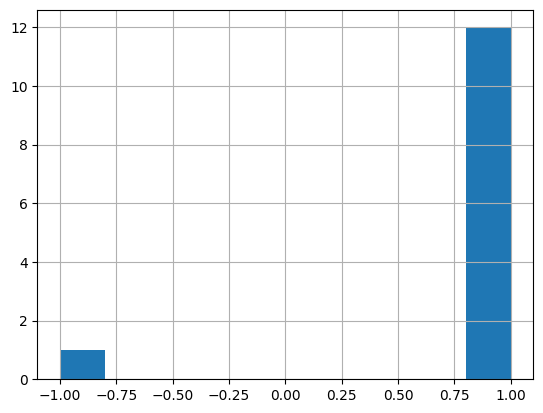

In [23]:
spearman_pairwise['coef'].hist(range=[-1, 1])

<Axes: >

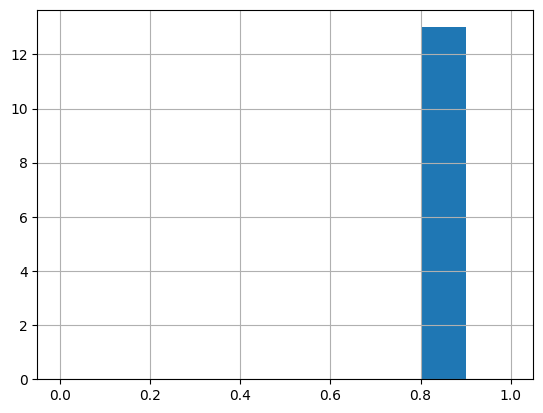

In [24]:
abs(spearman_pairwise['coef']).hist(range=[0, 1])

In [25]:
# filter for effect
df_no_effect = spearman_pairwise[abs(spearman_pairwise['coef'])<0.01]
df_very_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.01]
df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
df_effect = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
print('\nNumber of analyte pairs whose effect size is at least weak: '.format(str(df_effect.shape[0])))


# evaluate effect size - cohen's d
df_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
df_small = df_small[abs(df_small['coef'])<0.2]
df_medium = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.2]
df_medium  = df_medium[abs(df_medium['coef'])<0.3]
df_medium_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.3]
df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
df_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.5]
df_large = df_large[abs(df_large['coef'])<0.7]
df_very_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.7]
df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
df_huge = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.9]

# print info on effect sizes
print('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
print('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
print('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
print('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
print('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
print('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
print('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
print('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))


Number of analyte pairs whose effect size is at least weak: 
Number of Analyte Pairs with No Monotonic Relationship: 0
Number of Analyte Pairs with Very Weak Monotonic Relationship: 0
Number of Analyte Pairs with Weak Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 0
Number of Analyte Pairs with Strong Monotonic Relationship: 0
Number of Analyte Pairs with Very Strong Monotonic Relationship: 13
Number of Analyte Pairs with Near Perfect Monotonic Relationship: 0
